In [7]:
using Pkg
Pkg.activate("..")

  Activating project at `~/repos/ProactiveHRI.jl`


In [ ]:
# Pkg.instantiate()
# Pkg.update()

In [287]:
include("dynamics.jl")
include("planner.jl")
include("planner_utils.jl")
include("utils.jl")
include("plotting.jl")
include("mpc.jl")
include("sim.jl")
include("experiments.jl")

display_data (generic function with 1 method)

### Interaction planner

In [3]:
dt = 0.1
velocity_max = 3.0
# human = SingleIntegratorPolar2D(dt, velocity_max, [pi, 2.])
human = Unicycle(dt, velocity_max, [1., 3.])

time_horizon = 25
# Q = zeros(Float64, human.state_dim, human.state_dim)
# R = diagm([0.; 0.1]) 
# Qt = diagm([10.; 10.])
Q = diagm([0.0; 0.0; 0.])
R = diagm([1.0; 0.1]) 
Qt = diagm([10.; 10.; 0.])
markup = 1.05
collision_slack = 150.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.01]
collision_radius = 1.
inconvenience_ratio = 0.2


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 3.0
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)


PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.05
  collision_slack: Float64 150.0
  collision_markup: Float64 0.98
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.01]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2


In [4]:
robot_initial_state = [5.; 5.; -pi / 2.; 0.]
robot_goal_state = [5.; -5.; -pi / 2; 0.]
human_initial_state = [5.; -5.; pi / 2]
human_goal_state = [5.; 5.; pi / 2]
solver = "ECOS"

ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)
# 
# ip = InteractionPlanner(human_hps, 
#                         robot_hps,
#                         human_initial_state,
#                         robot_initial_state,
#                         human_goal_state,
#                         robot_goal_state,
#                         solver)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [5]:
# Adds a wall constraint to the planner
wall_1 = Wall("x", 0., 6.1, "less")
wall_constraint(ip, wall_1, "wall_1")
wall_2 = Wall("x", 0.1, 3.2, "greater")
wall_constraint(ip, wall_2, "wall_2")

26-element Vector{ConstraintRef{Model, MathOptInterface.ConstraintIndex{MathOptInterface.ScalarAffineFunction{Float64}, MathOptInterface.GreaterThan{Float64}}, ScalarShape}}:
 x[1,1] - 0.1 x[1,2] ≥ 4.2
 x[2,1] - 0.1 x[2,2] ≥ 4.2
 x[3,1] - 0.1 x[3,2] ≥ 4.2
 x[4,1] - 0.1 x[4,2] ≥ 4.2
 x[5,1] - 0.1 x[5,2] ≥ 4.2
 x[6,1] - 0.1 x[6,2] ≥ 4.2
 x[7,1] - 0.1 x[7,2] ≥ 4.2
 x[8,1] - 0.1 x[8,2] ≥ 4.2
 x[9,1] - 0.1 x[9,2] ≥ 4.2
 x[10,1] - 0.1 x[10,2] ≥ 4.2
 ⋮
 x[18,1] - 0.1 x[18,2] ≥ 4.2
 x[19,1] - 0.1 x[19,2] ≥ 4.2
 x[20,1] - 0.1 x[20,2] ≥ 4.2
 x[21,1] - 0.1 x[21,2] ≥ 4.2
 x[22,1] - 0.1 x[22,2] ≥ 4.2
 x[23,1] - 0.1 x[23,2] ≥ 4.2
 x[24,1] - 0.1 x[24,2] ≥ 4.2
 x[25,1] - 0.1 x[25,2] ≥ 4.2
 x[26,1] - 0.1 x[26,2] ≥ 4.2

In [8]:
incon_problem, xs, us = @time solve(ip.ego_planner.incon, iterations=10, verbose=false, keep_history=false)
incon_problem, xs, us = @time solve(ip.other_planner.incon, iterations=10, verbose=false, keep_history=false);



  0.128696 seconds (449.94 k allocations: 43.689 MiB, 17.52% gc time)


  0.092632 seconds (418.29 k allocations: 38.622 MiB, 9.45% gc time)


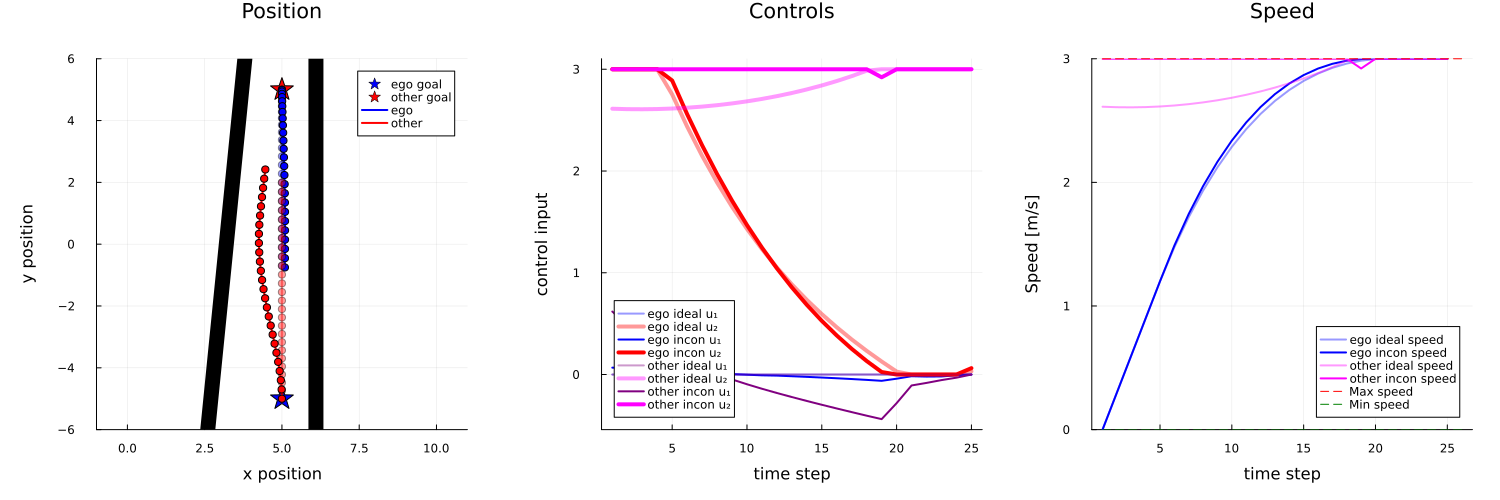

In [10]:
plot_solve_solution(ip, walls=[wall_1, wall_2], pos_xlims=[-1, 11], pos_ylims=[-6, 6])

# Iterated Best Response

In [ ]:
@time ibr(ip, 3, "ego")

In [ ]:
plot_solve_solution(ip, pos_xlims=[-1, 11], walls=nothing, pos_ylims=[-6, 6])

# Animation

In [ ]:
animation(ip, pos_xlims=[-1, 11], pos_ylims=[-4, 4])

In [ ]:
avoidance_animation(ip, pos_xlims=[0, 10], pos_ylims=[-5, 5])

# MPC Controller Simulation
*At the moment it is a known issue that the sim breaks if the dynamics classes used are different between the different InteractionPlanner models, will be fixed

In [176]:
include("sim.jl")
include("mpc.jl")

mpc_step (generic function with 2 methods)

In [245]:
solver = "ECOS"

time_horizon = 25
dt = 0.1
velocity_max = 1.5

human = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 1.5])

Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])
markup = 1.05
collision_slack = 150.
trust_region_weight = 0.
inconvenience_weights = [1.; 1.; 0.1]
collision_radius = 1.
inconvenience_ratio = 0.01

human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 1.5

robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 1.5])

Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)

PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.05
  collision_slack: Float64 150.0
  collision_markup: Float64 0.98
  trust_region_weight: Float64 0.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.1]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.01


In [253]:
robot_initial_state = [0.; 0.; 0.; 0.]
robot_goal_state = [10.; 0.; 0.; 0.]
human_initial_state = [10.; 0.; pi; 0.]
human_goal_state = [0.; 0.; pi; 0.]

robot_ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)


InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [254]:
dt = 0.1
velocity_max = 1.5
human = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 1.5])

time_horizon = 25
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 0.3]) 
Qt = diagm([10.; 10.; 0.; 0.])
markup = 1.05
collision_slack = 150.
trust_region_weight = 0.
inconvenience_weights = [1.; 1.; 0.1] 
collision_radius = 1.
inconvenience_ratio = 0.2


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 1.5
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 1.5])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 0.0]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)

PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 0.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.05
  collision_slack: Float64 150.0
  collision_markup: Float64 0.98
  trust_region_weight: Float64 0.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.1]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2


In [255]:
human_ip = InteractionPlanner(human_hps, 
                        robot_hps,
                        human_initial_state,
                        robot_initial_state,
                        human_goal_state,
                        robot_goal_state,
                        solver)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [256]:
robot_path, robot_controls, human_path, human_controls, solve_times = simulate(robot_ip, human_ip, 75, ibr_iterations=2, leader="ego")

([0.0 0.1 0.0 0.0; 0.007499948248024455 0.10002620055905877 0.005240126386837733 0.1499999946674951; … ; 7.1626542715294885 0.33314336700982955 -0.10726052749963878 0.0031271004549782554; 7.163291392267278 0.33307476581994705 -0.10823232796321954 0.009688966925857082], [0.05240126386837733 1.4999999466749512; -0.9999992926750793 1.4999999113101483; … ; -0.010801137473850827 -0.003529046864064493; -0.009718004635807473 0.06561866470878827], [10.0 0.0 3.141592653589793 0.0; 9.992500004626933 9.184845327246293e-19 3.1415925091943357 0.14999990746133723; … ; 0.8776078945110963 -0.11520230336274882 3.0148358105124125 0.5803799845599705; 0.8216163090953702 -0.10806672929488793 3.0146378370727334 0.5485086821639864], [-1.4439545737072839e-6 1.4999990746133722; -0.9999999852625349 1.4999996138861558; … ; -0.0021450413492833157 -0.331813123302118; -0.0019797343967921407 -0.31871302395984147], ([0.05209517478942871, 0.05675196647644043, 0.0506289005279541, 0.047068119049072266, 0.050814867019653

┌ Info: Saved animation to /tmp/jl_OnK52Ryxst.gif
└ @ Plots /home/jasper/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_OnK52Ryxst.gif")
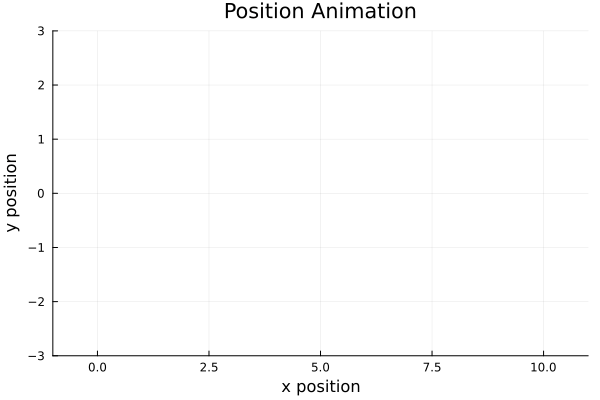

In [257]:
animation(robot_path, human_path, pos_xlims=[-1, 11])

┌ Info: Saved animation to /tmp/jl_UhwB8vABoV.gif
└ @ Plots /home/jasper/.julia/packages/Plots/3BCH5/src/animation.jl:156


Plots.AnimatedGif("/tmp/jl_UhwB8vABoV.gif")
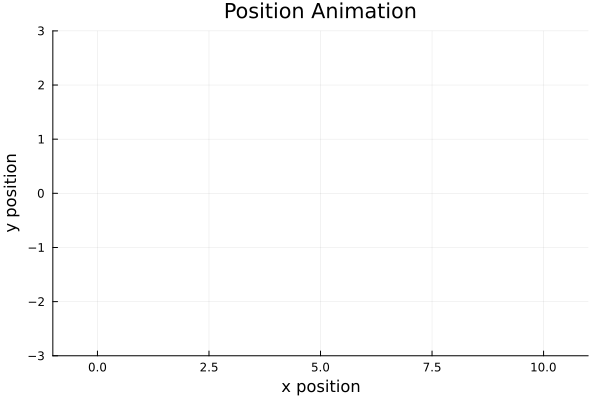

In [222]:
animation(robot_path, human_path, pos_xlims=[-1, 11])

In [189]:
sum(solve_times[1]) / 50

0.07004827976226807

In [183]:
findmax(solve_times[1] )

(0.2168440818786621, 6)

In [ ]:
plt = plot(robot_path[:,1], robot_path[:,2], xlims=[-1, 10], ylims=[-5, 5])
plot!(plt, human_path[:,1], human_path[:,2])

In [ ]:
animation(robot_path, human_path, pos_xlims=[-1, 11], pos_ylims=[-2.5, 2.5])

# Summary Plots

### Setup the planner

In [273]:
dt = 0.1
velocity_max = 1.5
# human = SingleIntegratorPolar2D(dt, velocity_max, [pi, 2.])
human = Unicycle(dt, velocity_max, [1., 1.5])

time_horizon = 50
# Q = zeros(Float64, human.state_dim, human.state_dim)
# R = diagm([0.; 0.1]) 
# Qt = diagm([10.; 10.])
Q = diagm([0.0; 0.0; 0.])
R = diagm([1.0; 0.0]) 
Qt = diagm([10.; 10.; 0.])
markup = 0.8
collision_slack = 150.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.01]
collision_radius = 1.
inconvenience_ratio = 0.13


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 1.5
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)


PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 50
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 0.8
  collision_slack: Float64 150.0
  collision_markup: Float64 0.98
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.01]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.13


In [274]:
robot_initial_state = [0.; 0.; 0.; 0.]
robot_goal_state = [10.; 0.; 0.; 0.]
human_initial_state = [10.; 0.; pi]
human_goal_state = [0.; 0.; pi]
solver = "ECOS"

ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [275]:
incon_problem, xs, us = @time solve(ip.ego_planner.incon, iterations=10, verbose=false, keep_history=false)
incon_problem, xs, us = @time solve(ip.other_planner.incon, iterations=10, verbose=false, keep_history=false);

  0.176211 seconds (845.82 k allocations: 84.993 MiB)


  0.374044 seconds (783.50 k allocations: 77.817 MiB, 39.09% gc time)


In [276]:
@time saved_data_test, _, _, _, _ = ibr_save(ip, 5, "ego")

  0.343603 seconds (1.07 M allocations: 100.188 MiB)


(SaveData
  previous_ips: Array{InteractionPlanner}((5,))
, [[1.3459776179392955e-10 1.257109534544691e-10 2.6170210912229074e-11 1.9359486941828775e-10; 0.009274478322636287 7.506017805558418e-5 0.01217317228007821 0.18549633959393916; … ; 6.6202237547576175 0.5972258535600264 -0.19918742519495866 1.499999436224254; 6.769436290655337 0.5672773443444293 -0.1969055131370458 1.5425516313733616], [-1.1423108383420762e-10 -1.0025418261680016e-10 -3.6571243081283475e-11 -1.2824075350039718e-10; 0.009546041547190878 8.143491165370342e-5 0.012814079550999237 0.1909286322801688; … ; 6.6623059254989485 0.5296894943756628 -0.17366569832862852 1.4999997281904627; 6.812378860967919 0.5035332420310347 -0.1713954698116737 1.5457171124713065], [-5.563714088574034e-10 -4.415963971727415e-10 -1.2636985523444728e-10 -8.369403493513685e-10; 0.009790693776561294 8.536758599567151e-5 0.013085467256160195 0.1958222682281325; … ; 6.693786600672012 0.47136844573931685 -0.15069671952372465 1.4999990278129247; 

In [291]:
include("plotting.jl")

avoidance_animation (generic function with 1 method)

1.1306044457414741

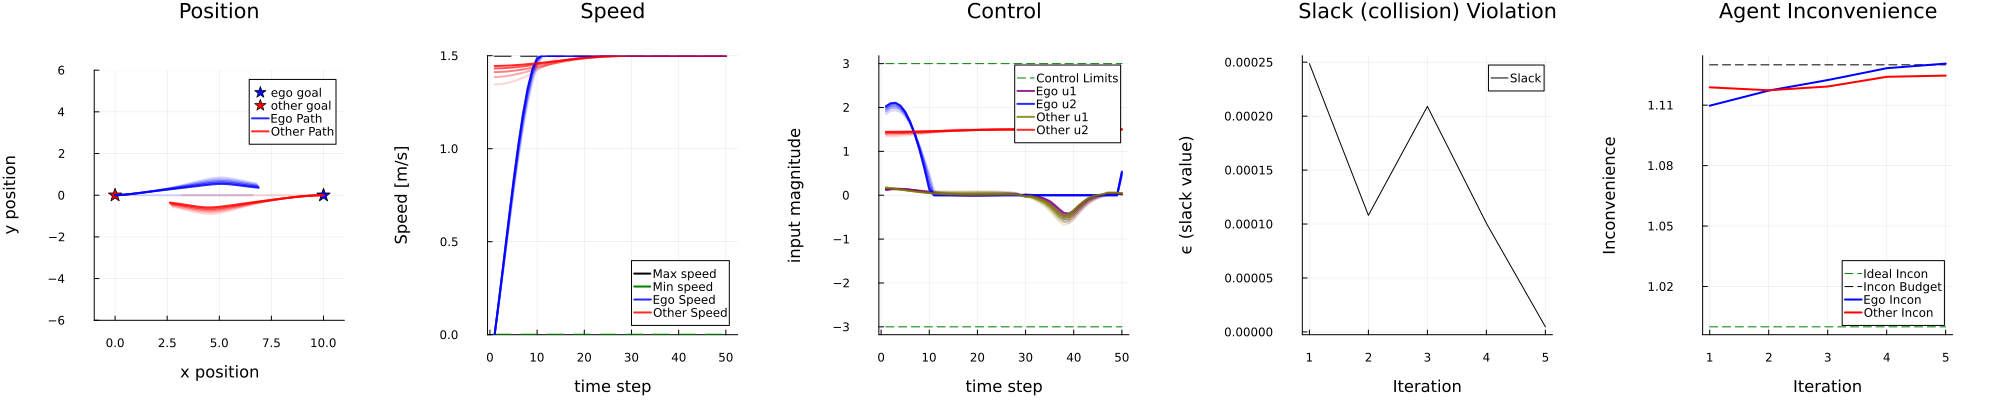

In [292]:
plot_example = plot_solve_solution(saved_data_test, scatter=false, show_speed=true, show_control=true)

AgentPlanner(IdealProblem(A JuMP Model
Minimization problem with:
Variables: 304
Objective function type: QuadExpr
`AffExpr`-in-`MathOptInterface.GreaterThan{Float64}`: 50 constraints
`AffExpr`-in-`MathOptInterface.LessThan{Float64}`: 50 constraints
`Vector{AffExpr}`-in-`MathOptInterface.Zeros`: 51 constraints
`Vector{AffExpr}`-in-`MathOptInterface.Nonpositives`: 100 constraints
Model mode: AUTOMATIC
CachingOptimizer state: ATTACHED_OPTIMIZER
Solver name: ECOS
Names registered in the model: control_constraints_lower_1, control_constraints_lower_10, control_constraints_lower_11, control_constraints_lower_12, control_constraints_lower_13, control_constraints_lower_14, control_constraints_lower_15, control_constraints_lower_16, control_constraints_lower_17, control_constraints_lower_18, control_constraints_lower_19, control_constraints_lower_2, control_constraints_lower_20, control_constraints_lower_21, control_constraints_lower_22, control_constraints_lower_23, control_constraints_lower_

In [263]:
function plot_solve_solution(problem::SaveData, second_problem::SaveData,show_theta::Bool; pos_xlims=[-1,11], pos_ylims=[-6, 6], scatter=true::Bool, show_speed=true::Bool, show_control=true::Bool)

    l = @layout [a b] 
    width=2000
    height=800
    alpha_plot = 0.7
    linewidth = 2
    markersize = 2
    markersize_large = 7
    ego_color = :blue
    other_color = :red

    global iterations = length(problem.previous_ips)

    alpha_ratio = 1 / (iterations + 1)
    N = problem.previous_ips[1].ego_planner.ideal.hps.time_horizon

    ego_goal_state = problem.previous_ips[1].ego_planner.ideal.opt_params.goal_state
    other_goal_state = problem.previous_ips[1].other_planner.ideal.opt_params.goal_state

    ego_dynamics = problem.previous_ips[1].ego_planner.ideal.hps.dynamics       # use first ip arbitrarily, any iteration will give the same values for these entries
    other_dynamics = problem.previous_ips[1].other_planner.ideal.hps.dynamics

    global ego_ctrl_dim = 2
    global other_ctrl_dim = 2

    # plotting position trajectory

    plot_traj = plot(size=(height, height), xlabel="x position", ylabel="y position", title="Position", margin=10mm, ylims=pos_ylims, xlims=pos_xlims, aspect_ratio=:equal)
    scatter!(ego_goal_state[1:1], ego_goal_state[2:2], marker=:star, markersize=markersize_large, color=ego_color, label="ego goal")
    scatter!(plot_traj, other_goal_state[1:1], other_goal_state[2:2], marker=:star, markersize=markersize_large, color=other_color, label="other goal")

    plot!(plot_traj, value.(problem.previous_ips[end].ego_planner.incon.model[:x])[:,1], value.(problem.previous_ips[end].ego_planner.incon.model[:x])[:,2], color=ego_color, linewidth=linewidth, label="Robot μ = 0.9", alpha=alpha_plot)

    plot!(plot_traj, value.(problem.previous_ips[end].other_planner.incon.model[:x])[:,1], value.(problem.previous_ips[end].other_planner.incon.model[:x])[:,2], color=other_color, linewidth=linewidth, label="Human μ = 0.9", alpha=alpha_plot)


    plot!(plot_traj, value.(second_problem.previous_ips[end].ego_planner.incon.model[:x])[:,1], value.(second_problem.previous_ips[end].ego_planner.incon.model[:x])[:,2], color=:purple, linewidth=linewidth, label="Robot μ = 1.1", alpha=alpha_plot)

    plot!(plot_traj, value.(second_problem.previous_ips[end].other_planner.incon.model[:x])[:,1], value.(second_problem.previous_ips[end].other_planner.incon.model[:x])[:,2], color=:green, linewidth=linewidth, label="Human μ = 1.1", alpha=alpha_plot)

    if scatter
        scatter!(plot_traj, value.(problem.previous_ips[end].ego_planner.ideal.model[:x])[:,1], value.(problem.previous_ips[end].ego_planner.ideal.model[:x])[:,2], color=ego_color, linewidth=linewidth, label="", alpha=alpha_plot)

        scatter!(plot_traj, value.(problem.previous_ips[end].other_planner.ideal.model[:x])[:,1], value.(problem.previous_ips[end].other_planner.ideal.model[:x])[:,2], color=other_color, linewidth=linewidth, label="", alpha=alpha_plot)

        scatter!(plot_traj, value.(second_problem.previous_ips[end].ego_planner.ideal.model[:x])[:,1], value.(second_problem.previous_ips[end].ego_planner.ideal.model[:x])[:,2], color=ego_color, linewidth=linewidth, label="", alpha=alpha_plot)

        scatter!(plot_traj, value.(second_problem.previous_ips[end].other_planner.ideal.model[:x])[:,1], value.(second_problem.previous_ips[end].other_planner.ideal.model[:x])[:,2], color=other_color, linewidth=linewidth, label="", alpha=alpha_plot)
    end
    # plotting speed/control

    # speed parameters
    max_speed = maximum([problem.previous_ips[1].ego_planner.ideal.hps.dynamics.velocity_max, problem.previous_ips[1].other_planner.ideal.hps.dynamics.velocity_max])
    ego_max_speed = problem.previous_ips[1].ego_planner.ideal.hps.dynamics.velocity_max
    other_max_speed = problem.previous_ips[1].other_planner.ideal.hps.dynamics.velocity_max

    # control parameters
    ego_ctrl_dim = problem.previous_ips[1].ego_planner.ideal.hps.dynamics.ctrl_dim
    other_ctrl_dim = problem.previous_ips[1].other_planner.ideal.hps.dynamics.ctrl_dim

    ego_max_ctrl = maximum(problem.previous_ips[1].ego_planner.ideal.hps.dynamics.control_max)
    ego_min_ctrl = minimum(problem.previous_ips[1].ego_planner.ideal.hps.dynamics.control_min)
    other_max_ctrl = maximum(problem.previous_ips[1].other_planner.ideal.hps.dynamics.control_max)
    other_min_ctrl = minimum(problem.previous_ips[1].other_planner.ideal.hps.dynamics.control_min)

    plot_theta = plot(size=(height, height), xlabel="time step", ylabel="abs(Theta)", title="Theta vs. time", margin=10mm, legend=:bottomright)
    plot_ctrl = plot(size=(height, height), xlabel="time step", ylabel="input magnitude", title="Control", margin=10mm)

    # angle plotting
    robot_xs_mu_09 = vector_of_vectors_to_matrix(problem.previous_ips[iterations].ego_planner.incon.opt_params.previous_states)
    human_xs_mu_09 = vector_of_vectors_to_matrix(problem.previous_ips[iterations].other_planner.incon.opt_params.previous_states)
    robot_xs_mu_11 = vector_of_vectors_to_matrix(second_problem.previous_ips[iterations].ego_planner.incon.opt_params.previous_states)
    human_xs_mu_11 = vector_of_vectors_to_matrix(second_problem.previous_ips[iterations].other_planner.incon.opt_params.previous_states)
    plot!(plot_theta, robot_xs_mu_09[:,3:3], linewidth=2, label="Robot μ = 0.9", color=ego_color)
    plot!(plot_theta, human_xs_mu_09[:,3:3], linewidth=2, label="Human μ = 0.9", color=other_color)
    plot!(plot_theta, robot_xs_mu_11[:,3:3], linewidth=2, label="Robot μ = 1.1", color=:magenta)
    plot!(plot_theta, human_xs_mu_11[:,3:3], linewidth=2, label="Human μ = 1.1", color=:green)

        # ctrl plotting
    plot!(plot_ctrl, 1:N, maximum([ego_max_ctrl, other_max_ctrl]) * ones(Float64, N), linestyle=:dash, linewith=linewidth,  color=:green, label="Control Limits")
    plot!(plot_ctrl, 1:N, minimum([ego_min_ctrl, other_min_ctrl]) * ones(Float64, N), linestyle=:dash, linewith=linewidth,  color=:green, label="")   
        # ego plot
    for j in 1:ego_ctrl_dim
        plot!(plot_ctrl, 1:N, vector_of_vectors_to_matrix(problem.previous_ips[iterations].ego_planner.incon.opt_params.previous_controls)[:, j], label="", color=RGB(1 - (1 / ego_ctrl_dim) * j, 0., (1 / ego_ctrl_dim) * j), linewidth=linewidth, alpha=(i * alpha_ratio))
        plot!(plot_ctrl, 1:N, vector_of_vectors_to_matrix(second_problem.previous_ips[iterations].ego_planner.incon.opt_params.previous_controls)[:, j], label="", color=RGB(1 - (1 / ego_ctrl_dim) * j, 0., (1 / ego_ctrl_dim) * j), linewidth=linewidth, alpha=(i * alpha_ratio))
    end 
        # other plot
    for k in 1:other_ctrl_dim
        plot!(plot_ctrl, 1:N, vector_of_vectors_to_matrix(problem.previous_ips[iterations].other_planner.incon.opt_params.previous_controls)[:, k], label="", color=RGB((1 / other_ctrl_dim) * k, 1 - (1 / other_ctrl_dim) * k, 0.), linewidth=linewidth, alpha=(i * alpha_ratio))
        plot!(plot_ctrl, 1:N, vector_of_vectors_to_matrix(second_problem.previous_ips[iterations].other_planner.incon.opt_params.previous_controls)[:, k], label="", color=RGB((1 / other_ctrl_dim) * k, 1 - (1 / other_ctrl_dim) * k, 0.), linewidth=linewidth, alpha=(i * alpha_ratio))
    end 


    slack_violation = Vector{Float64}(undef, iterations)

    for i in 1:iterations
        slack_violation[i] = value(problem.previous_ips[i].ego_planner.incon.model[:ϵ])
    end

    plot_slack_violation = plot(size=(height, height), xlabel="Iteration", ylabel="ϵ (slack value)", title="Slack (collision) Violation", margin=10mm)

    plot!(plot_slack_violation, 1:iterations, slack_violation, color=:black, label="Slack")

    # plotting inconvenience value over iterations

    incon_budget = problem.previous_ips[1].ego_planner.incon.hps.inconvenience_ratio
    inconvenience_ego = Vector{Float64}(undef, iterations)
    inconvenience_other = Vector{Float64}(undef, iterations)

    ideal_incon_ego = compute_convenience_value(ego_dynamics, matrix_to_vector_of_vectors(value.(problem.previous_ips[1].ego_planner.ideal.model[:x])), matrix_to_vector_of_vectors(value.(problem.previous_ips[1].ego_planner.ideal.model[:u])), ego_goal_state, problem.previous_ips[1].ego_planner.incon.hps.inconvenience_weights)

    ideal_incon_other = compute_convenience_value(other_dynamics, matrix_to_vector_of_vectors(value.(problem.previous_ips[1].other_planner.ideal.model[:x])), matrix_to_vector_of_vectors(value.(problem.previous_ips[1].other_planner.ideal.model[:u])), other_goal_state, problem.previous_ips[1].other_planner.incon.hps.inconvenience_weights)

    for i in 1:iterations
        inconvenience_ego[i] = compute_convenience_value(ego_dynamics, problem.previous_ips[i].ego_planner.incon.opt_params.previous_states, problem.previous_ips[i].ego_planner.incon.opt_params.previous_controls, ego_goal_state, problem.previous_ips[1].ego_planner.incon.hps.inconvenience_weights)
        
        inconvenience_other[i] = compute_convenience_value(other_dynamics, problem.previous_ips[i].other_planner.incon.opt_params.previous_states, problem.previous_ips[i].other_planner.incon.opt_params.previous_controls, other_goal_state, problem.previous_ips[1].other_planner.incon.hps.inconvenience_weights)
    end

    inconvenience_ego ./= ideal_incon_ego
    inconvenience_other ./= ideal_incon_other 

    plot_incon = plot(size=(height, height), xlabel="Iteration", ylabel="Inconvenience", title="Agent Inconvenience", margin=10mm)
    plot!(plot_incon, 1:iterations, ones(iterations), linestyle=:dash, linewith=linewidth, color=:green, label="Ideal Incon")
    plot!(plot_incon, 1:iterations, ones(iterations) .+ incon_budget, linestyle=:dash, linewith=linewidth, color=:black, label="Incon Budget")
    plot!(plot_incon, 1:iterations, inconvenience_ego, color=ego_color, linewidth=linewidth, label="Ego Incon")
    plot!(plot_incon, 1:iterations, inconvenience_other, color=other_color, linewidth=linewidth, label="Other Incon")

    plot(plot_traj, plot_theta, layout=l, size=(width, height))
end


plot_solve_solution (generic function with 8 methods)

# Sim Experimentation Utils

In [264]:
robot_params = PlannerParams(robot_ip.ego_planner.incon.hps, robot_ip.ego_planner.incon.opt_params, robot_ip.other_planner.incon.hps, robot_ip.other_planner.incon.opt_params)
human_params = PlannerParams(human_ip.ego_planner.incon.hps, human_ip.ego_planner.incon.opt_params, human_ip.other_planner.incon.hps, human_ip.other_planner.incon.opt_params)

PlannerParams(PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 0.3]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.05
  collision_slack: Float64 150.0
  collision_markup: Float64 0.98
  trust_region_weight: Float64 0.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.1]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2
, PlannerOptimizerParams{Float64}
  As: Array{Matrix{Float64}}((25,))
  Bs: Array{Matrix{Float64}}((25,))
  Cs: Array{Vector{Float64}}((25,))
  Gs: Array{Vector{Float64}}((26,))
  Hs: Array{Float64}((26,)) [49.631133529186855, 49.73603900780577, 49.93659150886466, 50.33644574067624, 50.9415929709795, 51.75695485841216, 52.78824655394339, 54.042271165689876, 55.526985062021446, 57.

In [265]:
sim_params = IPSimParams(robot_params, human_params)

IPSimParams(PlannerParams(PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 0.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.05
  collision_slack: Float64 150.0
  collision_markup: Float64 0.98
  trust_region_weight: Float64 0.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.1]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2
, PlannerOptimizerParams{Float64}
  As: Array{Matrix{Float64}}((25,))
  Bs: Array{Matrix{Float64}}((25,))
  Cs: Array{Vector{Float64}}((25,))
  Gs: Array{Vector{Float64}}((26,))
  Hs: Array{Float64}((26,)) [-51.63113352918629, -51.73614727601968, -51.93683780377234, -52.33673439680766, -52.941901408945675, -53.7572753160541, -54.78857492921602, -56.042603993993694, -57

In [266]:
# robot_xs, robot_us, human_xs, human_us, solve_times = simulate(robot_ip, human_ip, 50, ibr_iterations=2, leader="other")

In [267]:
sim_data = SimData(sim_params, solve_times, robot_path, robot_controls, human_path, human_controls)

SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 0.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.05
  collision_slack: Float64 150.0
  collision_markup: Float64 0.98
  trust_region_weight: Float64 0.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.1]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2
, PlannerOptimizerParams{Float64}
  As: Array{Matrix{Float64}}((25,))
  Bs: Array{Matrix{Float64}}((25,))
  Cs: Array{Vector{Float64}}((25,))
  Gs: Array{Vector{Float64}}((26,))
  Hs: Array{Float64}((26,)) [-51.63113352918629, -51.73614727601968, -51.93683780377234, -52.33673439680766, -52.941901408945675, -53.7572753160541, -54.78857492921602, -56.042603993993

In [ ]:
plot_solve_solution(sim_data)

In [ ]:
sim_data.solve_times

# Experimentation Code

In [ ]:
# for experiment in experiments
#     set up problem. Assign hyperparameters. Cycle through hps for each experiment
#     (markup, collision slack, trust region weights, incon weights, collision radius, incon ratio)
#     for opt_param in opt_params
#         assign new opt_params to the problem.
#         (initial states, goal states)
#         register the InteractionPlanner
#         run simulation
#         store data into dictionary w/ with key=run_number
#         (store: hps, opt_params, and paths) -- enough data to recreate the problem and plot Base.load_path_setup_code
#         delete interaction planner before cycling through the loop.
#     end
# end

In [ ]:
using ProgressBars

In [ ]:
# setting up the problem to be deep copied for experiments
# this is for experimentation where each agent correctly assumes the policy of the oteher agent

# setting up the robot planner
solver = "ECOS"

time_horizon = 25
dt = 0.1
velocity_max = 1.5

human = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 1.5])

Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])
markup = 1.05
collision_slack = 150.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.1]
collision_radius = 1.
inconvenience_ratio = 0.2

human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 1.5

robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 1.5])

Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)

robot_initial_state = [0.; 0.; 0.; 0.]
robot_goal_state = [10.; 0.; 0.; 0.]
human_initial_state = [10.; 0.; pi; 0.]
human_goal_state = [0.; 0.; pi; 0.]

robot_ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)
                             
human_ip = InteractionPlanner(human_hps, 
                        robot_hps,
                        human_initial_state,
                        robot_initial_state,
                        human_goal_state,
                        robot_goal_state,
                        solver)

### Mohr's Circle-ish Implementation 

In [ ]:
include("experiments.jl")

In [ ]:
test_human = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 1.5])

In [ ]:
robot_states = mohrs_circle_states(test_human, [0., 0., 0., 0.], [10., 0., 0., 0.], pi / 6);

In [ ]:
human_states = [([10., 0., pi, 0.], [0., 0., pi, 0.])]

### Simulation Code

In [ ]:
sim_test = simulation_sweep(robot_ip, human_ip, 50, robot_states, human_states)

In [ ]:
plot_solve_solution(sim_test["Run 12"], pos_xlims=[-1, 11], pos_ylims=[-6, 6])

# Data Metrics

In [ ]:
compute_average_control_effort(sim_data)

In [ ]:
compute_average_acceleration_per_segment(sim_data)

In [ ]:
compute_path_efficiency(sim_data)

In [ ]:
compute_path_irregularity_index(sim_data)

In [ ]:
compute_minimum_distance(sim_data)

In [ ]:
ttc = compute_time_to_collision(sim_data)
# ttc["Time to collision"]
# plot(1:50, ttc["Time to collision"])

In [ ]:
compute_dθ_dt(sim_data)

In [ ]:
compute_θ(sim_data)

In [ ]:
compute_time(sim_data)

In [ ]:
test_data_sweep_metrics = evaluate_sim(sim_test)

In [ ]:
test_data_sweep_metrics["Run 5"].plots["Combined Plot"]

In [ ]:
display_data(test_data_sweep_metrics)

# Experimental Setup

In [ ]:
using Serialization

In [ ]:
run_experiment(robot_ip, test_human_ip, 50, circular_experiment_states, [([10.; 0.; pi; 0.], [0.; 0.; pi; 0.])], "experimental_setup/metrics_test.dat")

In [3]:
using Serialization

In [293]:
proactiveHRI_robot_cooperative_human = deserialize("../experimental_results/ProactiveHRI_robot_cooperative_human.dat")
proactiveHRI_robot_less_cooperative_human = deserialize("../experimental_results/ProactiveHRI_robot_less-cooperative_human.dat")
proactiveHRI_robot_unaware_human = deserialize("../experimental_results/ProactiveHRI_robot_unaware_human.dat")
proactiveHRI_robot_aware_human = deserialize("../experimental_results/ProactiveHRI_robot_overly_aware__human.dat")
proactiveHRI_robot_cooperative_human_head_on = deserialize("../experimental_results/ProactiveHRI_robot_cooperative_human_head_on")
proactiveHRI_robot_less_cooperative_human_head_on = deserialize("../experimental_results/ProactiveHRI_robot_less-cooperative_human_head_on.dat")
proactiveHRI_robot_unaware_human_head_on = deserialize("../experimental_results/ProactiveHRI_robot_unaware_human_head_on.dat")
proactiveHRI_robot_overly_aware_human_head_on = deserialize("../experimental_results/ProactiveHRI_robot_overly_aware_human_head_on.dat")
SFM_robot_cooperative_human = deserialize("../experimental_results/SFM_robot_cooperative_human.dat")
SFM_robot_less_cooperative_human = deserialize("../experimental_results/SFM_robot_less-cooperative_human.dat")
SFM_robot_unaware_human = deserialize("../experimental_results/SFM_robot_unaware_human.dat")
SFM_robot_aware_human = deserialize("../experimental_results/SFM_robot_aware_human.dat")
SFM_robot_cooperative_human_head_on = deserialize("../experimental_results/SFM_robot_cooperative_human_head_on.dat")



Dict{String, SimMetrics} with 199 entries:
  "Run 151" => SimMetrics(Dict("Ego Avg Control Effort"=>0.38239, "Other Avg Co…
  "Run 140" => SimMetrics(Dict("Ego Avg Control Effort"=>0.382144, "Other Avg C…
  "Run 20"  => SimMetrics(Dict("Ego Avg Control Effort"=>0.386635, "Other Avg C…
  "Run 35"  => SimMetrics(Dict("Ego Avg Control Effort"=>0.392344, "Other Avg C…
  "Run 192" => SimMetrics(Dict("Ego Avg Control Effort"=>0.383658, "Other Avg C…
  "Run 127" => SimMetrics(Dict("Ego Avg Control Effort"=>0.381082, "Other Avg C…
  "Run 137" => SimMetrics(Dict("Ego Avg Control Effort"=>0.380766, "Other Avg C…
  "Run 181" => SimMetrics(Dict("Ego Avg Control Effort"=>0.382686, "Other Avg C…
  "Run 15"  => SimMetrics(Dict("Ego Avg Control Effort"=>0.387349, "Other Avg C…
  "Run 60"  => SimMetrics(Dict("Ego Avg Control Effort"=>0.382984, "Other Avg C…
  "Run 150" => SimMetrics(Dict("Ego Avg Control Effort"=>0.382637, "Other Avg C…
  "Run 99"  => SimMetrics(Dict("Ego Avg Control Effort"=>0.386684,

In [294]:
display_data(proactiveHRI_robot_cooperative_human_head_on)

GtkLabelLeaf(name="", parent, width-request=-1, height-request=-1, visible=TRUE, sensitive=TRUE, app-paintable=FALSE, can-focus=FALSE, has-focus=FALSE, is-focus=FALSE, focus-on-click=TRUE, can-default=FALSE, has-default=FALSE, receives-default=FALSE, composite-child=FALSE, style, events=0, no-show-all=FALSE, has-tooltip=FALSE, tooltip-markup=NULL, tooltip-text=NULL, window, opacity=1.000000, double-buffered, halign=GTK_ALIGN_FILL, valign=GTK_ALIGN_FILL, margin-left, margin-right, margin-start=0, margin-end=0, margin-top=0, margin-bottom=100, margin=100, hexpand=FALSE, vexpand=FALSE, hexpand-set=FALSE, vexpand-set=TRUE, expand=FALSE, scale-factor=1, xpad, ypad, label="<b><u>Sim 199 Metrics</u></b>
<b> </b> 
<b>Ego Average Acceleration = </b>0.2947
<b>Other Average Acceleration = </b>0.2992
<b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b>

In [295]:
display_data(SFM_robot_cooperative_human_head_on)

GtkLabelLeaf(name="", parent, width-request=-1, height-request=-1, visible=TRUE, sensitive=TRUE, app-paintable=FALSE, can-focus=FALSE, has-focus=FALSE, is-focus=FALSE, focus-on-click=TRUE, can-default=FALSE, has-default=FALSE, receives-default=FALSE, composite-child=FALSE, style, events=0, no-show-all=FALSE, has-tooltip=FALSE, tooltip-markup=NULL, tooltip-text=NULL, window, opacity=1.000000, double-buffered, halign=GTK_ALIGN_FILL, valign=GTK_ALIGN_FILL, margin-left, margin-right, margin-start=0, margin-end=0, margin-top=0, margin-bottom=100, margin=100, hexpand=FALSE, vexpand=FALSE, hexpand-set=FALSE, vexpand-set=TRUE, expand=FALSE, scale-factor=1, xpad, ypad, label="<b><u>Sim 199 Metrics</u></b>
<b> </b> 
<b>Ego Average Acceleration = </b>0.3372
<b>Other Average Acceleration = </b>0.3
<b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>

# Social Forces Sim w/ Dynamically Extended Unicycle Model

In [23]:
# setting up the human planner to be used for experiments (cooperative human)
solver = "ECOS"
dt = 0.1
velocity_max = 1.5
human = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 1.5])

time_horizon = 25
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 0.3]) 
Qt = diagm([10.; 10.; 0.; 0.])
markup = 1.05
collision_slack = 150.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.1]
collision_radius = 1.
inconvenience_ratio = 0.2


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 1.5
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 1.5])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 0.0]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)

robot_initial_state = [0.; 0.; 0.; 0.]
robot_goal_state = [10.; 0.; 0.; 0.]
human_initial_state = [10.; 0.; pi; 0.]
human_goal_state = [0.; 0.; pi; 0.]
# setting up the IP object to be serialized and saved for all trials
human_ip = InteractionPlanner(human_hps, 
                        robot_hps,
                        human_initial_state,
                        robot_initial_state,
                        human_goal_state,
                        robot_goal_state,
                        solver)

# saving object
# serialize("../experimental_setup/cooperative_human_ip.dat", human_ip)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [ ]:
robot = DynamicallyExtendedUnicycle(dt, 2., [1., 2.])

In [ ]:
metrics = run_experiment(robot, human_ip, 50, circular_states, [([10.; 0.; pi; 0.], [0.; 0.; pi; 0.])], p=1., q=2., τ=2., ψ=pi/6, c=0.3)

# HJ Reachability Experimentation Code

In [14]:
using Interpolations
using MAT
include("velocity_obstacles.jl")

reactive_velocity_obstacles (generic function with 1 method)

In [11]:
function simulation_sweep(ego_hps::PlannerHyperparameters, other_ip::InteractionPlanner, sim_horizon, ego_boundary_conditions::Vector{Tuple{Vector{Float64}, Vector{Float64}}}, other_boundary_conditions::Vector{Tuple{Vector{Float64}, Vector{Float64}}}; p=2., q=2., τ=2., ψ=pi/6, c=0.3)
    runs = maximum([length(ego_boundary_conditions), length(other_boundary_conditions)])

    ego_ego_hps = other_ip.other_planner.incon.hps
    ego_other_hps = other_ip.ego_planner.incon.hps
    other_ego_hps = other_ip.ego_planner.incon.hps
    other_other_hps = other_ip.other_planner.incon.hps

    # global HJIdata = matread("../hj_cache/DynamicallyExtendedUnicycle_VO_40_40_10_12_12.mat")
    global HJIdata = matread("../hj_cache/DynamicallyExtendedUnicycle_VO_50_50_10_20_20.mat")

    global V_mat = HJIdata["V"]
    global V_mat = [V_mat;;;V_mat[:,:,1:1,:,:]]
    global grid_knots = tuple((x -> convert(Vector{Float32}, vec(x))).(HJIdata["grid_knots"])...)
    push!(grid_knots[3], -grid_knots[3][1])
    global V = interpolate(Float32, Float32, grid_knots, V_mat, Gridded(Linear()));

    if length(ego_boundary_conditions) == 1 
        for i in 1:(runs - 1)
            push!(ego_boundary_conditions, ego_boundary_conditions[1])
        end
    elseif length(other_boundary_conditions) == 1
        for i in 1:(runs - 1)
            push!(other_boundary_conditions, other_boundary_conditions[1])
        end
    end

    if length(ego_boundary_conditions) != length(other_boundary_conditions)
        throw(ArgumentError("length of 'ego_boundary_conditions' and 'other_boundary_conditions' must match"))
    end

    runs_dict = Dict{String, SimData}()

    for j in ProgressBar(1:runs)
        sim_other_ip = InteractionPlanner(other_ego_hps, other_other_hps, other_boundary_conditions[j][1], ego_boundary_conditions[j][1], other_boundary_conditions[j][2], ego_boundary_conditions[j][2], "ECOS")

        ego_params = PlannerParams(sim_other_ip.other_planner.incon.hps, sim_other_ip.other_planner.incon.opt_params, sim_other_ip.ego_planner.incon.hps, sim_other_ip.ego_planner.incon.opt_params)
        other_params = PlannerParams(sim_other_ip.ego_planner.incon.hps, sim_other_ip.ego_planner.incon.opt_params, sim_other_ip.other_planner.incon.hps, sim_other_ip.other_planner.incon.opt_params)

        sim_params = IPSimParams(ego_params, other_params)

        ego_states, ego_controls, other_states, other_controls = simulate_hj(ego_hps, sim_other_ip, ego_boundary_conditions[j][1], ego_boundary_conditions[j][2], sim_horizon)

        sim_data = SimData(sim_params, ([0.], nothing), ego_states, ego_controls, other_states, other_controls)

        runs_dict["Run $(j)"] = sim_data

        # deleting variables
        sim_ego_ip = nothing
        sim_other_ip = nothing
        ego_params = nothing
        other_params = nothing
        sim_params = nothing
        ego_states = nothing
        ego_controls = nothing
        other_states = nothing
        other_controls = nothing
        sim_data = nothing
    end

    runs_dict
end

simulation_sweep (generic function with 3 methods)

In [24]:
test_robot = DynamicallyExtendedUnicycle(0.1, 2., [1., 0.5])
test_robot_hps = PlannerHyperparameters(test_robot)
robot_states = mohrs_circle_states(test_robot, [0., 0., 0., 0.], [10., 0., 0., 0.], pi / 6);

In [25]:
hj_sim_sweep_test = simulation_sweep(test_robot_hps, human_ip, 50, robot_states, [([10.; 0.; pi; 0.], [0.; 0.; pi; 0.])])

0.0%┣                                               ┫ 0/12 [00:00<00:00, -0s/it]


8.3%┣███▋                                       ┫ 1/12 [00:06<Inf:Inf, InfGs/it]


16.7%┣███████▊                                      ┫ 2/12 [00:11<01:55, 11s/it]


25.0%┣███████████▊                                   ┫ 3/12 [00:17<01:18, 9s/it]


33.3%┣███████████████▊                               ┫ 4/12 [00:23<01:02, 8s/it]


41.7%┣███████████████████▋                           ┫ 5/12 [00:29<00:51, 7s/it]


50.0%┣███████████████████████▌                       ┫ 6/12 [00:35<00:42, 7s/it]


58.3%┣███████████████████████████▍                   ┫ 7/12 [00:41<00:34, 7s/it]


66.7%┣███████████████████████████████▍               ┫ 8/12 [00:47<00:27, 7s/it]


75.0%┣███████████████████████████████████▎           ┫ 9/12 [00:53<00:20, 7s/it]


83.3%┣██████████████████████████████████████▍       ┫ 10/12 [00:59<00:13, 7s/it]


91.7%┣██████████████████████████████████████████▏   ┫ 11/12 [01:05<00:06, 6s/it]


100.0%┣█████████████████████████████████████████████┫ 12/12 [01:11<00:00, 6s/it]
100.0%┣█████████████████████████████████████████████┫ 12/12 [01:11<00:00, 6s/it]


Dict{String, SimData} with 12 entries:
  "Run 4"  => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 10" => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 1"  => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 11" => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 6"  => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 12" => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 2"  => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 9"  => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 5"  => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 8"  => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 7"  => SimData(IPSimParams(PlannerParams(PlannerHyperparameters{Float64}…
  "Run 3"  => SimData(IPSimParams(PlannerParams(PlannerHyperparameters

In [26]:
test_metrics = evaluate_sim(hj_sim_sweep_test)

(ego_velocities[i], ego_ideal_velocity) = ([0.0 0.0], [1.7483239476476952e-9 0.0])
(other_velocities[i], other_ideal_velocity) = ([-0.0 0.0], [2.859141557728453e-9 8.337001551598984e-19])
(ego_velocities[i], ego_ideal_velocity) = ([0.05 0.0], [0.0500000010027609 0.0])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.1499996877615451 1.334810188544993e-6], [-0.14999968342974682 1.334889395573451e-6])
(ego_velocities[i], ego_ideal_velocity) = 

0.0%┣                                               ┫ 0/12 [00:00<00:00, -0s/it]


([0.09797215188353386 0.0], [0.09797215162060384 0.0])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.29999465228981353 -0.00158135416734477], [-0.29999465154519966 -0.0015813542162684913])
(ego_velocities[i], ego_ideal_velocity) = ([0.14348811251955584 0.0], [0.14348811359384728 0.0])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.4499943511131219 -0.001944140137902048], [-0.44999435700660084 -0.0019441400985045164])
(ego_velocities[i], ego_ideal_velocity) = ([0.18659465828536975 0.0], [0.18659466055904506 0.0])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-0.5999939161107098 -0.0020800199216385773], [-0.5999939035168387 -0.002080020256302905])
(ego_velocities[i], ego_ideal_velocity) = ([0.2273085468466347 0.0], [0.2273085473827334 0.0])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.7499945162960763 -0.0020665622147969746], [-0.74999451899883 -0.0020665622541120917])
(ego_velocities[i], ego_ideal_velocity) = ([0.2656219032792009 0.0], [0.2656219061423805 0.0])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.899994578607422 -0.0019556666612300837], [-0.899994579598776 -0.001955666724158779])


(ego_velocities[i], ego_ideal_velocity) = ([0.30155921668378516 0.0], [0.30155921861382473 0.0])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.0499946761855916 -0.001748506081038094], [-1.049994676775195 -0.0017485061340171528])
(ego_velocities[i], ego_ideal_velocity) = ([0.335137302817466 0.0], [0.33513730408589765 0.0])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.1999942071255005 -0.0014944260714463997], [-1.1999942091627525 -0.0014944261358410301])
(ego_velocities[i], ego_ideal_velocity) = ([0.3663772395145478 0.0], [0.3663772406471864 0.0])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.3494255641168393 -0.001237958715328301], [-1.3494255587616009 -0.0012379588780342713])
(ego_velocities[i], ego_ideal_velocity) = ([0.3727478820709354 -0.021703742493738166], [0.37274788305025186 -0.021703742549288297])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4507432244950722 -0.0009385296428129476], [-1.4507432373393383 -0.0009385298474436807])
(ego_velocities[i], ego_ideal_velocity) = ([0.3936254168389569 -0.03137985605806152], [0.3936254191848713 -0.03137985624189063])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999918452491228 -0.0006608760793132461], [-1.4999958434202971 -0.0006608778918290415])
(ego_velocities[i], ego_ideal_velocity) = 

([0.4146533534505556 -0.03889155432801563], [0.4146533542294295 -0.038891554395346986])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999953690081067 -0.00043230126214394084], [-1.4999976528438497 -0.0004323019211680329])
(ego_velocities[i], ego_ideal_velocity) = ([0.43403107158888915 -0.04549490042918809], [0.4340310723659122 -0.045494900502376444])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.499978075644373 -0.0002548411543114358], [-1.49998902555962 -0.0002548431663335592])
(ego_velocities[i], ego_ideal_velocity) = ([0.45115859707170664 -0.05220607690916678], [0.45115859736709646 -0.0522060769427959])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4997847021753334 -0.00013306693271933538], [-1.4997847590385596 -0.00013306694523009213])
(ego_velocities[i], ego_ideal_velocity) = ([0.46628868734885837 -0.05841995551541924], [0.46628868797122086 -0.05841995557886617])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.499998312578783 -2.322846207841558e-5], [-1.4999991549165703 -2.3228480904609404e-5])
(ego_velocities[i], ego_ideal_velocity) = ([0.4790265981120494 -0.06468920757352344], [0.4790265988448907 -0.06468920765971714])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999928110658363 0.0013288695055379638], [-1.4999961096453371 0.0013288724660417885])


(ego_velocities[i], ego_ideal_velocity) = ([0.4894756899330887 -0.07067757771964686], [0.48947569093532095 -0.07067757787775353])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.49990743224937 0.013384114235291095], [-1.4999238510439181 0.013384254410363306])
(ego_velocities[i], ego_ideal_velocity) = ([0.4977216590423647 -0.07647156800619986], [0.4977216605047079 -0.07647156821741734])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4984591140642576 0.030469487995246246], [-1.4984591157155676 0.030469487073297854])
(ego_velocities[i], ego_ideal_velocity) = ([0.5039967578715068 -0.08179233587140639], [0.5039967592445473 -0.08179233608026269])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4980657876096286 -0.0761141328990788], [-1.4980667082815522 -0.07611417968810315])
(ego_velocities[i], ego_ideal_velocity) = ([0.5004527937538873 -0.08759577573890916], [0.5004527955690047 -0.0875957761088388])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4996596442122114 -0.03190892779553131], [-1.4996601054851917 -0.03190893761695194])
(ego_velocities[i], ego_ideal_velocity) = ([0.49608462399702596 -0.0923212776032335], [0.4960846248538835 -0.09232127781691432])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999499082208056 0.011354626858342133], [-1.499953465148488 0.01135465378097628])
(ego_velocities[i], ego_ideal_velocity) = 

([0.49115261077753464 -0.09616135833292924], [0.49115261137480476 -0.09616135845035528])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4986673764670932 0.06312885513514642], [-1.4986691813548676 0.06312893116330603])
(ego_velocities[i], ego_ideal_velocity) = ([0.4868643665591288 -0.09925402748223709], [0.4868643669411552 -0.09925402756223385])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.49529112558614 0.11872285261371365], [-1.495292675217028 0.11872297564980998])
(ego_velocities[i], ego_ideal_velocity) = ([0.48340735835802445 -0.10168475257121996], [0.4834073637043478 -0.10168475371301497])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4968916147958737 0.0776101129046478], [-1.496891630467152 0.07761011286108285])
(ego_velocities[i], ego_ideal_velocity) = ([0.473649291267709 -0.10199425980731947], [0.47364929273560574 -0.10199426011418944])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.487211062789133 0.034257890215958806], [-1.4872110678622719 0.03425788973189911])
(ego_velocities[i], ego_ideal_velocity) = ([0.4568461804508602 -0.09653132080957857], [0.4568461815719767 -0.09653132106740457])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4969589916185952 -0.09527347620713279], [-1.4969651029143571 -0.09527386520567344])


(ego_velocities[i], ego_ideal_velocity) = ([0.4504382265982968 -0.07810595025919288], [0.4504382274321422 -0.07810595041952972])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.483946253696419 -0.21720281862972654], [-1.4839463406303472 -0.21720283164509976])
(ego_velocities[i], ego_ideal_velocity) = ([0.44338860736969005 -0.062421731056440305], [0.44338860896914317 -0.06242173128078506])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4690193027894245 -0.3032765961273898], [-1.4690202158751324 -0.3032767846376692])
(ego_velocities[i], ego_ideal_velocity) = ([0.4383707055915859 -0.04934287152257863], [0.4383707078161369 -0.04934287176714418])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.488794957242906 -0.1829928033766775], [-1.488795488197394 -0.18299286863883055])
(ego_velocities[i], ego_ideal_velocity) = ([0.4270207677833587 -0.048014383129892], [0.4270207651342883 -0.04801438284897259])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4980862346706605 -0.0757364613138716], [-1.4980865045863827 -0.07573647497400672])
(ego_velocities[i], ego_ideal_velocity) = ([0.4189022559733887 -0.04749272689857545], [0.4189022599027645 -0.047492727363507216])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4997010277628366 0.029929749253088264], [-1.4997012008172959 0.02992975270696289])
(ego_velocities[i], ego_ideal_velocity) = 

([0.4125586391240873 -0.04658403174142614], [0.4125586370139056 -0.04658403151345285])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4941661987829065 0.1321616321837808], [-1.4941663106309868 0.1321616420764002])
(ego_velocities[i], ego_ideal_velocity) = ([0.4073312277223958 -0.0449263180900204], [0.40733122802198096 -0.044926318118275174])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4834602780847024 0.22210605279873535], [-1.4834626689064558 0.2221064107597623])
(ego_velocities[i], ego_ideal_velocity) = ([0.40088591936647566 -0.03997497737610033], [0.4008859209217533 -0.03997497754453927])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4699410076780972 0.29877428312002885], [-1.4699422100571988 0.29877452751339234])
(ego_velocities[i], ego_ideal_velocity) = ([0.39511665219517406 -0.034841632124180434], [0.3951166541661539 -0.034841632303330004])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.456667035909479 0.35793463968799455], [-1.4566676736558224 0.35793479624352653])
(ego_velocities[i], ego_ideal_velocity) = ([0.3900170370582995 -0.029622763655874223], [0.390017038458202 -0.02962276376959477])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4580901791685488 0.3520952366687458], [-1.4580904990393457 0.352095313318776])


(ego_velocities[i], ego_ideal_velocity) = ([0.3853107337176285 -0.024406921690316895], [0.38531073484320216 -0.024406921768426026])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4581683466464619 0.35177136712030044], [-1.458168667237977 0.3517714439302372])
(ego_velocities[i], ego_ideal_velocity) = ([0.38110668458633296 -0.01924355838110278], [0.38110668528492353 -0.019243558422216728])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4574216528838742 0.354853674813749], [-1.4574218141314175 0.3548537136022677])
(ego_velocities[i], ego_ideal_velocity) = ([0.37750322335789344 -0.014173751995772213], [0.3775032236830905 -0.014173752012572047])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.45611191230303 0.3601896765685751], [-1.456112154388066 0.36018973602290255])
(ego_velocities[i], ego_ideal_velocity) = ([0.373745365865996 -0.009572658948105656], [0.37374536330625197 -0.009572658876440078])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4547215169681251 0.36576570816750964], [-1.454721639055365 0.36576573847209076])
(ego_velocities[i], ego_ideal_velocity) = ([0.36922105220122126 -0.00563487982424827], [0.3692210556318883 -0.005634879892347621])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4535643295784886 0.3703376201550898], [-1.4535644567488009 0.37033765218236486])
(ego_velocities[i], ego_ideal_velocity) = 

([0.36393776458824806 -0.0022882483535828727], [0.36393776564846675 -0.002288248354986172])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4523088785807279 0.37523127873834206], [-1.4523089446851964 0.3752312953388002])
(ego_velocities[i], ego_ideal_velocity) = ([0.35799764378950016 0.0005323264558837081], [0.3579976459290443 0.0005323264532330669])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4513538955538656 0.37890622638523697], [-1.4513542087224378 0.3789063078041925])
(ego_velocities[i], ego_ideal_velocity) = ([0.3514748341634252 0.0028866569140024788], [0.3514748355474258 0.0028866569172595687])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4513874483839888 0.37877869063174135], [-1.4513876384816171 0.37877873987902366])
(ego_velocities[i], ego_ideal_velocity) = ([0.3443776896764308 0.004829626080588668], [0.3443776890888004 0.0048296260578538025])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.449467644736093 0.3791438454045017], [-1.4494676473015786 0.3791438455955675])
(ego_velocities[i], ego_ideal_velocity) = ([0.33680210594033655 0.006413507585577616], [0.3368021096825785 0.006413507613002567])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4454959135434162 0.37850364220265836], [-1.4454959141813433 0.3785036418499618])


(ego_velocities[i], ego_ideal_velocity) = ([0.3287513595514402 0.007682760433557319], [0.3287513624534359 0.007682760485535578])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4399025488581656 0.37469917081927506], [-1.439902549285042 0.3746991703431771])
(ego_velocities[i], ego_ideal_velocity) = ([0.32026876722336034 0.008675896635251413], [0.3202687732031179 0.008675896733720526])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4293975324407648 0.36938054541428306], [-1.429397532814335 0.3693805448468016])
(ego_velocities[i], ego_ideal_velocity) = ([0.311392584069354 0.009412481553789763], [0.31139259122242496 0.009412481727649335])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4143496962085431 0.36321020279451427], [-1.4143496966081786 0.3632102021169774])
5151

8.3%┣███▋                                       ┫ 1/12 [00:02<Inf:Inf, InfGs/it]


(ego_velocities[i], ego_ideal_velocity) = ([0.0 0.0], [-2.0236962286513923e-10 -1.1683815623650014e-10])
(other_velocities[i], other_ideal_velocity) = ([-0.0 0.0], [4.670206179416528e-10 7.476155424949649e-22])
(ego_velocities[i], ego_ideal_velocity) = ([0.04283193271611761 0.02579584345978968], [0.04283193284559989 0.02579584353737868])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-0.14999972859687247 1.3991157098882682e-6], [-0.14999972878593984 1.4002564349035545e-6])
(ego_velocities[i], ego_ideal_velocity) = ([0.08464988988260415 0.05323900912307195], [0.08464988852562555 0.05323900825638939])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.2999954221647006 -0.001568053989523516], [-0.2999954226556667 -0.0015680539874444862])


(ego_velocities[i], ego_ideal_velocity) = ([0.1253530981432197 0.08237978399217162], [0.12535309821460183 0.08237978403966977])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.44999503415182573 -0.0019275163449485695], [-0.44999503404159286 -0.0019275163438179177])
(ego_velocities[i], ego_ideal_velocity) = ([0.16487632788283785 0.11320387676771913], [0.16487632774120792 0.11320387667356697])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-0.5999946174898507 -0.002061214140197608], [-0.5999946150499741 -0.002061214173710825])
(ego_velocities[i], ego_ideal_velocity) = ([0.20317174971379642 0.14567140160215364], [0.2031717498356312 0.14567140168703183])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.7499949784554967 -0.0020478927388257774], [-0.7499949779686809 -0.0020478927472776898])
(ego_velocities[i], ego_ideal_velocity) = 

([0.24023650629158336 0.179680192696739], [0.2402365060533667 0.17968019253038103])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.8999943314890495 -0.0019409388741903463], [-0.8999943320399986 -0.0019409388579469022])
(ego_velocities[i], ego_ideal_velocity) = ([0.27607161476119757 0.21513360445448537], [0.27607161472930597 0.21513360443014903])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.0499948491983844 -0.0017353031257272874], [-1.0499948491416202 -0.00173530312105961])
(ego_velocities[i], ego_ideal_velocity) = ([0.31072370374738545 0.25188813015412437], [0.31072370370100677 0.2518881301178704])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.1999942397007115 -0.0014834966718135062], [-1.1999942390241596 -0.0014834966682422469])


(ego_velocities[i], ego_ideal_velocity) = ([0.3444319168036578 0.2895897702461749], [0.34443191657118166 0.28958977006997627])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.3494369233186356 -0.0012275392555240153], [-1.3494369233011692 -0.001227539255389471])
(ego_velocities[i], ego_ideal_velocity) = ([0.3719633137634437 0.3322169531407517], [0.37196331378428943 0.33221695315431893])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4507356286652273 -0.0009316849689156755], [-1.450735628638357 -0.0009316849669327928])
(ego_velocities[i], ego_ideal_velocity) = ([0.3993679602876019 0.3720891892514131], [0.39936796031239336 0.37208918926159995])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4999912760916947 -0.0006573046738865284], [-1.4999955660458935 -0.000657306554193751])
(ego_velocities[i], ego_ideal_velocity) = ([0.4224893818992915 0.41092764428021894], [0.422489381876044 0.4109276440510689])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4997596465878744 -0.0004395688250450975], [-1.4997596697641766 -0.00043956883124847185])


(ego_velocities[i], ego_ideal_velocity) = ([0.44190371793751243 0.4489855439604394], [0.4419037179344276 0.44898554395621265])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999975254380256 -0.0002598558926497896], [-1.4999987513424171 -0.0002598560956652858])
(ego_velocities[i], ego_ideal_velocity) = ([0.45603003457888647 0.48689890846082423], [0.45603003455894414 0.48689890844477807])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4999987242860684 -0.0001234240912512969], [-1.4999993595144554 -0.0001234241363647253])
(ego_velocities[i], ego_ideal_velocity) = ([0.45901374998179506 0.5274148944787732], [0.4590137499842927 0.527414894396648])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999969063360143 0.0027154873708347487], [-1.4999972240729145 0.00271548795244385])
(ego_velocities[i], ego_ideal_velocity) = 

([0.4318581487437744 0.5691851285261776], [0.4318581487220351 0.569185128509964])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4998554329983587 0.020802065110780178], [-1.4998555919893208 0.02080206731595488])
(ego_velocities[i], ego_ideal_velocity) = ([0.38776742514307866 0.60520241593809], [0.3877674251282996 0.6052024159384786])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4993713130185733 0.04338023423175512], [-1.4993719495720055 0.04338025275782179])
(ego_velocities[i], ego_ideal_velocity) = ([0.38875758029003593 0.6390385678846252], [0.3887575802765189 0.6390385678799436])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4984963274329368 -0.06712689204042124], [-1.4984967831400544 -0.06712691240690254])


(ego_velocities[i], ego_ideal_velocity) = ([0.3911362190336381 0.6720476605049904], [0.3911362190041191 0.6720476604863276])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4914763082212925 -0.15967767970347507], [-1.4914765499916713 -0.15967770564578823])
(ego_velocities[i], ego_ideal_velocity) = ([0.4285210576485809 0.6832992498884278], [0.4285210575504768 0.683299249851684])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4973278160827213 -0.08948114936379], [-1.4973282369056744 -0.0894811746088262])
(ego_velocities[i], ego_ideal_velocity) = ([0.43000993002976245 0.7083949357693363], [0.4300099299671985 0.7083949357319415])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4992287962702022 -0.048075579479279644], [-1.4992290879183143 -0.04807558885450139])
(ego_velocities[i], ego_ideal_velocity) = 

([0.42766758426050083 0.7311076073928177], [0.4276675844749924 0.7311076074981678])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999245351620152 0.015001340501067068], [-1.4999247594883607 0.015001342803676928])
(ego_velocities[i], ego_ideal_velocity) = ([0.42422521145275177 0.7500893994734414], [0.4242252129423809 0.7500894003234686])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4998666346469056 -0.019894303629620264], [-1.4998673499070596 -0.019894313097614615])
(ego_velocities[i], ego_ideal_velocity) = ([0.4206642404108133 0.7669259730934942], [0.4206642410396469 0.7669259735024834])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.499494842727075 -0.038564652759208264], [-1.499499502732272 -0.038564772470453104])


(ego_velocities[i], ego_ideal_velocity) = ([0.41605847614858243 0.7815099956358885], [0.4160584766395848 0.781509995997231])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.497652231099588 -0.08279153429872184], [-1.4976820232842014 -0.08279317075556264])
(ego_velocities[i], ego_ideal_velocity) = ([0.4108509018675919 0.7945128400656913], [0.41085090227996723 0.7945128403972337])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4931490755487429 -0.1428331423501357], [-1.4931663906168324 -0.1428348020143974])
(ego_velocities[i], ego_ideal_velocity) = ([0.40496803807264603 0.8065842124556606], [0.4049680379034123 0.8065842123617841])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4860618703265378 -0.20402460756117707], [-1.4860608923370981 -0.20402447329362408])
(ego_velocities[i], ego_ideal_velocity) = 

([0.39886633180601466 0.8178120449849359], [0.3988663320040208 0.8178120452366213])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4771690364216352 -0.2607187791659276], [-1.4771686024539261 -0.2607187025762351])
(ego_velocities[i], ego_ideal_velocity) = ([0.4409362629742286 0.8026351005550898], [0.440936262889056 0.8026351005134909])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4690011023077842 -0.30337610635133244], [-1.4690008900339413 -0.30337606251534366])
(ego_velocities[i], ego_ideal_velocity) = ([0.43212916055120143 0.8086962822314161], [0.4321291605264386 0.808696282234005])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.461927159740749 -0.33581131753024873], [-1.4619271172430774 -0.33581130779057256])


(ego_velocities[i], ego_ideal_velocity) = ([0.4710614482726155 0.7862568589289303], [0.47106144820711 0.7862568589571579])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4565871028610953 -0.35824821145885893], [-1.4565890792959333 -0.3582486993236976])
(ego_velocities[i], ego_ideal_velocity) = 

([0.45919404804017544 0.7868703044913926], [0.45919404787262547 0.7868703044241346])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.452993209545262 -0.372504584841282], [-1.4530014461314709 -0.37250670180714635])
(ego_velocities[i], ego_ideal_velocity) = ([0.44575387078437995 0.7867017115123957], [0.4457538707387329 0.7867017115265764])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4527072002605261 -0.37338481487407876], [-1.4527078778880382 -0.3733849890565285])
(ego_velocities[i], ego_ideal_velocity) = ([0.43106745016050035 0.785363380130144], [0.43106745038970573 0.7853633804371862])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4546639290160914 -0.365993403670526], [-1.454664199594794 -0.36599347260875437])


(ego_velocities[i], ego_ideal_velocity) = ([0.41483025135303253 0.7828024477591233], [0.41483025132421714 0.7828024477600678])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4589596023026798 -0.34847672716506445], [-1.4589597398502432 -0.34847676012454615])
(ego_velocities[i], ego_ideal_velocity) = ([0.3968291538375256 0.7789053721896539], [0.3968291542139385 0.7789053728320482])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.464915033587316 -0.3225267635439866], [-1.46491510364504 -0.32252677905029625])
(ego_velocities[i], ego_ideal_velocity) = ([0.37709894677822126 0.7735251935697653], [0.37709894671537825 0.7735251936278088])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4717172809680514 -0.2898848695349598], [-1.4717197310203483 -0.2898853548710092])
(ego_velocities[i], ego_ideal_velocity) = 

([0.3554960732943671 0.7663548115438339], [0.35549607329008176 0.7663548115779725])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4789000609415566 -0.25069252736666914], [-1.4789013504375457 -0.25069274801581276])
(ego_velocities[i], ego_ideal_velocity) = ([0.33216554394457964 0.7571738293865572], [0.3321655436939323 0.7571738294038736])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4856737448231274 -0.20680809729357866], [-1.4856743938995818 -0.20680818790724204])
(ego_velocities[i], ego_ideal_velocity) = ([0.30710730210405546 0.7455463755502763], [0.30710730204969355 0.7455463755343582])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4917584806885202 -0.1570179758666427], [-1.4917588102986254 -0.15701801072338434])


(ego_velocities[i], ego_ideal_velocity) = ([0.28038085405241286 0.7312044031682366], [0.2803808543730721 0.7312044039672088])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4961701252495319 -0.10710968933765597], [-1.496170535685419 -0.10710971885114381])
(ego_velocities[i], ego_ideal_velocity) = ([0.25240171916585186 0.7137559856701197], [0.2524017191469436 0.7137559857087701])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4987276381984438 -0.061750302881726886], [-1.498728032020021 -0.061750319203742986])
(ego_velocities[i], ego_ideal_velocity) = ([0.2234146878208063 0.6922694896149126], [0.2234146872176219 0.6922694882757383])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4998156341725786 -0.023472974036715086], [-1.4998159809931688 -0.02347297954599226])
(ego_velocities[i], ego_ideal_velocity) = 

([0.193748235991524 0.6666217196289304], [0.19374823568599978 0.666621719481053])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999729028451774 0.00893496020038958], [-1.4999731453453182 0.008934961573430326])
(ego_velocities[i], ego_ideal_velocity) = ([0.16310876451957715 0.6232156611495481], [0.16310876447843892 0.6232156611557986])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4995564591215202 0.03646236618284624], [-1.499556612619765 0.0364623699050738])
(ego_velocities[i], ego_ideal_velocity) = ([0.13623696115700173 0.578377950058773], [0.13623696114952263 0.5783779502139681])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.498801515331106 0.0599391349105969], [-1.4988017346889135 0.059939143679068795])


(ego_velocities[i], ego_ideal_velocity) = ([0.11509041323794758 0.531897633774125], [0.11509041314984332 0.5318976335594868])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4978627526689905 0.08004044044259133], [-1.4978628694152116 0.0800404466850079])
(ego_velocities[i], ego_ideal_velocity) = ([0.10341968071107985 0.4832645228130499], [0.10341968069402982 0.48326452275251575])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4968390047045312 0.09732670200510053], [-1.4968390890149303 0.09732670749022973])
(ego_velocities[i], ego_ideal_velocity) = ([0.10438640805758491 0.4317673453554051], [0.10438640791058508 0.4317673451581962])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.492673098053484 0.11220152871726592], [-1.4926730980980114 0.11220152871960505])
51

51(ego_velocities[i], ego_ideal_velocity) = ([0.0 0.0], [1.4502047477923276e-10 2.5118283045236393e-10])
(other_velocities[i], other_ideal_velocity) = ([-0.0 0.0], [4.670206179416528e-10 7.476155424949649e-22])


16.7%┣███████▉                                       ┫ 2/12 [00:07<01:08, 7s/it]


(ego_velocities[i], ego_ideal_velocity) = ([0.02383063749935235 0.0439556676251705], [0.02383063744529224 0.04395566752637794])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.14999956787830226 1.4984514617590444e-6], [-0.14999956806826523 1.4995917881387547e-6])
(ego_velocities[i], ego_ideal_velocity) = ([0.04512338393103251 0.08924052437401724], [0.04512338371056036 0.08924052394194307])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-0.2999952877354051 -0.0015665894466082395], [-0.2999952882352464 -0.0015665894444869641])
(ego_velocities[i], ego_ideal_velocity) = ([0.0636477798245371 0.13582618196404717], [0.06364777968847865 0.13582618165471866])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.4499951096558978 -0.0019259569565447225], [-0.44999510953722544 -0.0019259569555006356])
(ego_velocities[i], ego_ideal_velocity) = 

([0.07930393648208789 0.18360418688738595], [0.07930393636542493 0.18360418663040445])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.5999956036444233 -0.0020594223182948367], [-0.5999956012020733 -0.0020594223518639538])
(ego_velocities[i], ego_ideal_velocity) = ([0.0920381362903068 0.23243960250753523], [0.09203813610704084 0.23243960206846795])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-0.74999616248083 -0.0020457039580158358], [-0.7499961620059438 -0.0020457039662359375])
(ego_velocities[i], ego_ideal_velocity) = ([0.10194350417828908 0.28214610053538175], [0.10194350404900233 0.2821461001747358])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.8999961207346071 -0.001936938175318183], [-0.8999961212819898 -0.0019369381591688947])


(ego_velocities[i], ego_ideal_velocity) = ([0.10915183361408577 0.33254242075940316], [0.1091518335649486 0.3325424206143459])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.0499959175903244 -0.0017321524124062834], [-1.0499959175333127 -0.0017321524077360314])
(ego_velocities[i], ego_ideal_velocity) = ([0.11382685931529445 0.3834602436329832], [0.1138268592579639 0.38346024347221236])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.1999961582858765 -0.0014797486376063413], [-1.19999615761008 -0.0014797486340295968])
(ego_velocities[i], ego_ideal_velocity) = ([0.11615660470385769 0.43474733449779074], [0.11615660469404553 0.4347473344655408])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.3494343542839013 -0.0012244984508809108], [-1.3494343542663707 -0.0012244984507451494])
(ego_velocities[i], ego_ideal_velocity) = 

([0.11700024464086145 0.4861151357828335], [0.11700024462715217 0.48611513575744275])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4507442273724367 -0.0009271205182162576], [-1.4507442273456024 -0.0009271205162341154])
(ego_velocities[i], ego_ideal_velocity) = ([0.11508166268264201 0.5378221555198143], [0.11508166266036723 0.5378221554351674])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4999944581158544 -0.0006537297729256792], [-1.4999971578632156 -0.000653730951116244])
(ego_velocities[i], ego_ideal_velocity) = ([0.11235399836557086 0.5893833269645055], [0.11235399835624137 0.589383326735801])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999950609342732 -0.0004247575533219369], [-1.4999975003828494 -0.00042475824138719725])


(ego_velocities[i], ego_ideal_velocity) = ([0.10798025944427227 0.6409647060035745], [0.10798025941632627 0.6409647057368111])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999973667672477 -0.0002402555833413853], [-1.4999986735381703 -0.00024025577997324236])
(ego_velocities[i], ego_ideal_velocity) = ([0.10204930486294782 0.6925176289700274], [0.10204930485915133 0.6925176289551527])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.499997539387591 -0.00010777166798997403], [-1.4999987676739646 -0.00010777174939191626])
(ego_velocities[i], ego_ideal_velocity) = ([0.09125881027359918 0.7444220399355423], [0.0912588103045853 0.7444220399375091])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999985664681228 0.000737372359184824], [-1.4999991925009004 0.0007373726725114968])
(ego_velocities[i], ego_ideal_velocity) = 

([0.075546536170678 0.7958409037738068], [0.07554653615667334 0.7958409036988903])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999467667899036 0.012562095235472689], [-1.499947081872158 0.012562097874357818])
(ego_velocities[i], ego_ideal_velocity) = ([0.051550462902792686 0.8466718835942969], [0.05155046298620815 0.8466718833477768])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.499679031266414 0.030957248585720683], [-1.4996797730242368 0.030957264157120176])
(ego_velocities[i], ego_ideal_velocity) = ([0.004956378136594674 0.8944938078871516], [0.004956378210155826 0.8944938077834663])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999396681050574 -0.013367245444300579], [-1.4999400528852131 -0.013367248841411355])


(ego_velocities[i], ego_ideal_velocity) = ([-0.05703271462513715 0.9377331905913368], [-0.05703271480010977 0.937733190720907])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4795541911269865 -0.11903307275052269], [-1.4795541905702474 -0.11903307274835578])
(ego_velocities[i], ego_ideal_velocity) = ([-0.11353757237601125 0.9819964103961417], [-0.11353757246471308 0.9819964104722979])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4993818473395306 -0.04295755294767176], [-1.4993833000622427 -0.04295759458175309])


(ego_velocities[i], ego_ideal_velocity) = ([-0.179520976836925 1.01850511216167], [-0.1795209768863653 1.0185051121692341])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4997942952199417 0.02475000403675333], [-1.4997950463141272 0.02475001648755063])
(ego_velocities[i], ego_ideal_velocity) = ([-0.2318422577377099 1.05475485801857], [-0.23184225787001098 1.0547548579691994])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4976693717232314 0.08356529131167979], [-1.4976699199794383 0.08356532192668183])
(ego_velocities[i], ego_ideal_velocity) = ([-0.27178630001404464 1.093105846643687], [-0.2717863008780377 1.0931058463880496])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.494070960678932 0.1332296796909964], [-1.494071262308663 0.13322970697194375])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.2934782053336955 1.1382755475251298], [-0.2934782051732864 1.1382755475632504])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4596258041733352 0.04579980709548708], [-1.4596258052611402 0.04579980849525906])
(ego_velocities[i], ego_ideal_velocity) = ([-0.3266456158346996 1.1789214421330856], [-0.3266456158022815 1.1789214421424317])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4860479077419353 -0.09946461170424534], [-1.486047908754616 -0.099464611443254])
(ego_velocities[i], ego_ideal_velocity) = ([-0.2842617255964259 1.2373083448885962], [-0.2842617262118289 1.237308344769364])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4842944029803855 -0.21646718147704785], [-1.4842963941650023 -0.21646747241850353])


(ego_velocities[i], ego_ideal_velocity) = ([-0.23880855186272704 1.2806084195891931], [-0.2388085518732321 1.2806084195857081])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.495714269180776 -0.1132817952275883], [-1.4957152733994634 -0.11328187165740783])
(ego_velocities[i], ego_ideal_velocity) = ([-0.25335381733079876 1.2987183991726146], [-0.25335381924355654 1.2987183987845559])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4918846540433 -0.1008642023580045], [-1.4918846535583186 -0.10086420235538668])
(ego_velocities[i], ego_ideal_velocity) = ([-0.2658198057458931 1.310684481139877], [-0.2658198057188992 1.3106844811424745])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.494955680711078 -0.122841239051364], [-1.4949585898120874 -0.12284147887728003])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.27608547204492684 1.3179443903525399], [-0.2760854721056057 1.3179443903401817])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4804444552196236 -0.18317006130589567], [-1.4804444551948908 -0.18317006130646818])
(ego_velocities[i], ego_ideal_velocity) = ([-0.28436168232570824 1.3215394661973103], [-0.2843616821998375 1.3215394662119724])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4678354881348292 -0.2537814471764329], [-1.4678354881218691 -0.2537814471769836])
(ego_velocities[i], ego_ideal_velocity) = ([-0.2918707315669112 1.3220377882182353], [-0.29187073182888423 1.3220377881827665])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4624035430773843 -0.31438401040132474], [-1.4624035430110207 -0.31438401040801167])


(ego_velocities[i], ego_ideal_velocity) = ([-0.228731787984048 1.333216553323251], [-0.22873178780723066 1.3332165533513942])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4580032466365749 -0.3524291844791561], [-1.458006510072224 -0.35242997972288653])
(ego_velocities[i], ego_ideal_velocity) = ([-0.16714668659372123 1.3345657869690295], [-0.16714668755552525 1.3345657868607292])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.452080556996472 -0.3760268581599739], [-1.452091183022159 -0.3760296098045132])
(ego_velocities[i], ego_ideal_velocity) = ([-0.17458216848268962 1.3199912644460885], [-0.1745821689656249 1.3199912643782359])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.447866903276023 -0.38904578401832646], [-1.4478669035287246 -0.3890457840221961])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.1827595305727165 1.3042504726356254], [-0.18275953038844917 1.3042504726747175])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.450721919398557 -0.381309432600393], [-1.450723374867076 -0.38130981513247786])
(ego_velocities[i], ego_ideal_velocity) = ([-0.19247486296125865 1.2872154168070373], [-0.19247486308620443 1.2872154167871828])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4571989216410517 -0.3557621262079013], [-1.4571996675559453 -0.3557623089097923])
(ego_velocities[i], ego_ideal_velocity) = ([-0.20329825917164812 1.269021686728599], [-0.20329826025216757 1.2690216865971395])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4663915102689224 -0.315742816393186], [-1.4663919022725886 -0.31574290149999273])


(ego_velocities[i], ego_ideal_velocity) = ([-0.2153438578744143 1.249388184139414], [-0.2153438577755032 1.2493881841471808])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4766523450020637 -0.263620881737974], [-1.4766526528876356 -0.26362093731589753])
(ego_velocities[i], ego_ideal_velocity) = ([-0.2285718593302514 1.2283466582375633], [-0.228571858702151 1.22834665825405])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4864247218829971 -0.20134312853479006], [-1.4864251324332018 -0.201343184579746])


(ego_velocities[i], ego_ideal_velocity) = ([-0.24293196484578428 1.2057565429164203], [-0.24293196617286913 1.2057565426446972])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4929615889118224 -0.1451346017431599], [-1.4929618605108606 -0.14513462845145])
(ego_velocities[i], ego_ideal_velocity) = ([-0.25886844751065596 1.1818368276733806], [-0.2588684475413217 1.1818368276691502])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4968097404173888 -0.0977741030552277], [-1.4968098776675132 -0.09777411205161271])
(ego_velocities[i], ego_ideal_velocity) = ([-0.2767675845690083 1.1564401781453346], [-0.27676758497518716 1.1564401780691673])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4988867739268326 -0.057775616259672584], [-1.4988868430156455 -0.05777561903282451])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.29688410775694635 1.1292261355364235], [-0.296884107874194 1.1292261358783937])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4998084439229566 -0.023892311795526457], [-1.4998090749295794 -0.023892321935821404])
(ego_velocities[i], ego_ideal_velocity) = ([-0.3197755128227729 1.0999333424151103], [-0.31977551122404546 1.0999333427974531])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4999912617862863 0.004904769648454821], [-1.499991621330548 0.004904770812007814])
(ego_velocities[i], ego_ideal_velocity) = ([-0.345759782288367 1.0677063579057133], [-0.3457597862915561 1.0677063569664698])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4997100407362682 0.029473119075312765], [-1.499710228755617 0.029473122764710247])


(ego_velocities[i], ego_ideal_velocity) = ([-0.3716272850630155 1.0081012880434468], [-0.3716272839406257 1.0081012883950367])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4991486901568096 0.05051998317291826], [-1.4991488460615268 0.05051998842684248])
(ego_velocities[i], ego_ideal_velocity) = ([-0.40247028938179236 0.9420461056920902], [-0.40247028932092244 0.9420461056262703])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4984292321018884 0.06862446187427579], [-1.4984293186147664 0.06862446583622055])
(ego_velocities[i], ego_ideal_velocity) = ([-0.4380045000958767 0.8704271423312752], [-0.438004499786988 0.8704271425366242])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.494455316701487 0.08427628354540821], [-1.4944553167510024 0.08427628354699081])
51

51(ego_velocities[i], ego_ideal_velocity) = ([0.0 0.0], [2.4293383792514893e-21 1.9534197884032225e-10])
(other_velocities[i], other_ideal_velocity) = ([-0.0 0.0], [4.670206179416528e-10 7.476155424949649e-22])


25.0%┣███████████▊                                   ┫ 3/12 [00:11<00:51, 6s/it]


(ego_velocities[i], ego_ideal_velocity) = ([-0.0009956177300240664 0.04999008647057596], [-0.0009956176933561356 0.04999008504576971])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.14999952517782428 1.6608917609331286e-6], [-0.14999952536894923 1.6620311255791095e-6])
(ego_velocities[i], ego_ideal_velocity) = ([-0.004342464541714591 0.09990536270900811], [-0.0043424645089844725 0.09990536204629602])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-0.2999951406425874 -0.0015637398186837974], [-0.299995141142537 -0.00156373981655781])
(ego_velocities[i], ego_ideal_velocity) = ([-0.010405910196507677 0.14963584585256215], [-0.01040591021894846 0.14963584585791959])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.4499947368401755 -0.0019208439179338587], [-0.44999473672286316 -0.0019208439168745433])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.019385345786014925 0.19905511087845762], [-0.01938534587611978 0.19905511171631918])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.5999952079789794 -0.002053942175055914], [-0.5999952055372101 -0.002053942208640231])
(ego_velocities[i], ego_ideal_velocity) = ([-0.03129022160931913 0.24803067116049302], [-0.0312902216594001 0.24803067157020686])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-0.749995768477086 -0.002041404505708733], [-0.7499957680143874 -0.002041404513691942])
(ego_velocities[i], ego_ideal_velocity) = ([-0.04604377049517901 0.2964419262056091], [-0.046043770426917284 0.29644192565509286])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.8999962372415298 -0.001933109482713513], [-0.8999962378006553 -0.0019331094662741668])


(ego_velocities[i], ego_ideal_velocity) = ([-0.06346131577295047 0.34419485941429073], [-0.06346131579640443 0.34419485950338624])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.0499966487418457 -0.001725831358855081], [-1.0499966486843768 -0.0017258313541830192])
(ego_velocities[i], ego_ideal_velocity) = ([-0.08330177718549772 0.39122604102973196], [-0.08330177717444032 0.39122604097770414])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.1999967809510534 -0.0014752455738839309], [-1.1999967802765523 -0.001475245570301189])
(ego_velocities[i], ego_ideal_velocity) = ([-0.10524249869987519 0.4375162711584808], [-0.10524249863629749 0.4375162708840258])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.3494360770732252 -0.001219179797661792], [-1.349436077057079 -0.0012191797975345412])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.13190693966904724 0.3776207388825472], [-0.13190693965318603 0.37762073885350234])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4507414759942567 -0.0009226795141650342], [-1.4507414759674562 -0.000922679512180422])
(ego_velocities[i], ego_ideal_velocity) = ([-0.16090609708408016 0.4172953015334729], [-0.1609060969962493 0.41729530132081616])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4999985046250912 -0.0006562989998934887], [-1.4999991805554589 -0.0006562992971068888])
(ego_velocities[i], ego_ideal_velocity) = ([-0.1901643722632084 0.45729364895482133], [-0.19016437205942707 0.457293648460278])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999992120031744 -0.00042551140905462426], [-1.4999995758231965 -0.0004255115115569554])


(ego_velocities[i], ego_ideal_velocity) = ([-0.22159275095108064 0.4961338451207466], [-0.2215927509158221 0.4961338450486619])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999995648176072 -0.00024969975937816043], [-1.4999997719877634 -0.000249699791486299])
(ego_velocities[i], ego_ideal_velocity) = ([-0.25262230683692866 0.535504580524431], [-0.25262230678908726 0.5355045803848072])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4999997851410034 -0.00011411953795017298], [-1.499999890250303 -0.00011411953869932184])
(ego_velocities[i], ego_ideal_velocity) = ([-0.28532515562780825 0.5738590623028366], [-0.2853251556039424 0.5738590622393949])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999990729480226 -7.052422289892452e-6], [-1.499999536350396 -7.052418551368435e-6])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.31980029447967523 0.6110301771582772], [-0.31980029447049135 0.611030177133396])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999995337631484 6.659904708663108e-5], [-1.4999997661171838 6.659905891113257e-5])
(ego_velocities[i], ego_ideal_velocity) = ([-0.35619828793250086 0.6468072429140405], [-0.3561982878084845 0.6468072427551427])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.499999141447706 0.0011295851107161069], [-1.499999358063095 0.0011295852733842432])
(ego_velocities[i], ego_ideal_velocity) = ([-0.3931706855653449 0.6821144844922481], [-0.39317068521018156 0.6821144841574263])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999915970863065 0.0048527380349617745], [-1.499991873687557 0.0048527389299596125])


(ego_velocities[i], ego_ideal_velocity) = ([-0.4317344513820584 0.7161008197490314], [-0.43173445125689014 0.7161008196657196])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.499963235491355 0.010460013925298894], [-1.4999633821368765 0.01046001495463689])
(ego_velocities[i], ego_ideal_velocity) = ([-0.4729354586620383 0.7479621989774405], [-0.47293545865788233 0.7479621989756255])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.499907145878014 0.01659914870003799], [-1.4999076494920862 0.01659915474641206])
(ego_velocities[i], ego_ideal_velocity) = ([-0.5174600251264958 0.776971188915606], [-0.5174600248015937 0.776971188614455])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999816744746979 -0.007295818960400959], [-1.499981965608877 -0.007295820015557592])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.5635060644970756 0.8041288090936263], [-0.5635060633695711 0.8041288084794863])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.499878515527247 -0.0190590704070533], [-1.4998787135151934 -0.019059072899240886])
(ego_velocities[i], ego_ideal_velocity) = ([-0.6131071196655854 0.8274999638527376], [-0.6131071182020567 0.8274999631064213])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.499996620607383 -0.002992778255675611], [-1.4999968174827472 -0.002992778633351442])
(ego_velocities[i], ego_ideal_velocity) = ([-0.6694707762322524 0.8438428807527563], [-0.6694707750833905 0.8438428802164092])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999579942563799 0.01119733997300655], [-1.4999580996403625 0.011197340823080505])


(ego_velocities[i], ego_ideal_velocity) = ([-0.7303017993436731 0.8546150828568431], [-0.7303017981377465 0.8546150820850318])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4998191008003154 0.023272589421798443], [-1.4998192760236009 0.023272592141835313])
(ego_velocities[i], ego_ideal_velocity) = ([-0.8041579744954483 0.848722009997258], [-0.8041579742704602 0.848722010122425])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4997356566684144 0.02814004453660077], [-1.4997358397506952 0.02814004813632855])
(ego_velocities[i], ego_ideal_velocity) = ([-0.883350039581824 0.8314570987023613], [-0.883350039004676 0.8314570986072584])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4995598926551066 0.03632595762591658], [-1.499559984970259 0.03632596004895167])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.9444108817301402 0.7256436181050758], [-0.9444108815256195 0.7256436181806996])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.499307306932176 0.045565883716101666], [-1.4993075317098572 0.04556589066111231])
(ego_velocities[i], ego_ideal_velocity) = ([-0.9955536962369079 0.7381149619630307], [-0.9955536958352957 0.7381149621054733])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4991540167544397 0.05036297084062508], [-1.499154150918589 0.050362975541904054])
(ego_velocities[i], ego_ideal_velocity) = ([-1.0451566016865352 0.7529685787797967], [-1.0451566019288825 0.7529685784642629])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4989792825814894 0.055320858345977116], [-1.4989794013638955 0.055320862942753894])
(ego_velocities[i], ego_ideal_velocity) = ([-1.094947890884839 0.7673953388728013], [-1.0949478906450145 0.7673953389774111])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.499255182117774 0.047260355702701394], [-1.4992552419486465 0.04726035766254105])
(ego_velocities[i], ego_ideal_velocity) = 

([-1.144865168592998 0.7810807340644396], [-1.144865168938441 0.7810807335099814])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.499312595156076 0.04524100129616276], [-1.499315092992857 0.045241076667284316])
(ego_velocities[i], ego_ideal_velocity) = ([-1.1948738610193286 0.7942675462156709], [-1.1948738603964473 0.7942675467922083])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4366238354577756 -0.1004443046967754], [-1.4366238366538657 -0.10044430434802186])
(ego_velocities[i], ego_ideal_velocity) = ([-1.2734704741302654 0.718107839748248], [-1.2734704742988792 0.7181078393688856])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.425893490765424 -0.24447539644988786], [-1.425893491377428 -0.24447539528600704])


(ego_velocities[i], ego_ideal_velocity) = ([-1.3344275095218492 0.6970070554521519], [-1.3320179177152478 0.6957585543622183])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4197627660331371 -0.3923273632666156], [-1.419762765997883 -0.39232736326867473])
(ego_velocities[i], ego_ideal_velocity) = ([-1.39299450988162 0.6880715136473572], [-1.3753113262621233 0.6877994916731839])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4586987986686297 -0.3106079715235284], [-1.4586987981022552 -0.3106079715500657])
(ego_velocities[i], ego_ideal_velocity) = ([-1.4451178238589222 0.6871444642292509], [-1.4253920541985676 0.6837695627037658])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4786874542118091 -0.25195566747544146], [-1.4786877421679414 -0.2519557166574806])
(ego_velocities[i], ego_ideal_velocity) = 

([-1.4863432779035983 0.7046175027677726], [-1.4584547379695347 0.6972408431759692])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4863987597504524 -0.20153864515202397], [-1.4863989085244345 -0.20153866536153706])
(ego_velocities[i], ego_ideal_velocity) = ([-1.5191209483507482 0.7187961573436645], [-1.4653700291488836 0.7105149145361703])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.492229737363871 -0.15247920756799002], [-1.492229820426098 -0.15247921610471693])
(ego_velocities[i], ego_ideal_velocity) = ([-1.4634011831766085 0.8810910212448646], [-1.3982094860656555 0.8714996454023147])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4953730148789115 -0.11771276001899508], [-1.4953735551483838 -0.11771280257315707])


(ego_velocities[i], ego_ideal_velocity) = ([-1.4742408423342512 0.8881404579134029], [-1.4048991694232669 0.8734709175180825])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4900358750574105 -0.07916772187441674], [-1.4900358750886873 -0.07916772187590998])
(ego_velocities[i], ego_ideal_velocity) = ([-1.480682275094784 0.8934417213218133], [-1.440944344503807 0.8888278209385378])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4993215782770106 -0.026985393231699403], [-1.4993215784778695 -0.026985393235095415])
(ego_velocities[i], ego_ideal_velocity) = ([-1.4841968695803374 0.8960446703076402], [-1.4294398512521038 0.8754481280858722])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4507821271014698 -0.06938017097838926], [-1.4507821272920753 -0.06938017097894059])
(ego_velocities[i], ego_ideal_velocity) = 

([-1.4816267255959956 0.9010109802642862], [-1.4243782260691749 0.8784348248708648])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4123741818995708 -0.04181420584941996], [-1.4123741820231304 -0.04181420584634393])
(ego_velocities[i], ego_ideal_velocity) = ([-1.47596308793087 0.9051653233811492], [-1.418451112098679 0.8818125760532627])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.3992998864814485 -0.02960951487101564], [-1.3992998862019141 -0.029609514870465203])
(ego_velocities[i], ego_ideal_velocity) = ([-1.4676711175713546 0.9084357293653732], [-1.4132208363923666 0.8855870948563748])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.351999905271517 -0.02216935743181367], [-1.351999904964333 -0.022169357434944383])


(ego_velocities[i], ego_ideal_velocity) = ([-1.4564769531399269 0.9118893366626329], [-1.4065219262290614 0.9002605198244602])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.3544736365688368 -0.00964415558389136], [-1.3544736365774406 -0.009644155583725241])
(ego_velocities[i], ego_ideal_velocity) = ([-1.4435254933273878 0.9143243719936867], [-1.3918733142505983 0.9002109848611172])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.3605560940193389 0.10335116870173777], [-1.3605560940714518 0.10335116869470198])
(ego_velocities[i], ego_ideal_velocity) = ([-1.4323575849094188 0.9125392121900445], [-1.3842364744308742 0.8994954198720657])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.3524308077095633 0.1468194840503606], [-1.3524308077684757 0.14681948403766715])
51

51(ego_velocities[i], ego_ideal_velocity) = ([-0.0 0.0], [2.236051581114319e-10 -3.872954946784648e-10])
(other_velocities[i], other_ideal_velocity) = 

33.3%┣███████████████▊                               ┫ 4/12 [00:16<00:42, 5s/it]


([-0.0 0.0], [4.670206179416528e-10 7.476155424949649e-22])
(ego_velocities[i], ego_ideal_velocity) = ([-0.024944638472669756 0.043333186029506345], [-0.024944638535411807 0.04333318614032005])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.14999988536560538 1.5076594048027383e-6], [-0.14999988555565713 1.5087994952661003e-6])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.050333944531744196 0.08640858059529256], [-0.05033394444729288 0.08640858045015472])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.2999956658568735 -0.0015672092148292767], [-0.29999566635078634 -0.0015672092127344095])
(ego_velocities[i], ego_ideal_velocity) = ([-0.07680444509319179 0.12884480575134277], [-0.07680444560769718 0.1288448066024339])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-0.44999553150135535 -0.0019267913977792043], [-0.44999553139673054 -0.0019267913965824142])
(ego_velocities[i], ego_ideal_velocity) = ([-0.10476562546117296 0.1703641083210731], [-0.10476562420913849 0.17036410633487825])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.599995986621252 -0.0020591613427395363], [-0.5999959841805772 -0.002059161376275795])


(ego_velocities[i], ego_ideal_velocity) = ([-0.1345031954262775 0.21073272109641758], [-0.13450319512449757 0.21073272062067075])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.7499962980298875 -0.0020441642964600087], [-0.7499962975608613 -0.002044164304567162])
(ego_velocities[i], ego_ideal_velocity) = ([-0.1660223348139641 0.24987160579613155], [-0.16602233474001699 0.2498716056835255])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-0.8999969056391551 -0.0019363384155775358], [-0.8999969062054525 -0.0019363383989557705])
(ego_velocities[i], ego_ideal_velocity) = ([-0.19935017934479823 0.2876778303773089], [-0.1993501792237641 0.28767783020532045])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.0499972692128976 -0.0017301986388489525], [-1.0499972691557422 -0.0017301986341771657])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.23432368297185963 0.32417684703861765], [-0.23432368180359456 0.3241768455290118])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.199997662675805 -0.001476000767251032], [-1.1999976620009258 -0.0014760007636695307])
(ego_velocities[i], ego_ideal_velocity) = ([-0.273006692486396 0.3569287203517822], [-0.2730066920236507 0.3569287197788093])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.3494091442709584 -0.0012197945176232459], [-1.3494091442534466 -0.0012197945174875643])
(ego_velocities[i], ego_ideal_velocity) = ([-0.3151283915694949 0.3845866750819575], [-0.31512838981115693 0.3845866731185227])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4507321843072372 -0.0009253889954156711], [-1.4507321842804086 -0.0009253889934322921])


(ego_velocities[i], ego_ideal_velocity) = ([-0.3610452508384651 0.4040583901204597], [-0.3610452508402965 0.40405839012164363])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999977589278053 -0.0006579185741729148], [-1.499998807329845 -0.0006579190344293873])
(ego_velocities[i], ego_ideal_velocity) = ([-0.40943851671197606 0.4097472725115791], [-0.4094385166508749 0.409747272446528])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.499998864742949 -0.00042777023185367244], [-1.4999994018721317 -0.00042777038435624616])
(ego_velocities[i], ego_ideal_velocity) = ([-0.4584611386735306 0.40465099365860363], [-0.45846113860814847 0.4046509936121727])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.499999212202566 -0.0002511932881571924], [-1.4999995954629968 -0.0002511933429896721])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.48081003666842714 0.35790827591263963], [-0.4808100366069797 0.3579082758636464])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.49999958868498 -0.00011640652005482396], [-1.499999792023877 -0.00011640653101000398])
(ego_velocities[i], ego_ideal_velocity) = ([-0.4592870477701603 0.30148357270910403], [-0.45928704776284357 0.3014835727045321])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4999997918039778 -1.1088619753456933e-5], [-1.4999998957652612 -1.1088614333599089e-5])
(ego_velocities[i], ego_ideal_velocity) = ([-0.5032370930123404 0.31509714373757985], [-0.5032370930307506 0.31509714374936415])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999997491382753 5.231898781263413e-5], [-1.4999998740455875 5.23189941757125e-5])


(ego_velocities[i], ego_ideal_velocity) = ([-0.5488013611377279 0.3288648385700123], [-0.5488013606461581 0.3288648382872002])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999996048071775 0.0001191528067322397], [-1.4999998000376047 0.00011915282215314916])
(ego_velocities[i], ego_ideal_velocity) = ([-0.595094766961875 0.3418400746120338], [-0.5950947666694677 0.341840074448127])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4999997943244858 0.00017069740071233786], [-1.4999998923076954 0.00017069741279724456])
(ego_velocities[i], ego_ideal_velocity) = ([-0.641877575413126 0.35425759746580465], [-0.641877574841303 0.35425759714129806])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4999992146447052 0.000214209043218941], [-1.4999995989583093 0.00021420918195417323])
(ego_velocities[i], ego_ideal_velocity) = ([-0.6892031216406858 0.36588192619384047], [-0.6892031212884631 0.3658819260071581])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999995838666083 0.00024632910205445396], [-1.4999997812919676 0.0002463292190705249])


(ego_velocities[i], ego_ideal_velocity) = ([-0.7370045977571991 0.3767143230628838], [-0.7370045975721963 0.37671432298006124])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999997611900402 0.0002700881740776202], [-1.4999998682863347 0.0002700882134145429])
(ego_velocities[i], ego_ideal_velocity) = ([-0.7852265711224575 0.3867599723769442], [-0.7852265708079089 0.38675997223228575])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4999994139347386 0.00028690244751626527], [-1.4999996928567636 0.00028690256686375614])
(ego_velocities[i], ego_ideal_velocity) = ([-0.8338142188324407 0.39602244923040086], [-0.833814218803002 0.3960224492041857])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999996819056818 0.00030179125731803286], [-1.4999998257411589 0.0003017912997954013])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.8827381529466273 0.40451332139995005], [-0.8827381529144623 0.40451332135201096])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.499999501785213 0.00031337164176249444], [-1.4999997343983373 0.00031337171218328766])
(ego_velocities[i], ego_ideal_velocity) = ([-0.9319651840248433 0.41223905431583074], [-0.9319651852415245 0.4122390547382919])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4999994001339114 0.00032354983026797586], [-1.4999996820880312 0.0003235499852008385])
(ego_velocities[i], ego_ideal_velocity) = ([-0.9814871212587056 0.4192122355430679], [-0.981487121200212 0.41921223547164294])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.499999102522142 0.0003367915370512068], [-1.4999995298385187 0.0003367920787496068])


(ego_velocities[i], ego_ideal_velocity) = ([-1.0309020701683043 0.42640591834257524], [-1.0309020696249118 0.42640591816921186])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999992340468595 0.00034113712668324065], [-1.499999595895941 0.0003411375334524289])
(ego_velocities[i], ego_ideal_velocity) = ([-1.0805922424978773 0.43284841763848014], [-1.0805922424618892 0.4328484176026297])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4999995728853268 0.0003440857074924002], [-1.499999766764432 0.0003440857423361367])
(ego_velocities[i], ego_ideal_velocity) = ([-1.1305346204601705 0.4385255157356057], [-1.1305346202542212 0.43852551491711894])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.499998767911576 0.0003468967221640085], [-1.4999993636644433 0.0003468969102083709])
(ego_velocities[i], ego_ideal_velocity) = 

([-1.1807122192368387 0.4434215638875489], [-1.1807122194411126 0.443421563207748])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999991517128686 0.00034892226479699834], [-1.4999995544636804 0.0003489226214364632])
(ego_velocities[i], ego_ideal_velocity) = ([-1.231108751461022 0.4475166500825582], [-1.2311087515665244 0.44751664986001116])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.499999503167079 0.0003484151472559837], [-1.499999730425716 0.0003484154332303421])
(ego_velocities[i], ego_ideal_velocity) = ([-1.2817100141165354 0.450787501313328], [-1.2817100144535851 0.45078750033440357])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.499999713620424 0.0003545455850041577], [-1.499999835837568 0.0003545456200709193])


(ego_velocities[i], ego_ideal_velocity) = ([-1.3325049814759455 0.4532079358201712], [-1.3325049816202381 0.4532079348892159])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999997480903193 0.0003561750299880434], [-1.499999852852866 0.0003561750681226432])
(ego_velocities[i], ego_ideal_velocity) = ([-1.3834858792160634 0.4547470538583356], [-1.3834858791119218 0.45474705400841303])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4999997785723387 0.00035825898799036], [-1.4999998678575548 0.00035825902004793167])
(ego_velocities[i], ego_ideal_velocity) = ([-1.4346657083813377 0.45537376984192635], [-1.432203266393713 0.45460638300325334])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.499999322416861 0.0003595283672358619], [-1.4999996389990753 0.00035952865355105146])
(ego_velocities[i], ego_ideal_velocity) = ([-1.4854678358912876 0.4568970624910415], [-1.4762447586637497 0.4612551374855221])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.499999005395539 0.00035934626189646624], [-1.4999994806597299 0.00035934654991544925])


(ego_velocities[i], ego_ideal_velocity) = ([-1.5365313442152173 0.45726875625013136], [-1.5168606261237427 0.45000566813716125])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.499999173389533 0.00035876311034984], [-1.499999564847284 0.00035876334708311865])
(ego_velocities[i], ego_ideal_velocity) = ([-1.587855841484548 0.45639737086657045], [-1.5699568404184923 0.4469368565827452])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4999994543521225 0.000357954443523033], [-1.4999997055192296 0.0003579546199747582])
(ego_velocities[i], ego_ideal_velocity) = ([-1.638084746817487 0.4599396218992585], [-1.6119338751588965 0.45527321403907534])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4999994737376325 0.0003575993458893234], [-1.4999997153040374 0.00035759950730027335])
(ego_velocities[i], ego_ideal_velocity) = ([-1.688361420011801 0.46317611300222766], [-1.6199784634295438 0.456644760747437])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999996620669145 0.0003578499269072467], [-1.4999998094469005 0.0003578500705097801])
(ego_velocities[i], ego_ideal_velocity) = ([-1.7340211295962251 0.4649643695934578], [-1.639600481665386 0.4688136475849344])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4999998089919555 0.00035856108682095377], [-1.4999998829152286 0.00035856118151135106])
(ego_velocities[i], ego_ideal_velocity) = ([-1.7698303670545896 0.46409287227740054], [-1.6495452199347782 0.4770990648732482])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4998632268658918 0.020166389802462274], [-1.4998638292026045 0.020166398127858438])
(ego_velocities[i], ego_ideal_velocity) = ([-1.7974564579063104 0.46139510544828777], [-1.6728293039311604 0.4550257505381273])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4999063639659245 0.01669754208875787], [-1.4999067125152503 0.016697545982712617])
(ego_velocities[i], ego_ideal_velocity) = ([-1.8178287028832536 0.45662282575224494], [-1.7260983048567171 0.4360118277823896])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.498045927203592 -0.07653285706447575], [-1.4980461138038759 -0.07653286658480082])


(ego_velocities[i], ego_ideal_velocity) = ([-1.8308634567602882 0.4493693519874439], [-1.7200722820936567 0.44172701619925486])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4986393365862594 -0.063871381393033], [-1.4986394339939118 -0.06387138553017217])
(ego_velocities[i], ego_ideal_velocity) = ([-1.840333492846771 0.44120098474496955], [-1.7490307696649523 0.41587622521488027])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.499435400153186 -0.041146572400628405], [-1.4994354734270823 -0.04114657438402062])
(ego_velocities[i], ego_ideal_velocity) = ([-1.845979624192842 0.4374401509487865], [-1.74869704689403 0.40151651360923757])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4989456489344006 0.056229162290883684], [-1.4989456859783021 0.056229163738965825])
(ego_velocities[i], ego_ideal_velocity) = 

([-1.7956817487472574 0.6204419007276625], [-1.7032523836270406 0.6046557496456081])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4976839502268566 0.07725406550091403], [-1.4976839522792114 0.07725406573397904])
(ego_velocities[i], ego_ideal_velocity) = ([-1.7919499074456164 0.6107928935770929], [-1.66357543049454 0.5921199968247702])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4951839983981983 0.09635095999688714], [-1.4951839983935524 0.0963509598911362])
5151

41.7%┣███████████████████▋                           ┫ 5/12 [00:20<00:36, 5s/it]


(ego_velocities[i], ego_ideal_velocity) = ([-0.0 0.0], [-2.442259425903179e-9 1.4100391368560293e-9])
(other_velocities[i], other_ideal_velocity) = ([-0.0 0.0], [4.670206179416528e-10 7.476155424949649e-22])
(ego_velocities[i], ego_ideal_velocity) = ([-0.042444756644166824 0.026428065260579642], [-0.04244475660225489 0.026428065234669604])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-0.14999995249814874 1.693719073621409e-6], [-0.14999995268953875 1.6948583269830608e-6])
(ego_velocities[i], ego_ideal_velocity) = ([-0.08366030808404325 0.05478015496137971], [-0.08366030593507884 0.054780153555435314])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.2999957152337728 -0.001581149045483586], [-0.2999957157177164 -0.001581149043449584])


(ego_velocities[i], ego_ideal_velocity) = ([-0.12429388387256915 0.08396963273256203], [-0.12429388545747277 0.08396963381803625])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.4499961648343804 -0.0018177810690816873], [-0.4499961647142526 -0.0018177810680894268])
(ego_velocities[i], ego_ideal_velocity) = ([-0.15111837683291396 0.09496647838793994], [-0.15111836803823628 0.09496647285603882])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-0.5999984423450071 -0.0011449123953964063], [-0.5999984398626974 -0.0011449124338124084])
(ego_velocities[i], ego_ideal_velocity) = ([-0.17066914671891975 0.09950570363608967], [-0.17066914574644115 0.09950570306550294])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.749999335591038 -0.0003728384012383383], [-0.7499993341416318 -0.00037283840898769794])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.18777906498489264 0.1018656226592939], [-0.18777906175632944 0.10186562089422488])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.899999365353414 0.0001079368931093845], [-0.8999993648515787 0.00010793689008757052])
(ego_velocities[i], ego_ideal_velocity) = ([-0.20398393707614218 0.103319189863791], [-0.203983937325049 0.10331918997361078])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.0499991538543783 0.00033454877700813974], [-1.0499991537098725 0.00033454878168238516])
(ego_velocities[i], ego_ideal_velocity) = ([-0.22017363559291958 0.10452587476039821], [-0.22017363257567002 0.10452587331825398])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.1999989406166813 0.000315078346220322], [-1.1999989423350819 0.00031507836106745414])
(ego_velocities[i], ego_ideal_velocity) = ([-0.23758346141079464 0.10601905844692486], [-0.23758345845354958 0.10601905712219808])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.3495508960833145 0.000289593579709845], [-1.3495508960741573 0.00028959357973904474])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.2569054043350731 0.10807576295275752], [-0.25690540103657167 0.10807576156093301])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4508200209641358 0.0002576011165946286], [-1.450820020946521 0.00025760111886134713])
(ego_velocities[i], ego_ideal_velocity) = ([-0.2787285513154244 0.11075731757487624], [-0.2787285489781214 0.1107573166240331])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4999946990881845 0.0002216109643598804], [-1.4999973413646994 0.00022161135443712814])
(ego_velocities[i], ego_ideal_velocity) = ([-0.3030117008773699 0.11465859040081218], [-0.3030117006741162 0.11465859032090274])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.499997343370187 0.0001802155651016957], [-1.4999986662571927 0.00018021572687026245])


(ego_velocities[i], ego_ideal_velocity) = ([-0.33015010716538035 0.11923566308100227], [-0.33015010565863817 0.11923566252167155])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999980046103905 0.0001503017717802289], [-1.4999989984157343 0.00015030188105373746])
(ego_velocities[i], ego_ideal_velocity) = ([-0.3583391480353851 0.129485612343472], [-0.3583391452014623 0.1294856113053111])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4999983312431584 0.00014803974546269614], [-1.4999991618792357 0.00014803983472039598])
(ego_velocities[i], ego_ideal_velocity) = ([-0.38948910691275074 0.14152612892503247], [-0.3894891060623273 0.14152612860106226])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999984947062242 0.00012569542022680167], [-1.4999992446067354 0.0001256954886251219])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.4232867030486086 0.15573126024450382], [-0.4232867057107746 0.15573126115161534])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.499998960731336 0.00010412604161022178], [-1.4999994785343715 0.00010412607903158512])
(ego_velocities[i], ego_ideal_velocity) = ([-0.4593684180070587 0.17257334602401903], [-0.45936841491243635 0.17257334486617307])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.499998428930059 9.374943085680904e-5], [-1.499999213000308 9.374947974837686e-5])
(ego_velocities[i], ego_ideal_velocity) = ([-0.4975321247938105 0.19607433506925673], [-0.49753212464319013 0.19607433499873114])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999988962304198 8.403415361944846e-5], [-1.4999994469371374 8.403418459482113e-5])


(ego_velocities[i], ego_ideal_velocity) = ([-0.5375133076662137 0.22483281331012886], [-0.537513307463337 0.22483281322599089])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.499999151292069 7.979485890876425e-5], [-1.4999995738695409 7.979496532528398e-5])
(ego_velocities[i], ego_ideal_velocity) = ([-0.5786046531004638 0.2558335277500504], [-0.5786046529000256 0.25583352766923045])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.499999574769147 7.292979835886347e-5], [-1.499999785970934 7.29298932484339e-5])
(ego_velocities[i], ego_ideal_velocity) = ([-0.6204929196476995 0.28458148976877734], [-0.6204929191028677 0.2845814895112241])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999997774807128 6.795140325585731e-5], [-1.4999998878202385 6.795142831496017e-5])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.6632626441501884 0.3111980079169377], [-0.6632626442111577 0.31119800793543434])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.499998449607102 7.269341162624932e-5], [-1.499999223571022 7.26935106744146e-5])
(ego_velocities[i], ego_ideal_velocity) = ([-0.7069144404543362 0.3358504089377472], [-0.7069144423028881 0.3358504096549932])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4999992154737842 6.65807278828683e-5], [-1.4999996069651969 6.658075871196895e-5])
(ego_velocities[i], ego_ideal_velocity) = ([-0.7513926183896859 0.3587406301146378], [-0.751392619826572 0.3587406306015372])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999994945062094 6.085657395759922e-5], [-1.4999997465061752 6.0856606406390585e-5])


(ego_velocities[i], ego_ideal_velocity) = ([-0.7961717343930911 0.3809980059999111], [-0.7961717349346326 0.380998006178729])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.499999711711729 5.919078059006982e-5], [-1.4999998547283893 5.919088257650719e-5])
(ego_velocities[i], ego_ideal_velocity) = ([-0.8412737738771052 0.4025800097674344], [-0.84127377411739 0.402580009844182])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4999998305348523 6.690522980282046e-5], [-1.4999999141841485 6.690529253067534e-5])
(ego_velocities[i], ego_ideal_velocity) = ([-0.8875264358209481 0.4217477234943514], [-0.8875264352378563 0.42174772329807964])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999981082202603 5.060748009401762e-5], [-1.4999990519503745 5.060783641949328e-5])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.9342486618894872 0.43990486366912573], [-0.9342486647279917 0.4399048643950939])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999987582152012 4.883745186391301e-5], [-1.4999993787366235 4.883746739945542e-5])


(ego_velocities[i], ego_ideal_velocity) = ([-0.9813272193473261 0.45726984186343356], [-0.9813272184216263 0.45726984167083434])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999993051326685 4.6950565098913765e-5], [-1.4999996519304108 4.6950633352557936e-5])
(ego_velocities[i], ego_ideal_velocity) = ([-1.0287020887324314 0.4739558074421931], [-1.0287020874361226 0.47395580716515684])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4999995566273516 4.861885592010034e-5], [-1.4999997768281539 4.861912405456177e-5])
(ego_velocities[i], ego_ideal_velocity) = ([-1.0762976798074648 0.4901088678963859], [-1.0762976789262537 0.4901088677799784])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999993238818279 4.70278190860064e-5], [-1.499999660650103 4.70280621329721e-5])
(ego_velocities[i], ego_ideal_velocity) = 

([-1.1240620429302017 0.5058370044794492], [-1.1240620428701746 0.5058370044775243])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999995369015044 5.077697262179233e-5], [-1.499999767367112 5.0777164689932256e-5])
(ego_velocities[i], ego_ideal_velocity) = ([-1.1719369789579073 0.5212592277258649], [-1.1719369789568377 0.5212592277229908])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4999996881633644 5.1767391349762046e-5], [-1.4999998431875796 5.176752375291761e-5])
(ego_velocities[i], ego_ideal_velocity) = ([-1.2205805250188433 0.5348765687240389], [-1.22058052501173 0.5348765687228699])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999998172294249 5.104160844148131e-5], [-1.499999908142542 5.104162254890534e-5])


(ego_velocities[i], ego_ideal_velocity) = ([-1.2689656548986579 0.5489981646090645], [-1.268965654520763 0.5489981645975837])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.499997262611953 5.374108572929366e-5], [-1.4999986277467467 5.374215189461625e-5])
(ego_velocities[i], ego_ideal_velocity) = ([-1.3164654951010097 0.5651141333726948], [-1.3164654947890946 0.5651141333544701])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4999979567524517 5.2317577208942664e-5], [-1.4999989754048098 5.231851473913154e-5])
(ego_velocities[i], ego_ideal_velocity) = ([-1.3640133998128692 0.5810902913075988], [-1.364013399619775 0.5810902913239572])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999988694721418 5.01284021281646e-5], [-1.499999433920874 5.012856435805211e-5])
(ego_velocities[i], ego_ideal_velocity) = 

([-1.4115758609586027 0.597004678769146], [-1.4061805405580534 0.593103227587172])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999990197886452 4.866042611798346e-5], [-1.4999995091976925 4.866055863855208e-5])
(ego_velocities[i], ego_ideal_velocity) = ([-1.4590825753367742 0.6130270763619668], [-1.4450935697301914 0.6001555888849471])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4999995058389166 4.750525969604489e-5], [-1.4999997522913973 4.750537138678995e-5])
(ego_velocities[i], ego_ideal_velocity) = ([-1.5065038185558792 0.6292325312366259], [-1.482481608592804 0.6087055972657414])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999997469062407 4.6879146225504344e-5], [-1.4999998728429151 4.6879258701208875e-5])


(ego_velocities[i], ego_ideal_velocity) = ([-1.5548298946658057 0.6432357818889389], [-1.5348427427783495 0.6322575917619632])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999997910656073 4.6573820977226166e-5], [-1.4999998950176072 4.657390152033651e-5])
(ego_velocities[i], ego_ideal_velocity) = ([-1.6027092893879147 0.6582813324602992], [-1.5692053477846892 0.6363455282948496])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4999997887075083 4.6322313281828405e-5], [-1.499999893968213 4.6322331660339635e-5])
(ego_velocities[i], ego_ideal_velocity) = ([-1.6501613424296733 0.674345059343622], [-1.6068499639211782 0.6653648746171179])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999997359978607 4.6116655397411286e-5], [-1.4999998676235202 4.611667206473893e-5])
(ego_velocities[i], ego_ideal_velocity) = 

([-1.697252550128283 0.6912810199274316], [-1.6499468590910271 0.6796830274110558])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999998013799962 4.592158556786746e-5], [-1.499999900318804 4.5921601916830035e-5])
(ego_velocities[i], ego_ideal_velocity) = ([-1.7368477099514321 0.7061907335571579], [-1.6611399719743092 0.6867979213019536])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4999997981840267 4.5795127799932113e-5], [-1.4999998987225858 4.579514609720129e-5])
(ego_velocities[i], ego_ideal_velocity) = ([-1.7650770266825462 0.7177719109971925], [-1.6772414572398755 0.6970859915112565])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.49999984824699 4.568522884000749e-5], [-1.4999999235828152 4.5685402079080595e-5])
(ego_velocities[i], ego_ideal_velocity) = ([-1.687805902389957 0.8920934732236683], [-1.5867763042417256 0.857818505384622])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4999996754158909 4.5623349399681246e-5], [-1.4999998373373251 4.562337879237294e-5])
(ego_velocities[i], ego_ideal_velocity) = ([-1.5700647093549283 1.042689036166536], [-1.5034599231520223 1.0107554449967846])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4987948370332265 4.544571357728906e-5], [-1.4987948374113216 4.544584921911459e-5])


(ego_velocities[i], ego_ideal_velocity) = ([-1.4305559284362612 1.1716448256778027], [-1.3948475137533827 1.1484660727268419])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4936650083917156 4.524052090838276e-5], [-1.4936650083130871 4.5240591864713226e-5])
51

51(ego_velocities[i], ego_ideal_velocity) = ([-0.0 0.0], [5.135149913234381e-10 -1.2217078097912273e-21])
(other_velocities[i], other_ideal_velocity) = ([-0.0 0.0], [4.670206179416528e-10 7.476155424949649e-22])


50.0%┣███████████████████████▌                       ┫ 6/12 [00:25<00:30, 5s/it]


(ego_velocities[i], ego_ideal_velocity) = ([-0.0003515283349799157 2.5123564958480307e-5], [-0.0003588418728432088 2.564626112364637e-5])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.1499913819422485 -0.0016065516446934587], [-0.14999137699766985 -0.0016065515913693455])
(ego_velocities[i], ego_ideal_velocity) = ([-0.0006799524176099034 5.36800173861599e-5], [-0.0006799190539007988 5.3677383709801333e-5])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-0.29816332848601956 -0.033145333186618574], [-0.29816332838142606 -0.03314533317546033])
(ego_velocities[i], ego_ideal_velocity) = ([-0.0010175827200871262 8.810903678589675e-5], [-0.0010175449683082459 8.810576724642348e-5])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.44004726361795055 -0.09411882609799686], [-0.4400472625451243 -0.09411882589041094])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.0013931608498625775 0.00013151758381242169], [-0.0013931008985492226 0.0001315119332561291])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.5808884561400918 -0.1502281962446319], [-0.5808884558813846 -0.1502281961873954])
(ego_velocities[i], ego_ideal_velocity) = ([-0.001836444357566958 0.0001877840179469349], [-0.001836439634792753 0.00018778353552366872])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-0.7265216984234182 -0.18618805782484935], [-0.7265216982127558 -0.18618805778340308])
(ego_velocities[i], ego_ideal_velocity) = ([-0.0023783359335594056 0.00026175338238471557], [-0.0023783186760516595 0.00026175148119702874])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.8762989207069531 -0.20518237391649624], [-0.8762989198884898 -0.20518237380359655])


(ego_velocities[i], ego_ideal_velocity) = ([-0.003616079220730784 0.0004252662427178948], [-0.0036160643104066158 0.0004252644629551542])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.0283566215897333 -0.21208916029566405], [-1.0283566211013229 -0.21208916024859398])
(ego_velocities[i], ego_ideal_velocity) = ([-0.005399300843373361 0.0006734924023662129], [-0.005399304257879204 0.0006734928460095334])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.181644204187542 -0.20908147968748197], [-1.1816442043336375 -0.20908147970604468])
(ego_velocities[i], ego_ideal_velocity) = ([-0.00802620701068723 0.0010540974696121716], [-0.008026205199642209 0.0010540972606098355])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.3358797750867841 -0.1947345998981782], [-1.3358797754207563 -0.19473459990981828])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.0119848763514372 0.0016463026755170762], [-0.011984879751007309 0.0016463031897293269])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4738155525983558 -0.1661974131950444], [-1.4738155532058514 -0.16619741330482407])
(ego_velocities[i], ego_ideal_velocity) = ([-0.018690959980315582 0.00268460381951472], [-0.018690963841607053 0.0026846044540058045])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4949116047245934 -0.12338109433563411], [-1.4949143287690057 -0.12338131915659882])
(ego_velocities[i], ego_ideal_velocity) = ([-0.02199100365471646 0.003271298457009994], [-0.021991008076567578 0.0032712992285275203])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4974414510116292 -0.08749810406381504], [-1.4974436405217264 -0.08749823262161632])


(ego_velocities[i], ego_ideal_velocity) = ([-0.02632431705555305 0.004018870599942633], [-0.026324322313090797 0.004018871575928544])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4987981331059554 -0.05997673778741067], [-1.4987992899153577 -0.059976784100046955])
(ego_velocities[i], ego_ideal_velocity) = ([-0.03247705447567657 0.005022147836675269], [-0.03247705916748283 0.005022148764331402])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4994964567030633 -0.038818504717786535], [-1.4994970375826444 -0.03881851996066032])
(ego_velocities[i], ego_ideal_velocity) = ([-0.0414956207236826 0.006368116451871352], [-0.041495623748428925 0.006368117035339141])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4998082997356634 -0.022502608714481297], [-1.4998197470021046 -0.02250278057963138])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.05567964120503864 0.008195551056497708], [-0.055679640829706036 0.008195550978637436])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999555305338472 -0.009930476083320988], [-1.4999613288322577 -0.009930514486697255])
(ego_velocities[i], ego_ideal_velocity) = ([-0.08100109141778013 0.010737594142506551], [-0.08100108848251757 0.010737593969851605])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4999939668538629 -0.00018028983392182738], [-1.499996977725942 -0.00018029020101685862])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.13094494115293506 0.014156191962057646], [-0.13094493673069674 0.014156191632100551])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.499978464017388 0.007414464370640334], [-1.4999800695343546 0.007414472306796499])
(ego_velocities[i], ego_ideal_velocity) = ([-0.18102100901930024 0.015784558206385416], [-0.18102100780839528 0.01578455784177037])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.499939082947121 0.01333627302432463], [-1.499939897305447 0.013336280286406342])
(ego_velocities[i], ego_ideal_velocity) = ([-0.2311583661277958 0.015947763993570768], [-0.23115836595226302 0.015947763914891288])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4998915474899215 0.01796772961708884], [-1.499891964632604 0.017967734650574257])


(ego_velocities[i], ego_ideal_velocity) = ([-0.2813099986064116 0.0149605551790412], [-0.2813100004007459 0.014960555915715792])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.49984368572693 0.02160758477904049], [-1.4998440237195967 0.021607589691292152])
(ego_velocities[i], ego_ideal_velocity) = ([-0.33145059080397915 0.012994983634526334], [-0.33145059107632535 0.012994985320560027])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4997998820525116 0.024478858302351195], [-1.4998000650327126 0.024478861320322252])
(ego_velocities[i], ego_ideal_velocity) = ([-0.38156274619947256 0.01042122390587238], [-0.3815627458700521 0.010421224249085488])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.499760564835305 0.02678844633868077], [-1.4997606690348149 0.026788448242920284])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.43164189896577265 0.0073805366664236975], [-0.4316418996603983 0.007380538189855625])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4997218785759678 0.02861589028727211], [-1.499724447443465 0.02861593935125566])
(ego_velocities[i], ego_ideal_velocity) = ([-0.4816870811224421 0.0041357490711775155], [-0.48168708194790005 0.004135751099776946])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4996974363037936 0.029981246452221784], [-1.499698890078624 0.02998127551589212])
(ego_velocities[i], ego_ideal_velocity) = ([-0.5317037699955685 0.0008334705209430092], [-0.5317037707472699 0.0008334728999645835])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4996740529756463 0.03106820256487316], [-1.4996761361199666 0.031068245723066518])


(ego_velocities[i], ego_ideal_velocity) = ([-0.5816992878695506 -0.0024115289627865536], [-0.5816992871745005 -0.0024115299621746875])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4996546880068076 0.03193250702199384], [-1.4996573753294886 0.03193256437176811])
(ego_velocities[i], ego_ideal_velocity) = ([-0.631678902991201 -0.005585100889831103], [-0.6316789024359161 -0.005585102143604113])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4996425689300967 0.03261073451203292], [-1.4996440178113564 0.03261076634125944])
(ego_velocities[i], ego_ideal_velocity) = ([-0.6816486504559919 -0.008645878245500933], [-0.6816486505815562 -0.008645877712730397])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4996313380964141 0.03316896959391763], [-1.4996322801012074 0.03316899097375933])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.7316107235569493 -0.011570360025106238], [-0.7316107236161367 -0.011570359237545059])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4996221479687661 0.033618546172558716], [-1.4996226821769698 0.033618558173429854])
(ego_velocities[i], ego_ideal_velocity) = ([-0.7815719341922998 -0.01427040146089373], [-0.7815719334353981 -0.014270400249066588])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4996144049443059 0.03398569571999905], [-1.4996146727424267 0.033985701856041134])
(ego_velocities[i], ego_ideal_velocity) = ([-0.8315307660243163 -0.016873461912878925], [-0.831530765936861 -0.016873459550258905])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4996076289234044 0.03428384458110557], [-1.4996078909367234 0.03428385077474678])


(ego_velocities[i], ego_ideal_velocity) = ([-0.8814882816261588 -0.01940434198576926], [-0.8814882815889821 -0.01940434255801032])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4996021337697656 0.0345218286746555], [-1.4996024138778326 0.03452183523978048])
(ego_velocities[i], ego_ideal_velocity) = ([-0.9314426144236457 -0.02193636687697097], [-0.9314426146917388 -0.021936367224742907])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4995976194846177 0.03471551541992552], [-1.4995979206753505 0.034715522632490566])
(ego_velocities[i], ego_ideal_velocity) = ([-0.9813925362251931 -0.024570205375567315], [-0.981392539982157 -0.024570201032161117])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4995939263500302 0.03487351188111977], [-1.4995942413242214 0.034873519403781396])
(ego_velocities[i], ego_ideal_velocity) = 

([-1.0313384928390463 -0.02728803243430826], [-1.031338495523914 -0.02728802605806683])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.499591197139568 0.03500327752798246], [-1.499591365275877 0.03500328161372634])
(ego_velocities[i], ego_ideal_velocity) = ([-1.0812799805909585 -0.03009043455530455], [-1.0812799799738748 -0.030090434549651917])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4995888624856935 0.035110271110332776], [-1.4995889478092246 0.03511027312495165])
(ego_velocities[i], ego_ideal_velocity) = 

([-1.131632984469409 0.012183175408773197], [-1.1316329852163147 0.01218317542815415])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.499586404787244 0.035199034959329155], [-1.4995866781842249 0.035199041481887315])
(ego_velocities[i], ego_ideal_velocity) = ([-1.1808225239291406 0.04549106680804609], [-1.1808225236821208 0.04549106680539363])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4995844776897915 0.03527250346674517], [-1.4995848514559869 0.035272512361646066])
(ego_velocities[i], ego_ideal_velocity) = ([-1.2296268068680871 0.07140122982301736], [-1.2296268047366898 0.07140123260109847])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4995832888779663 0.03533352624815833], [-1.4995835390948542 0.0353335321380212])


(ego_velocities[i], ego_ideal_velocity) = ([-1.2806814615126354 0.051028005028285715], [-1.280681462117217 0.05102800674208301])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4995821577231956 0.0353846571668076], [-1.4995823706337776 0.0353846622304823])
(ego_velocities[i], ego_ideal_velocity) = ([-1.3312806800507686 0.03329331608748015], [-1.3312806810354851 0.03329331882061101])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4995806384242862 0.035427532763446255], [-1.499581104552216 0.0354275438841988])
(ego_velocities[i], ego_ideal_velocity) = ([-1.3815794957634742 0.01797718172542294], [-1.3815794965466912 0.017977181844308517])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.499579968603102 0.03546355268875855], [-1.4995803439840367 0.03546356169076326])
(ego_velocities[i], ego_ideal_velocity) = 

([-1.4316888910750267 0.00463682235153466], [-1.4316888921020479 0.004636823049059946])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4995794585645932 0.03549413756122514], [-1.49957972722581 0.03549414405473886])
(ego_velocities[i], ego_ideal_velocity) = ([-1.4816814203611308 -0.006518140087874888], [-1.4816814225761918 -0.0065181398383713125])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4995787088974377 0.03552017308786992], [-1.4995790441559924 0.03552018115385739])
(ego_velocities[i], ego_ideal_velocity) = ([-1.5316105742249884 -0.016136673851850688], [-1.5266418593774997 -0.01750401609292829])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4995784701583272 0.035542395508248587], [-1.4995786617432227 0.035542400067022785])


(ego_velocities[i], ego_ideal_velocity) = ([-1.5815104285642705 -0.024147556444564875], [-1.5694350081052462 -0.030393127804185956])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4995781420846628 0.03556157652335309], [-1.4995782703730116 0.035561579583738595])
(ego_velocities[i], ego_ideal_velocity) = ([-1.6314053789237182 -0.030714321428923826], [-1.6037043745282915 -0.03291782907124675])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4987420882806877 0.03555843081335087], [-1.4987420882788982 0.03555843105978378])
(ego_velocities[i], ego_ideal_velocity) = ([-1.6813102110665907 -0.03593811493125715], [-1.6299809990996996 -0.055759967062235266])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.493952676889787 0.03545943426335766], [-1.4939526767862692 0.03545943445778294])
51

51(ego_velocities[i], ego_ideal_velocity) = ([-0.0 -0.0], [2.228519117764992e-10 3.859908337558102e-10])
(other_velocities[i], other_ideal_velocity) = ([-0.0 0.0], [4.670206179416528e-10 7.476155424949649e-22])


58.3%┣███████████████████████████▍                   ┫ 7/12 [00:29<00:24, 5s/it]


(ego_velocities[i], ego_ideal_velocity) = ([-0.02494463841468928 -0.04333318606288266], [-0.024944638477427332 -0.043333186173689676])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.14999995418127285 1.4401226713279374e-6], [-0.1499999543710504 1.4412632977975485e-6])
(ego_velocities[i], ego_ideal_velocity) = ([-0.05033394461221019 -0.086408580534854], [-0.05033394452924855 -0.08640858039232659])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-0.29999582371749195 -0.0015667835508708528], [-0.2999958242108488 -0.0015667835487777066])
(ego_velocities[i], ego_ideal_velocity) = ([-0.07680444467021602 -0.1288448061274722], [-0.07680444518479727 -0.12884480697869174])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.44999570674277445 -0.0019274487507664091], [-0.44999570662408506 -0.0019274487497184588])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.10476562504310236 -0.170364108698119], [-0.10476562377043572 -0.17036410667920915])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.5999960722740724 -0.0020629041564213034], [-0.5999960698296132 -0.0020629041900201957])
(ego_velocities[i], ego_ideal_velocity) = ([-0.13450319533684973 -0.21073272144701197], [-0.13450319503471264 -0.21073272097070037])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-0.7499967605989977 -0.0020497572103638736], [-0.7499967601047342 -0.002049757218962447])
(ego_velocities[i], ego_ideal_velocity) = ([-0.1660223347086045 -0.2498716064856067], [-0.1660223346353667 -0.24987160637416506])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.8999972345906341 -0.0019431242990877288], [-0.8999972351574219 -0.0019431242824501022])


(ego_velocities[i], ego_ideal_velocity) = ([-0.1993501793570223 -0.28767783098774813], [-0.19935017923532505 -0.2876778308148006])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.0499977352507186 -0.0017440043438470914], [-1.0499977351943404 -0.0017440043391735102])
(ego_velocities[i], ego_ideal_velocity) = ([-0.23432367839529894 -0.3241768512858705], [-0.23432367727009826 -0.3241768498312327])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.1999980566155253 -0.001491113086802431], [-1.1999980559371397 -0.0014911130832432448])
(ego_velocities[i], ego_ideal_velocity) = ([-0.2729498880300442 -0.35701506711500536], [-0.2729498875734063 -0.3570150665492303])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.3494022189576222 -0.0012343391474416389], [-1.34940221893978 -0.0012343391473042687])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.315040007079045 -0.3847627354547248], [-0.31504000532292076 -0.38476273349243745])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4507324543720428 -0.0009352959156575511], [-1.4507324543451607 -0.0009352959136765314])
(ego_velocities[i], ego_ideal_velocity) = ([-0.3609344143161562 -0.4043759514962255], [-0.36093441431908013 -0.4043759514986461])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4999991849278067 -0.0006600098287171751], [-1.4999995198704628 -0.0006600099764839068])
(ego_velocities[i], ego_ideal_velocity) = ([-0.4093636044604165 -0.41038129411250057], [-0.40936360440267927 -0.4103812940522181])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999995475516734 -0.0004287560807884345], [-1.4999997431354468 -0.000428756135986172])


(ego_velocities[i], ego_ideal_velocity) = ([-0.4585318205171888 -0.40584076729582974], [-0.45853182042890395 -0.40584076723421864])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999994853648757 -0.0002514290598440234], [-1.4999997321122183 -0.00025142909849117605])
(ego_velocities[i], ego_ideal_velocity) = ([-0.48338446701736804 -0.36056015004049524], [-0.48338446692529835 -0.36056014996904506])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4999995348841022 -0.00011547962988711004], [-1.4999997651592532 -0.00011547964280369117])
(ego_velocities[i], ego_ideal_velocity) = ([-0.46212105056546654 -0.3038152816384035], [-0.4621210504350294 -0.30381528153829895])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.499999341314213 -1.0584121688282463e-5], [-1.4999996705232659 -1.0584118105268162e-5])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.5061550987566249 -0.31744023696767326], [-0.5061550987812934 -0.31744023698376794])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999988930888846 6.382884783829676e-5], [-1.4999994458405406 6.382887286810755e-5])
(ego_velocities[i], ego_ideal_velocity) = ([-0.5517761530703427 -0.3312001398285577], [-0.5517761530122209 -0.3312001397735749])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4999987270744042 0.0001275194676164704], [-1.4999993608270281 0.00012751952100343997])
(ego_velocities[i], ego_ideal_velocity) = ([-0.5981112966157119 -0.34415218254555235], [-0.5981112963695626 -0.3441521824086883])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999993513901428 0.00017630151988472735], [-1.4999996705163723 0.00017630155834760602])


(ego_velocities[i], ego_ideal_velocity) = ([-0.6449278139504381 -0.3565372437710886], [-0.6449278134168074 -0.3565372434661034])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.499999630404302 0.00021813888983952034], [-1.4999998071655773 0.00021813892749230764])
(ego_velocities[i], ego_ideal_velocity) = ([-0.6922832390564039 -0.36812082226455883], [-0.6922832385853079 -0.3681208220103853])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.499999685939205 0.00024731672755136933], [-1.4999998326351571 0.00024731676928224774])
(ego_velocities[i], ego_ideal_velocity) = ([-0.7401116306134822 -0.3789055150617641], [-0.7401116303956511 -0.3789055149642844])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999997318929614 0.00026991504828851963], [-1.4999998536534462 0.0002699150902511398])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.7883585794202036 -0.3888972913293957], [-0.7883585791660588 -0.3888972912107633])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999992255010877 0.0002840689778938849], [-1.4999995989094992 0.0002840691145929556])
(ego_velocities[i], ego_ideal_velocity) = ([-0.836969727093145 -0.39810046116710596], [-0.8369697270315432 -0.39810046109954716])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4999993816754145 0.00029992234689045066], [-1.4999996758134053 0.0002999224192420133])
(ego_velocities[i], ego_ideal_velocity) = ([-0.8859176623126385 -0.406527220212105], [-0.8859176622456347 -0.40652722013016246])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.49999943121245 0.0003101798356328952], [-1.499999699443226 0.0003101799129765982])


(ego_velocities[i], ego_ideal_velocity) = ([-0.9351642298135686 -0.41418244213836625], [-0.93516423086213 -0.4141824424901048])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999993969331766 0.0003194549933608279], [-1.4999996809267955 0.0003194551478970541])
(ego_velocities[i], ego_ideal_velocity) = ([-0.9847077555670141 -0.421081133095548], [-0.9847077555261189 -0.42108113310229817])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.499998832894907 0.00033383514891055613], [-1.4999993953549264 0.0003338357198425469])
(ego_velocities[i], ego_ideal_velocity) = ([-1.03413932662855 -0.4282003395054647], [-1.0341393261777938 -0.4282003393520332])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4999993927016864 0.0003385916070423965], [-1.499999676875438 0.00033859173974613545])
(ego_velocities[i], ego_ideal_velocity) = ([-1.0838454549985126 -0.4345631924348568], [-1.0838454547883654 -0.4345631921831041])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999996286351984 0.0003427588977541937], [-1.4999997947918928 0.0003427589259717935])


(ego_velocities[i], ego_ideal_velocity) = ([-1.1338048659783584 -0.44015591285556827], [-1.1338048659100124 -0.4401559120941085])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999996083679485 0.0003455980940897287], [-1.4999997840657262 0.0003455981770089994])
(ego_velocities[i], ego_ideal_velocity) = ([-1.1840000145602825 -0.4449623293320961], [-1.1840000147968253 -0.44496232864745017])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4999996229961172 0.0003492012278478624], [-1.499999791120703 0.00034920127943745337])
(ego_velocities[i], ego_ideal_velocity) = ([-1.234412395085382 -0.44896186140168065], [-1.2344123951853383 -0.44896186118908754])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999995965404451 0.0003490266301346112], [-1.4999997779144114 0.00034902668507799287])
(ego_velocities[i], ego_ideal_velocity) = 

([-1.2850326234648561 -0.4521327316157019], [-1.2850326236363019 -0.45213273110072993])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999997505109521 0.0003551154432283818], [-1.4999998542213444 0.0003551154722922185])
(ego_velocities[i], ego_ideal_velocity) = ([-1.3358457306181446 -0.4544462994813129], [-1.3358457307387732 -0.45444629851032425])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4999990392626552 0.0003459566493856152], [-1.4999994992363803 0.0003459568822815237])
(ego_velocities[i], ego_ideal_velocity) = ([-1.3868448126505555 -0.45587253675002964], [-1.3868448125516022 -0.45587253690227114])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999994936094971 0.0003488626174407831], [-1.4999997259850246 0.0003488628316594114])


(ego_velocities[i], ego_ideal_velocity) = ([-1.438043346529117 -0.45637943443544726], [-1.4351893672530096 -0.4537723831528708])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999995382817184 0.0003518661879597708], [-1.4999997478400526 0.000351866447555757])
(ego_velocities[i], ego_ideal_velocity) = ([-1.4888631338595821 -0.45777945804494796], [-1.4732225615928745 -0.4573896190804732])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4999997362275375 0.00035350727026859144], [-1.4999998472150942 0.0003535073201708725])
(ego_velocities[i], ego_ideal_velocity) = ([-1.5399456774151004 -0.4580171966014515], [-1.5187337201253082 -0.47257531978714357])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999997255779138 0.00035509063954696185], [-1.4999998417206715 0.00035509068624041217])
(ego_velocities[i], ego_ideal_velocity) = 

([-1.5912904314823972 -0.4570001713420062], [-1.568134721593382 -0.44652278043952803])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999995973732811 0.00035614515688931674], [-1.4999997772450038 0.0003561453161836857])
(ego_velocities[i], ego_ideal_velocity) = ([-1.641529606197871 -0.460516816377397], [-1.579294142125804 -0.4644067228592121])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4999995317734551 0.00035674997940078406], [-1.4999997444229864 0.0003567501338408486])
(ego_velocities[i], ego_ideal_velocity) = ([-1.6918161711833715 -0.4637264474411796], [-1.6226573513327966 -0.45699624326444804])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999982978541786 0.00035868782026449533], [-1.4999991268369144 0.0003586883545477367])


(ego_velocities[i], ego_ideal_velocity) = ([-1.736760667259112 -0.4653100646411624], [-1.6418807100686752 -0.46983554607076733])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999989270337066 0.0003577177858793899], [-1.4999994420368492 0.00035771798559446424])
(ego_velocities[i], ego_ideal_velocity) = ([-1.7719558811204006 -0.46425992359960483], [-1.6435735670121723 -0.474855757613464])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4999651992988856 -0.010100078638793608], [-1.4999655972517032 -0.01010008121168327])
(ego_velocities[i], ego_ideal_velocity) = ([-1.7989339762817602 -0.4611901993246441], [-1.676092203462518 -0.4545368046241861])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999767946948765 -0.00822694654081988], [-1.4999771165765077 -0.008226948184319564])
(ego_velocities[i], ego_ideal_velocity) = 

([-1.8187586241250042 -0.45613613957788407], [-1.7314216639705649 -0.43823706765606385])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999849844701194 -0.006636018995641977], [-1.4999851527179877 -0.006636019727188237])
(ego_velocities[i], ego_ideal_velocity) = ([-1.8326179378313008 -0.44941994375956673], [-1.764188527150231 -0.44819049912575704])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4999902371287275 -0.005313211690276846], [-1.4999904134915265 -0.0053132123006662])
(ego_velocities[i], ego_ideal_velocity) = ([-1.8428282031993788 -0.441581513809942], [-1.7429640642697553 -0.40407851428764274])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4998617282503064 -0.0203436745133704], [-1.499861883325192 -0.020343676577433467])


(ego_velocities[i], ego_ideal_velocity) = ([-1.8491963639192064 -0.43729902130463266], [-1.7440272629886227 -0.39603473300014846])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4577106658357033 -0.026980913117729013], [-1.4577106655708238 -0.026980913063962244])
(ego_velocities[i], ego_ideal_velocity) = ([-1.8523428557433501 -0.43351303665232316], [-1.7489598549911038 -0.39304691983937445])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4895916595108127 -0.06943920195768936], [-1.4895916592621827 -0.06943920191070763])
(ego_velocities[i], ego_ideal_velocity) = ([-1.7992360681564759 -0.6160761231701511], [-1.6747820642239681 -0.5967405352367001])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4948131695626865 -0.08855259592147813], [-1.4948131693958395 -0.0885525958845094])
5151

66.7%┣███████████████████████████████▍               ┫ 8/12 [00:34<00:19, 5s/it]


(ego_velocities[i], ego_ideal_velocity) = ([0.0 -0.0], [2.4380126496890853e-21 -1.9571449509406143e-10])
(other_velocities[i], other_ideal_velocity) = ([-0.0 0.0], [4.670206179416528e-10 7.476155424949649e-22])
(ego_velocities[i], ego_ideal_velocity) = ([-0.0009956176731235086 -0.049990086471709216], [-0.0009956176364673494 -0.04999008504741867])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-0.14999989108353798 1.4753905566395117e-6], [-0.14999989127303673 1.476530986894613e-6])
(ego_velocities[i], ego_ideal_velocity) = ([-0.004342465093020002 -0.09990536262113855], [-0.004342465060369345 -0.09990536196004456])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.29999555943861217 -0.0015665388597793056], [-0.2999955599286311 -0.0015665388577024394])


(ego_velocities[i], ego_ideal_velocity) = ([-0.010405908156110043 -0.14963584760324877], [-0.010405908173036686 -0.14963584757753798])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.4499952992776889 -0.0019255781242428797], [-0.44999529916196845 -0.0019255781231677593])
(ego_velocities[i], ego_ideal_velocity) = ([-0.01938534371938255 -0.19905511280524196], [-0.019385343809452765 -0.19905511364267878])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-0.5999957331061329 -0.0020587902740890982], [-0.5999957306627552 -0.0020587903076857827])
(ego_velocities[i], ego_ideal_velocity) = ([-0.03129021979472087 -0.24803067322281186], [-0.03129021984484572 -0.2480306736329472])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.7499963727035297 -0.0020446967691968992], [-0.7499963722335365 -0.0020446967773220686])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.046043768612969285 -0.2964419283140499], [-0.04604376854455719 -0.2964419277627898])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.8999966896562654 -0.0019365910701784604], [-0.8999966902058424 -0.0019365910539741187])
(ego_velocities[i], ego_ideal_velocity) = ([-0.0634613130880389 -0.34419486172686087], [-0.06346131311123494 -0.3441948618144499])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.0499969594337897 -0.001732521460904825], [-1.049996959376733 -0.0017325214562349412])
(ego_velocities[i], ego_ideal_velocity) = ([-0.08330177415282536 -0.391226043463204], [-0.08330177414166143 -0.3912260434100673])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.1999969349235668 -0.0014817787878616472], [-1.1999969342473138 -0.0014817787842879909])


(ego_velocities[i], ego_ideal_velocity) = ([-0.10524249717661838 -0.4375162733334003], [-0.1052424971130528 -0.4375162730590217])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.349407466165389 -0.001227800339238313], [-1.3494074661482023 -0.0012278003391034229])
(ego_velocities[i], ego_ideal_velocity) = ([-0.1319069385792396 -0.3776207411257686], [-0.1319069385633473 -0.3776207410967109])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4507346337993485 -0.0009305487546227719], [-1.4507346337724885 -0.0009305487526399185])
(ego_velocities[i], ego_ideal_velocity) = ([-0.16086615220490522 -0.4173676284317759], [-0.16086615211821045 -0.41736762822190493])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.499998299463719 -0.0006573766390380754], [-1.4999990777146854 -0.0006573769804222135])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.19010183963188326 -0.45739874891586046], [-0.19010183942841988 -0.4573987484215178])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999989888561964 -0.00042761550609692235], [-1.4999994639508627 -0.0004276156408667796])
(ego_velocities[i], ego_ideal_velocity) = ([-0.22150687346480682 -0.49626899044879913], [-0.22150687342850642 -0.4962689903746096])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.499998484486584 -0.00025181911646592325], [-1.4999992315523083 -0.0002518192325298234])
(ego_velocities[i], ego_ideal_velocity) = ([-0.2525234924545439 -0.5356528079467728], [-0.25252349241005956 -0.5356528078160657])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.499998008673777 -0.00011434207375486183], [-1.499999002073905 -0.00011434214263606185])


(ego_velocities[i], ego_ideal_velocity) = ([-0.2852113337625711 -0.5740203707660265], [-0.28521133374006785 -0.5740203707059918])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999987159838475 -1.2130972638602059e-5], [-1.4999993578524442 -1.2130971956966894e-5])
(ego_velocities[i], ego_ideal_velocity) = ([-0.3196671596631557 -0.6112058319449694], [-0.3196671596538024 -0.6112058319196197])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4999993498011936 6.236952063355783e-5], [-1.499999674226853 6.236953563387009e-5])
(ego_velocities[i], ego_ideal_velocity) = ([-0.3560405858697747 -0.6470029974882011], [-0.3560405857612963 -0.6470029973493826])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999994344781102 -0.0007794579458022541], [-1.4999996159802556 -0.0007794580401231451])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.3929832940824173 -0.6823297529468743], [-0.3929832937287782 -0.6823297526129736])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999934442243923 -0.004310763280740974], [-1.4999936249931705 -0.004310763799972402])
(ego_velocities[i], ego_ideal_velocity) = ([-0.4315010500030303 -0.7163455087503819], [-0.43150104987644383 -0.7163455086663977])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4999675447098075 -0.009772421394431387], [-1.49996785539047 -0.00977242341308367])
(ego_velocities[i], ego_ideal_velocity) = ([-0.4726370830855267 -0.7482521660977073], [-0.47263708308397656 -0.7482521660977598])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999162673122737 -0.015807137287026877], [-1.499916487712202 -0.015807139574761868])


(ego_velocities[i], ego_ideal_velocity) = ([-0.5170662591560157 -0.7773328919761696], [-0.5170662588565449 -0.7773328916910539])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4998507901806588 -0.021086630611879417], [-1.4998512831590032 -0.021086637519268144])
(ego_velocities[i], ego_ideal_velocity) = ([-0.5636608278995546 -0.8042885775054159], [-0.5636608267702172 -0.8042885768907511])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4997724628025113 -0.026090625595362408], [-1.4997727687561113 -0.026090630904409717])
(ego_velocities[i], ego_ideal_velocity) = ([-0.6145951773076903 -0.8269257292386359], [-0.6145951758426074 -0.8269257284917756])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4996914218296211 -0.03040852202664754], [-1.4996915814196934 -0.03040852525171451])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.6725737226013413 -0.8421277243440077], [-0.6725737214335895 -0.84212772379623])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.499586178256038 -0.03521695489321298], [-1.4995863542422339 -0.03521695902719592])
(ego_velocities[i], ego_ideal_velocity) = ([-0.7348235880950427 -0.8517402619494554], [-0.7348235870570164 -0.8517402611998348])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4994693374951698 -0.03986978342620292], [-1.499469686986813 -0.03986979271447986])
(ego_velocities[i], ego_ideal_velocity) = ([-0.8109194418937483 -0.8434654210153971], [-0.8109194414132277 -0.8434654205381608])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.499286181705066 -0.04624541745697375], [-1.499286563902159 -0.046245429271912095])


(ego_velocities[i], ego_ideal_velocity) = ([-0.8930972827055387 -0.8222147527653417], [-0.8930972828758065 -0.8222147527756792])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4990238971930159 -0.05408651067841338], [-1.4990242307733235 -0.0540865227248733])
(ego_velocities[i], ego_ideal_velocity) = ([-0.9307379458913795 -0.6989222699953557], [-0.9307379459897888 -0.6989222697156331])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.498635445955059 -0.0639479000249559], [-1.498635856274191 -0.06394791754887845])
(ego_velocities[i], ego_ideal_velocity) = ([-0.9805257698957633 -0.7146921838298878], [-0.9805257697436548 -0.714692183579128])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.498196171931244 -0.07349754072228683], [-1.4981972249000797 -0.073497592546041])
(ego_velocities[i], ego_ideal_velocity) = 

([-1.0305361536659674 -0.7307836076240055], [-1.0305361530147115 -0.7307836084162141])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4976397706092532 -0.08392446032681955], [-1.4976450585609984 -0.08392475692324748])
(ego_velocities[i], ego_ideal_velocity) = ([-1.0805889469660763 -0.7464659487490357], [-1.080588946895602 -0.7464659485681826])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4969035806129785 -0.09520369551006243], [-1.4969057813346467 -0.09520383547656444])
(ego_velocities[i], ego_ideal_velocity) = ([-1.0433140831822356 -0.8776182552478096], [-1.0433140827331802 -0.8776182557540443])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4961160104371878 -0.10787114047986289], [-1.496116126708197 -0.10787114888262637])


(ego_velocities[i], ego_ideal_velocity) = ([-1.0940213999385127 -0.8891060550419733], [-1.0940213999596593 -0.8891060550186466])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4952696987880725 -0.11903010829498883], [-1.4952697587824626 -0.11903011307334338])
(ego_velocities[i], ego_ideal_velocity) = ([-1.1449642741103743 -0.9000168357733915], [-1.1449642742007409 -0.9000168358278928])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4941472366761424 -0.13237028792726302], [-1.4941475918156624 -0.13237031947618622])
(ego_velocities[i], ego_ideal_velocity) = ([-1.1950190531575242 -0.9119932176322911], [-1.193760878259544 -0.9110195653311651])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4925354391025625 -0.14945135099073872], [-1.492535812704647 -0.1494513885452669])
(ego_velocities[i], ego_ideal_velocity) = ([-1.2429657297892587 -0.9277494249931038], [-1.2287752876121938 -0.9273324060978984])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4909587671845168 -0.16444007799159363], [-1.4909590013458172 -0.16444010389651745])
(ego_velocities[i], ego_ideal_velocity) = ([-1.2846882875082026 -0.9399083327560156], [-1.2754863220659178 -0.9368499136126943])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4945568205307476 -0.12766509114060978], [-1.4945570753770714 -0.12766511291123553])
(ego_velocities[i], ego_ideal_velocity) = 

([-1.3185356760538856 -0.9470311680623612], [-1.308597315904978 -0.9413240050796874])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.496700666846744 -0.09942576158498412], [-1.4967009382117675 -0.09942577961155413])
(ego_velocities[i], ego_ideal_velocity) = ([-1.3454588128907108 -0.9503945661441277], [-1.3289018008055797 -0.9401961542177073])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4978934134468809 -0.07946285572454496], [-1.4978935758386012 -0.07946286435152948])
(ego_velocities[i], ego_ideal_velocity) = ([-1.3643997427789276 -0.953725785495615], [-1.3289522573232624 -0.9486608445426903])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4989215970538539 -0.05682775399828102], [-1.4989223717073274 -0.056827783374940155])


(ego_velocities[i], ego_ideal_velocity) = ([-1.3777890570539004 -0.9549809696743636], [-1.3486548549246762 -0.9419934791311546])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4993181863607157 -0.0447601531477512], [-1.4993251002813262 -0.044760359537190944])
(ego_velocities[i], ego_ideal_velocity) = ([-1.3864667570113445 -0.9546223189656395], [-1.3473773111865082 -0.9422008520013503])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.498210590675405 -0.06302599118722062], [-1.4982105913121004 -0.06302599121374752])
(ego_velocities[i], ego_ideal_velocity) = ([-1.391203886824009 -0.9536911885848129], [-1.3493594596984984 -0.9443590512589681])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4990471972018258 -0.05344305609227829], [-1.499047420420774 -0.05344306405171888])
(ego_velocities[i], ego_ideal_velocity) = 

([-1.3925049851156364 -0.9515179616289607], [-1.3434849760643632 -0.9347592494026743])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4979127650214645 -0.07909911776252503], [-1.4979128777545054 -0.07909912372858635])
(ego_velocities[i], ego_ideal_velocity) = ([-1.3904124496357841 -0.9496190573031233], [-1.3496738113748388 -0.939432624750299])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.497222999821784 -0.09122993735990972], [-1.4972230641491169 -0.09122994129847257])
(ego_velocities[i], ego_ideal_velocity) = ([-1.3863497096355475 -0.9462967089786292], [-1.3521556604104643 -0.938445672798811])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4974162241595386 -0.08798021760718312], [-1.4974169117207017 -0.0879802580184016])


(ego_velocities[i], ego_ideal_velocity) = ([-1.3802604520853836 -0.9420007194219592], [-1.344236077504461 -0.9268235345480279])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4246020804019877 -0.029568498268565124], [-1.4246020802413024 -0.029568498270098446])
(ego_velocities[i], ego_ideal_velocity) = ([-1.3700652672157922 -0.9397595068055711], [-1.3419410923339063 -0.9275592100361536])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.3643049084962637 0.03454476284689508], [-1.3643049085240448 0.034544762845483266])
(ego_velocities[i], ego_ideal_velocity) = ([-1.3556827951418096 -0.9399985228526714], [-1.3176319494671516 -0.931055404431665])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.3157446755905646 0.05193844438335265], [-1.3157446755394444 0.051938444385756025])
51

51(ego_velocities[i], ego_ideal_velocity) = ([0.0 -0.0], [1.4535881222331795e-10 -2.517688480956098e-10])
(other_velocities[i], other_ideal_velocity) = ([-0.0 0.0], [4.670206179416528e-10 7.476155424949649e-22])


75.0%┣███████████████████████████████████▎           ┫ 9/12 [00:38<00:14, 5s/it]


(ego_velocities[i], ego_ideal_velocity) = ([0.02383063751364325 -0.043955667617422665], [0.023830637461493838 -0.04395566752215501])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.14999965695102074 1.4014072040285242e-6], [-0.14999965714024277 1.4025479456895044e-6])
(ego_velocities[i], ego_ideal_velocity) = ([0.04512338397740125 -0.08924052432865805], [0.04512338375633703 -0.0892405238953895])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-0.2999954261764032 -0.001566716155723084], [-0.29999542666389195 -0.001566716153658344])
(ego_velocities[i], ego_ideal_velocity) = ([0.06364777993293223 -0.13582618190507317], [0.06364777979704288 -0.13582618159608867])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.44999531060174447 -0.001925943506889152], [-0.44999531050994446 -0.0019259435055528026])
(ego_velocities[i], ego_ideal_velocity) = 

([0.0793039366170222 -0.18360418681047644], [0.07930393650585271 -0.1836041865654246])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.5999955870281668 -0.0020603618887493243], [-0.5999955845876852 -0.0020603619222778658])
(ego_velocities[i], ego_ideal_velocity) = ([0.0920381358960978 -0.23243960238351363], [0.09203813571052046 -0.23243960193934998])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-0.7499952398160987 -0.0020464464231945358], [-0.7499952393363222 -0.002046446431509723])
(ego_velocities[i], ego_ideal_velocity) = ([0.10194350397436755 -0.2821461003375073], [0.10194350384481209 -0.2821460999762258])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.8999957264610811 -0.0019376424959856977], [-0.8999957270340874 -0.00193764247919417])


(ego_velocities[i], ego_ideal_velocity) = ([0.10915186887101164 -0.33254236090999], [0.10915186882210755 -0.3325423607655258])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.0499960817026663 -0.0017309487732243003], [-1.0499960816455445 -0.001730948768554398])
(ego_velocities[i], ego_ideal_velocity) = ([0.11382689513331055 -0.3834601852019092], [0.11382689507541603 -0.3834601850396436])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.199996223382047 -0.001479589959343721], [-1.1999962227061172 -0.0014795899557706316])
(ego_velocities[i], ego_ideal_velocity) = ([0.11615664075106161 -0.43474727745571795], [0.11615664074125537 -0.43474727742348923])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.3494044749875533 -0.0012255153521985571], [-1.3494044749688012 -0.0012255153520568816])
(ego_velocities[i], ego_ideal_velocity) = 

([0.11700027926166805 -0.4861150817667812], [0.1170002792479624 -0.48611508174139795])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4507283590695887 -0.000929585620181605], [-1.4507283590427322 -0.0009295856181994243])
(ego_velocities[i], ego_ideal_velocity) = ([0.1150831212405925 -0.537821797734015], [0.11508312121835029 -0.5378217976495904])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4999966628823207 -0.000656441255323788], [-1.4999982596230252 -0.0006564419541402943])
(ego_velocities[i], ego_ideal_velocity) = ([0.11235531549445446 -0.5893830303934113], [0.11235531548513085 -0.589383030166058])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999982048933658 -0.00042536522296923035], [-1.4999990722760772 -0.00042536546618535603])


(ego_velocities[i], ego_ideal_velocity) = ([0.10797666754833256 -0.6409652656578195], [0.1079766675257319 -0.6409652654494047])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999862354551088 -0.0002484811067892361], [-1.4999931072034447 -0.0002484822325468952])
(ego_velocities[i], ego_ideal_velocity) = ([0.10204592755836493 -0.692518080918579], [0.10204592755440588 -0.692518080903043])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4999930255859037 -0.00011803751111115769], [-1.4999965103176185 -0.00011803777792374808])
(ego_velocities[i], ego_ideal_velocity) = ([0.09127394618025844 -0.7444201371568442], [0.0912739462107781 -0.7444201371582503])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999963667857872 -0.0006646360733698496], [-1.4999981096613142 -0.0006646368394206531])
(ego_velocities[i], ego_ideal_velocity) = 

([0.07561422531075776 -0.7958367771431187], [0.07561422526324653 -0.7958367767758298])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999303010909195 -0.012236905402470463], [-1.4999401924770024 -0.012236986099551971])
(ego_velocities[i], ego_ideal_velocity) = ([0.05173968029751765 -0.8466704993244655], [0.05173968038081004 -0.8466704990831193])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.499613148423268 -0.030410157889010064], [-1.4996193710159218 -0.0304102840749489])
(ego_velocities[i], ego_ideal_velocity) = ([0.005566159867490433 -0.894558908877826], [0.005566159939125912 -0.8945589087776888])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4991053096492488 -0.05178864231803253], [-1.4991055107149192 -0.05178864926418363])


(ego_velocities[i], ego_ideal_velocity) = ([-0.07454332271998464 -0.9314219403632744], [-0.07454332274038873 -0.9314219403924799])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4980697111278425 -0.0760680208136233], [-1.4980698427829833 -0.07606802757782466])
(ego_velocities[i], ego_ideal_velocity) = ([-0.13327517184869997 -0.969182708301893], [-0.1332751718529337 -0.9691827082928682])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4964949341417835 -0.10247000954926783], [-1.4964953993811347 -0.10247004163971282])
(ego_velocities[i], ego_ideal_velocity) = ([-0.18394154698514706 -1.0060059095930793], [-0.1839415470086563 -1.0060059096230387])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4945155339293734 -0.12813557343309953], [-1.4945162936533485 -0.12813563909025294])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.24288156707814962 -1.0357550444519257], [-0.2428815671117314 -1.0357550444493588])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4920761440627344 -0.15395763184436737], [-1.4920771063793896 -0.15395773195981155])
(ego_velocities[i], ego_ideal_velocity) = ([-0.26581365632215603 -1.0805841440028174], [-0.26581365663231 -1.0805841439162815])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4894564353512108 -0.1775035538189102], [-1.489458420527066 -0.17750379124560234])
(ego_velocities[i], ego_ideal_velocity) = ([-0.29010554565572466 -1.125032456618746], [-0.29010554581749604 -1.1250324565814243])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.486731921820085 -0.1990205924285735], [-1.4867350468260447 -0.19902101466175576])


(ego_velocities[i], ego_ideal_velocity) = ([-0.3145684197043951 -1.1694504725619792], [-0.314568420074935 -1.1694504724670982])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4849780798939496 -0.21165616273252927], [-1.4849849595300924 -0.21165714734463867])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.33939113487943995 -1.2114682550609341], [-0.3393911354751077 -1.2114682548479192])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4841946428277695 -0.21699605299512148], [-1.4842076317706043 -0.21699796423664455])
(ego_velocities[i], ego_ideal_velocity) = ([-0.3631354178802427 -1.2435211536155617], [-0.36313541859082976 -1.243521153423257])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4839438568222132 -0.21832275047857444], [-1.4839646042819306 -0.21832580285890474])
(ego_velocities[i], ego_ideal_velocity) = ([-0.3850872162035151 -1.2673460210371856], [-0.3850872164789013 -1.2673460209730563])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.484234125840041 -0.21690644471249107], [-1.4842342336081158 -0.21690646048924409])


(ego_velocities[i], ego_ideal_velocity) = ([-0.40676778148406184 -1.283720436149906], [-0.40676778140359005 -1.2837204361774592])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4844417716800644 -0.2154760723640696], [-1.4844422135807478 -0.2154761370894459])
(ego_velocities[i], ego_ideal_velocity) = ([-0.4288503708439922 -1.2934184930375865], [-0.4288503712803649 -1.2934184929411927])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4799882970575937 -0.24417941685076894], [-1.4799901062036658 -0.24417971892637919])
(ego_velocities[i], ego_ideal_velocity) = ([-0.45538832656042955 -1.2958637857369852], [-0.45538832712310073 -1.2958637856181614])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4690551632201396 -0.12479005226386199], [-1.46905516320627 -0.12479005226443893])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.47209054169406983 -1.297964349957846], [-0.47209054305506437 -1.2979643496397875])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4791743723924784 -0.014506300114466335], [-1.4791743723627482 -0.014506300114826464])
(ego_velocities[i], ego_ideal_velocity) = ([-0.4816014535560948 -1.2990151039777342], [-0.48160145371397023 -1.2990151039485953])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.47768625813946 0.1041591966413577], [-1.4776862584990573 0.10415919663098006])
(ego_velocities[i], ego_ideal_velocity) = ([-0.48691826924873083 -1.298309180056409], [-0.48691826834055313 -1.298309180319079])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4748874040507922 0.20326874970695355], [-1.4748874040497149 0.2032687497075312])


(ego_velocities[i], ego_ideal_velocity) = ([-0.4013691391696403 -1.326247947281173], [-0.4013691395944896 -1.3262479471665103])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4744306140951338 0.271026159563265], [-1.4744306141002288 0.2710261595678771])
(ego_velocities[i], ego_ideal_velocity) = ([-0.4051455382022764 -1.3158133650373316], [-0.40514553900064454 -1.3158133648513362])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4644129702783784 0.32478607106667934], [-1.464414379475575 0.32478638359391254])
(ego_velocities[i], ego_ideal_velocity) = ([-0.31888246569499856 -1.3289271847758757], [-0.31888246589927793 -1.32892718472501])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.458721731681624 0.3494660999753795], [-1.4587224362688445 0.3494662697907572])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.323047079479132 -1.310524024419955], [-0.32304707932401894 -1.3105240244515464])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.454938776125027 0.3648985164451677], [-1.4549391367200273 0.36489860686056874])
(ego_velocities[i], ego_ideal_velocity) = ([-0.32882076016252293 -1.2917289401367895], [-0.32882076009504324 -1.2917289401544165])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4571545233968386 0.35594286488438087], [-1.4571553931376218 0.35594307733931324])
(ego_velocities[i], ego_ideal_velocity) = ([-0.3361407107629873 -1.2722546376974417], [-0.3361407116447755 -1.2722546375499786])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.463688230429262 0.3280457820572006], [-1.4636886740069344 0.3280458817186971])


(ego_velocities[i], ego_ideal_velocity) = ([-0.3448606652025801 -1.2519114380406338], [-0.34486066563066564 -1.2519114380214251])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4730656625572565 0.28297551187767805], [-1.473066057598524 0.2829755877681343])
(ego_velocities[i], ego_ideal_velocity) = ([-0.35485282515006294 -1.2305126190075035], [-0.35485282526459233 -1.2305126190107742])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.489828478275863 0.17438425089989337], [-1.4898286832599132 0.17438427498164583])
(ego_velocities[i], ego_ideal_velocity) = ([-0.3649274045488694 -1.2074062984653], [-0.36492740690973424 -1.2074062982898854])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4977513136490492 0.08205726870940519], [-1.4977525796090256 0.08205733806935822])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.3757214243993678 -1.1828159111370393], [-0.3757214240107159 -1.1828159111927659])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4976801696856592 0.004727635328776401], [-1.4976801706817697 0.004727635802277406])
(ego_velocities[i], ego_ideal_velocity) = ([-0.38744945554386107 -1.1571063089616955], [-0.3874494559811445 -1.15710630886512])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4906700367812356 -0.06379606053712412], [-1.4906700372916368 -0.06379605990905865])
(ego_velocities[i], ego_ideal_velocity) = 

([-0.4022558741734944 -1.122088860900382], [-0.4022558752947301 -1.1220888606963795])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4800688294813082 -0.12393439671493542], [-1.4800688308763466 -0.12393439657059524])
(ego_velocities[i], ego_ideal_velocity) = ([-0.4167729058492552 -1.0843465675599193], [-0.416772906749112 -1.0843465676444006])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4704264460095562 -0.17976490842839046], [-1.4704264459642353 -0.17976490939738307])
(ego_velocities[i], ego_ideal_velocity) = ([-0.43086783815018864 -1.0432582866237397], [-0.4308678403670817 -1.0432582860600272])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.460566583948338 -0.23309879153841537], [-1.4605665836893509 -0.23309879155798088])


(ego_velocities[i], ego_ideal_velocity) = ([-0.44208843335133496 -0.9979282659508054], [-0.4420884325219084 -0.9979282663289408])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4638835767033793 -0.19650216528753134], [-1.4638835764517795 -0.19650216530234493])
51

51(ego_velocities[i], ego_ideal_velocity) = ([0.0 -0.0], [-2.0299219942946227e-10 1.1719760098350454e-10])
(other_velocities[i], other_ideal_velocity) = ([-0.0 0.0], [4.670206179416528e-10 7.476155424949649e-22])


83.3%┣██████████████████████████████████████▍       ┫ 10/12 [00:43<00:10, 5s/it]


(ego_velocities[i], ego_ideal_velocity) = ([0.04283193271917898 -0.025795843454706525], [0.04283193284868907 -0.025795843532311992])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.14999967718783272 1.5385529810765843e-6], [-0.14999967737825373 1.539692801349422e-6])
(ego_velocities[i], ego_ideal_velocity) = ([0.08464988988607473 -0.05323900912621096], [0.08464988852059478 -0.05323900825410833])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-0.2999949604594464 -0.0015664137594910226], [-0.2999949609573742 -0.0015664137573794558])
(ego_velocities[i], ego_ideal_velocity) = ([0.12535309792184268 -0.0823797837695877], [0.12535309799260702 -0.08237978381674203])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.44999368176629756 -0.0019257198894791668], [-0.4499936816491393 -0.0019257198884202389])
(ego_velocities[i], ego_ideal_velocity) = 

([0.1648763279394547 -0.11320387670660322], [0.164876327799612 -0.11320387661358934])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.5999926592889483 -0.0020595860010056174], [-0.5999926568481259 -0.0020595860345454914])
(ego_velocities[i], ego_ideal_velocity) = ([0.20317174961832007 -0.14567140132037923], [0.20317174974026006 -0.14567140140533047])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-0.749992535844687 -0.0020461880689622595], [-0.7499925353639031 -0.0020461880772958086])
(ego_velocities[i], ego_ideal_velocity) = ([0.24023650640283076 -0.17968019236836905], [0.24023650616533357 -0.17968019220250822])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.8999926095768573 -0.0019380826543237877], [-0.8999926101283516 -0.0019380826380678148])


(ego_velocities[i], ego_ideal_velocity) = ([0.2760716147766116 -0.21513360399186185], [0.2760716147445943 -0.2151336039674326])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.049992785308517 -0.0017343888175221501], [-1.0499927852515427 -0.0017343888128509202])
(ego_velocities[i], ego_ideal_velocity) = ([0.31072370426864593 -0.25188812970243357], [0.3107237042213509 -0.25188812966547747])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.1999889857122925 -0.0014828345417065107], [-1.1999889850353158 -0.0014828345381404369])
(ego_velocities[i], ego_ideal_velocity) = ([0.3444319174186428 -0.28958976978775636], [0.34443191718614385 -0.2895897696115309])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.349403570250687 -0.0012284604381566425], [-1.349403570232488 -0.001228460438017227])
(ego_velocities[i], ego_ideal_velocity) = 

([0.37193633570007933 -0.3322467747046205], [0.37193633568090373 -0.33224677468703756])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4507251872778006 -0.0009250611160526537], [-1.4507251872509688 -0.0009250611140692882])
(ego_velocities[i], ego_ideal_velocity) = ([0.39930607642512045 -0.37215896435261087], [0.39930607639624177 -0.3721589643716867])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4999960214720847 -0.0006551665803653449], [-1.4999979392238225 -0.0006551674193357275])
(ego_velocities[i], ego_ideal_velocity) = ([0.42238062054785236 -0.41103403840568764], [0.4223806205495828 -0.41103403829287444])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.499998008000308 -0.00042473087370378945], [-1.4999989739202433 -0.00042473114451831796])


(ego_velocities[i], ego_ideal_velocity) = ([0.4417412572064444 -0.4491316690547056], [0.4417412572026215 -0.44913166905000335])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.499997845340944 -0.0002504768764672255], [-1.4999989120916126 -0.000250477045235228])
(ego_velocities[i], ego_ideal_velocity) = ([0.4557999070346729 -0.487088160915455], [0.45579990701537615 -0.48708816089982104])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.499998116643628 -0.00011668350529882354], [-1.4999990559686252 -0.00011668357152221785])


(ego_velocities[i], ego_ideal_velocity) = ([0.4586448146570829 -0.5276598861235601], [0.458644814660864 -0.5276598860510728])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999960036810367 -0.002689415177052984], [-1.499996796179767 -0.0026894165894223335])
(ego_velocities[i], ego_ideal_velocity) = ([0.43085566069631387 -0.5693417951993964], [0.430855660695744 -0.569341795214461])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4998464007952832 -0.02058591543161797], [-1.499852565922288 -0.020586000050394116])
(ego_velocities[i], ego_ideal_velocity) = ([0.3860411733059572 -0.605021066021432], [0.3860411732950921 -0.6050210660237596])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4993288272926477 -0.0430116973250124], [-1.4993559653035162 -0.043012475780813894])
(ego_velocities[i], ego_ideal_velocity) = 

([0.38703470205720525 -0.6389889787321766], [0.3870347020469878 -0.6389889787304665])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4983422440961633 -0.0666314229417651], [-1.4983422809293354 -0.06663142457848169])
(ego_velocities[i], ego_ideal_velocity) = ([0.38383067056535874 -0.6707172006747485], [0.38383067054516057 -0.670717200663999])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4972334028532834 -0.09104414736994042], [-1.497233917615666 -0.09104417878253863])
(ego_velocities[i], ego_ideal_velocity) = ([0.38252454750335735 -0.6987950634178168], [0.38252454749134096 -0.6987950634219551])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.495422818041708 -0.11705979902274487], [-1.495424078152553 -0.11705989804055172])


(ego_velocities[i], ego_ideal_velocity) = ([0.37848895969000224 -0.7241253902225621], [0.37848895967464596 -0.7241253902210232])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.493051281854073 -0.14417860764776502], [-1.4930530036280174 -0.14417877456787007])
(ego_velocities[i], ego_ideal_velocity) = ([0.37436924822315104 -0.7462795605644509], [0.37436924916666897 -0.7462795611806693])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4912583957906362 -0.1615572977491488], [-1.4912662773065053 -0.161558154493188])
(ego_velocities[i], ego_ideal_velocity) = ([0.36853814001266993 -0.7654926124486109], [0.3685381402487994 -0.7654926126363802])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4911477766113368 -0.1619749695700032], [-1.491146305395685 -0.1619748097965773])
(ego_velocities[i], ego_ideal_velocity) = 

([0.362277874162291 -0.7826466926121606], [0.3622778741143086 -0.7826466925798747])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4928413657851096 -0.1463703157283014], [-1.492841429711735 -0.14637032206193604])
(ego_velocities[i], ego_ideal_velocity) = ([0.3553547003911515 -0.7979918363496014], [0.3553547002872906 -0.7979918363090192])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4918146885545838 -0.1564848187035197], [-1.4918149265892333 -0.15648484369122004])
(ego_velocities[i], ego_ideal_velocity) = ([0.34713525905281695 -0.8110282696542961], [0.34713525892027125 -0.8110282696066049])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4988467271215205 -0.05879285918857821], [-1.4988470411797103 -0.058792871538338044])


(ego_velocities[i], ego_ideal_velocity) = ([0.33894580110709105 -0.8238680080071162], [0.3389458010677835 -0.8238680079970494])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.49999531540148 0.003343235859683408], [-1.4999957947327645 0.0033432369312232247])
(ego_velocities[i], ego_ideal_velocity) = ([0.3306658357465423 -0.8359190712567097], [0.3306658357260139 -0.8359190712659178])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4973672527272095 0.08882337920611144], [-1.4973675371355006 0.08882339637054638])
(ego_velocities[i], ego_ideal_velocity) = ([0.3223703319087661 -0.8477947995755595], [0.3223703318503207 -0.8477947995678919])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.489432672403958 0.1777294031180043], [-1.4894330977565204 0.1777294540875672])
(ego_velocities[i], ego_ideal_velocity) = 

([0.3140829877822106 -0.8596758495648716], [0.3140829881670596 -0.8596758505147389])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.478232496438967 0.2546119798502207], [-1.4782327306233285 0.2546120202226318])
(ego_velocities[i], ego_ideal_velocity) = ([0.3629423107204073 -0.8478065942561467], [0.3629423111583145 -0.8478065949443968])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4680682015268653 0.307855553417956], [-1.4680683177990723 0.3078555779153653])
(ego_velocities[i], ego_ideal_velocity) = ([0.4087391230677414 -0.8287191423220764], [0.40873912380481237 -0.828719143318508])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4583043803430311 0.35120048553955746], [-1.4583054412525727 0.3512007417673135])


(ego_velocities[i], ego_ideal_velocity) = ([0.396365921155602 -0.8302663359416698], [0.3963659212363098 -0.8302663361105755])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4494504656482057 0.3861216216567961], [-1.4494510196107413 0.386121769740293])
(ego_velocities[i], ego_ideal_velocity) = ([0.38317276950039314 -0.8315133677218052], [0.3831727695369425 -0.8315133678181259])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4610750564106807 0.33949638497206674], [-1.4610753622667683 0.3394964560632256])


(ego_velocities[i], ego_ideal_velocity) = ([0.36807995951912553 -0.830516750253077], [0.36807995949385935 -0.8305167502513146])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4691580057945597 0.3026116445083076], [-1.469158160321434 0.30261167633854624])
(ego_velocities[i], ego_ideal_velocity) = ([0.35122060672095573 -0.8275914824889538], [0.3512206068963077 -0.8275914829924207])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4754553207808607 0.27024261192756477], [-1.4754554081722644 0.27024262748780553])
(ego_velocities[i], ego_ideal_velocity) = ([0.3327771284647593 -0.8227333722811477], [0.3327771284272456 -0.8227333722896999])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4803178854404866 0.24217546369746068], [-1.480319530518714 0.24217573361800956])
(ego_velocities[i], ego_ideal_velocity) = 

([0.3128027851626043 -0.816347196760362], [0.31280278514992504 -0.8163471967677314])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4828206359852165 0.21426133047597526], [-1.4828206383394127 0.21426133106947398])
(ego_velocities[i], ego_ideal_velocity) = ([0.29135726110266374 -0.8081735042738843], [0.2913572609365835 -0.808173504779582])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4851769631319038 0.1844813339579064], [-1.4851769635575816 0.1844813352107348])
(ego_velocities[i], ego_ideal_velocity) = ([0.2684413025018545 -0.7981373134963666], [0.26844130244098807 -0.7981373135049298])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.486699301300547 0.1518764346564995], [-1.4866993014502596 0.15187643566625872])


(ego_velocities[i], ego_ideal_velocity) = ([0.24408180631306903 -0.7858923166097075], [0.24408180629580237 -0.7858923166387729])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4881425549720675 0.11585898432736773], [-1.4881425557632573 0.11585898561045119])
(ego_velocities[i], ego_ideal_velocity) = ([0.21831361571391164 -0.7714036562374932], [0.21831361554362955 -0.7714036562355111])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.488701130942291 0.07587148294454858], [-1.4887011313706664 0.07587148510649908])
(ego_velocities[i], ego_ideal_velocity) = ([0.19135897236242091 -0.7538345840591962], [0.19135897249135386 -0.7538345862987286])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.487777035907476 0.03622085759847881], [-1.4877770363183012 0.036220858314911376])
(ego_velocities[i], ego_ideal_velocity) = 

([0.15972644504445258 -0.7233718791439784], [0.1597264449050396 -0.7233718791135163])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4855117829321405 -0.003744622094384477], [-1.485511783146044 -0.0037446202700110397])
(ego_velocities[i], ego_ideal_velocity) = ([0.13093900165348932 -0.6837473183430725], [0.13093900144335693 -0.6837473180998241])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.482453862839433 -0.04005494374973785], [-1.4824538630070483 -0.040054943121515904])
(ego_velocities[i], ego_ideal_velocity) = ([0.10725306538282599 -0.6372087570437786], [0.10725306537300065 -0.6372087573627783])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.477823292833641 -0.07435528872787257], [-1.477823295053028 -0.07435528973604404])


(ego_velocities[i], ego_ideal_velocity) = ([0.08813414906270739 -0.5896213992454963], [0.08813414884444239 -0.589621399168122])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4711386798398656 -0.10237036533119323], [-1.4711386801409732 -0.10237036545007518])
(ego_velocities[i], ego_ideal_velocity) = ([0.07561856201534518 -0.5409118766951696], [0.0756185617753623 -0.5409118771403115])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4622077639833746 -0.12210277884397372], [-1.4622077637834743 -0.12210278007796263])
(ego_velocities[i], ego_ideal_velocity) = ([0.07260607347114963 -0.49083091381675986], [0.07260607339119997 -0.49083091376764])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4472009927016 -0.13132286909250812], [-1.44720099401938 -0.13132286675535343])
51

51(ego_velocities[i], ego_ideal_velocity) = ([0.0 0.0], [9.002695570218709e-11 1.623531859311315e-35])
(other_velocities[i], other_ideal_velocity) = 

91.7%┣██████████████████████████████████████████▏   ┫ 11/12 [00:47<00:05, 5s/it]


([-0.0 0.0], [4.670206179416528e-10 7.476155424949649e-22])
(ego_velocities[i], ego_ideal_velocity) = ([0.05 -1.1102230246251568e-18], [0.049999999339695095 -1.110223008758862e-18])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.14999968790859214 1.3350574680032691e-6], [-0.14999968809741906 1.336198543411573e-6])
(ego_velocities[i], ego_ideal_velocity) = 

([0.0979721520013091 -4.165753204139477e-18], [0.09797214828384432 -4.165753033820386e-18])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.29999464190421216 -0.0015812011171686762], [-0.2999946423959474 -0.0015812011151024432])
(ego_velocities[i], ego_ideal_velocity) = ([0.1434881126643908 -8.69761567026727e-18], [0.1434881106306707 -8.697615529460109e-18])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-0.44999434208304817 -0.0019439496253219374], [-0.44999434197016197 -0.001943949624205175])
(ego_velocities[i], ego_ideal_velocity) = 

([0.1865946583699489 -1.432426312081223e-17], [0.18659465751631937 -1.4324263057688934e-17])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.5999939075753099 -0.002079814814844378], [-0.5999939051334745 -0.0020798148483164155])
(ego_velocities[i], ego_ideal_velocity) = ([0.22730854688939375 -2.0734903444250472e-17], [0.2273085462236356 -2.0734903312741803e-17])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-0.7499945066750682 -0.0020663605966452763], [-0.7499945060899061 -0.0020663606071157285])
(ego_velocities[i], ego_ideal_velocity) = ([0.26562190336233255 -2.7672054097420532e-17], [0.2656219020106081 -2.7672053962000533e-17])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-0.8999945679973103 -0.0019554862567280327], [-0.8999945685398676 -0.0019554862406790914])


(ego_velocities[i], ego_ideal_velocity) = ([0.30155921678498115 -3.49182685484402e-17], [0.30155921608443315 -3.4918268462900754e-17])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.049994663982481 -0.0017483462741555162], [-1.049994663926393 -0.0017483462694821985])
(ego_velocities[i], ego_ideal_velocity) = ([0.33513730302907074 -4.229748416223676e-17], [0.33513730287055105 -4.2297484142322396e-17])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.1999941950985338 -0.001494290912167128], [-1.1999941944186532 -0.0014942909086128157])
(ego_velocities[i], ego_ideal_velocity) = ([0.36637723970078523 -4.965570487358834e-17], [0.3663772393582286 -4.965570483614037e-17])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.3494254927385798 -0.0012378450372671932], [-1.3494254927187284 -0.0012378450371183431])
(ego_velocities[i], ego_ideal_velocity) = 

([0.3727478874062701 -0.021703743322674156], [0.3727478872864129 -0.021703743317207282])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4507431576591159 -0.0009384445162239513], [-1.4507431576322107 -0.0009384445142434879])
(ego_velocities[i], ego_ideal_velocity) = ([0.3936254209906004 -0.031379858605068776], [0.39362542089773306 -0.03137985861095279])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4999918323334558 -0.0006608097120452913], [-1.4999958433891198 -0.00066081147914922])
(ego_velocities[i], ego_ideal_velocity) = ([0.41465335832662953 -0.038891556583207525], [0.4146533582454659 -0.03889155657765415])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999953614269954 -0.00043226339425318913], [-1.4999976495568332 -0.00043226405090060244])


(ego_velocities[i], ego_ideal_velocity) = ([0.43403107643300626 -0.04549490235376868], [0.43403107605414826 -0.045494902321906026])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999780760700758 -0.00025480392864939047], [-1.4999890269719345 -0.00025480577653510346])
(ego_velocities[i], ego_ideal_velocity) = ([0.4511586024342002 -0.05220607843406651], [0.4511586024532547 -0.05220607846652556])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4997847007732095 -0.00013304534133929113], [-1.4997854125985959 -0.00013304540260016662])
(ego_velocities[i], ego_ideal_velocity) = ([0.46628869196538314 -0.05841995661227757], [0.46628869166139775 -0.05841995658672421])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999983125563217 -2.3219635848921878e-5], [-1.4999991560731114 -2.321964301775208e-5])
(ego_velocities[i], ego_ideal_velocity) = 

([0.47902660246051443 -0.06468920868564762], [0.479026602087554 -0.06468920864726582])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4999928052323694 0.0013289556400801893], [-1.4999961081927755 0.001328958568287968])
(ego_velocities[i], ego_ideal_velocity) = ([0.4894756963953127 -0.07067757795081146], [0.4894756964111035 -0.0706775779557363])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4999096015331679 0.013384295191995157], [-1.4999249417330314 0.013384432354611746])
(ego_velocities[i], ego_ideal_velocity) = ([0.49772167287899166 -0.07647155981794923], [0.4977216724246057 -0.07647155976973434])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4986759751425685 0.030823983433079072], [-1.4986759757632757 0.030823983581274746])


(ego_velocities[i], ego_ideal_velocity) = ([0.5040079528069819 -0.08178727933170678], [0.5040079526299032 -0.0817872793366393])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.498080063094166 -0.0758327856874106], [-1.4980809798213064 -0.07583283216571647])
(ego_velocities[i], ego_ideal_velocity) = ([0.5004972044659011 -0.08759409536376955], [0.5004972041071616 -0.0875940953312595])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4996646089984096 -0.03167120230468257], [-1.4996651074401846 -0.03167121282477348])
(ego_velocities[i], ego_ideal_velocity) = ([0.4961563651382964 -0.09232378451499258], [0.4961563648411979 -0.0923237844833444])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.499954804449362 0.01156464367400515], [-1.4999551116468042 0.0115646460583163])
(ego_velocities[i], ego_ideal_velocity) = 

([0.4912468595716113 -0.096167875901429], [0.49124685930663 -0.09616787586430504])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.498662071614997 0.06332764950299355], [-1.498662338635578 0.06332766080425718])
(ego_velocities[i], ego_ideal_velocity) = ([0.48697531395065785 -0.09926260872253888], [0.48697531351474643 -0.09926260864995784])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4952808988464223 0.11887361288652062], [-1.4952815796497498 0.1188736670919959])
(ego_velocities[i], ego_ideal_velocity) = ([0.48352852154775483 -0.10169369918686051], [0.4835285214476231 -0.1016936991796128])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.496901587802415 0.07779429132795485], [-1.4969015991889474 0.07779429265403578])
(ego_velocities[i], ego_ideal_velocity) = ([0.47379214147756926 -0.10201357084202207], [0.47379214095938127 -0.10201357076576])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4872016318996548 0.03461850375744736], [-1.48720163268337 0.03461850362301067])
(ego_velocities[i], ego_ideal_velocity) = 

([0.4570203058641958 -0.09659794066884968], [0.4570203057907492 -0.09659794065998448])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4970156417550233 -0.09433914915486871], [-1.4970230093954964 -0.09433961341660703])
(ego_velocities[i], ego_ideal_velocity) = ([0.450460611135878 -0.07817301470724597], [0.4504606113325864 -0.07817301476977964])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4840121799887136 -0.21673347624988404], [-1.4840122297334442 -0.2167334837268644])
(ego_velocities[i], ego_ideal_velocity) = ([0.4434194758371049 -0.06247824652435858], [0.4434194762217803 -0.06247824662231895])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4690802893883512 -0.3029774805508041], [-1.469081552666899 -0.3029777418275161])


(ego_velocities[i], ego_ideal_velocity) = ([0.4384246603702575 -0.049389517196245875], [0.43842466027190097 -0.04938951718773999])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4888594399753592 -0.18246427454791794], [-1.488860158802148 -0.1824643631152412])
(ego_velocities[i], ego_ideal_velocity) = ([0.4270748241713908 -0.04805966007789237], [0.42707482369476285 -0.04805966004649689])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4981228472637325 -0.07500488889405786], [-1.4981232134778757 -0.07500490724159188])
(ego_velocities[i], ego_ideal_velocity) = ([0.41895732917455936 -0.04753294162608291], [0.4189573288405599 -0.04753294159488018])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4996844421943285 0.030743797969444667], [-1.4996846732613887 0.03074380290329237])
(ego_velocities[i], ego_ideal_velocity) = 

([0.41262037326800394 -0.0466198666780341], [0.4126203726410984 -0.04661986663050148])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4941203543824162 0.1326788184427393], [-1.4941204699185895 0.13267882880759255])
(ego_velocities[i], ego_ideal_velocity) = ([0.407393503953579 -0.044957611185849324], [0.4073935038933752 -0.04495761118165733])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4834002619800841 0.2225060482878891], [-1.483402685670507 0.2225064135894166])
(ego_velocities[i], ego_ideal_velocity) = ([0.4009372083157233 -0.03999978508876074], [0.40093720826909485 -0.03999978508978318])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4698856452263052 0.2990463561456048], [-1.4698868618793186 0.2990466061534139])


(ego_velocities[i], ego_ideal_velocity) = ([0.39516056893128276 -0.03486254194198477], [0.39516056880604444 -0.034862541933434764])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4566378964910973 0.3580531296623229], [-1.4566385430719093 0.3580532886063741])
(ego_velocities[i], ego_ideal_velocity) = ([0.39006288060215893 -0.029646219136571218], [0.3900628803952747 -0.02964621912684171])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4581133028251685 0.3519994140694839], [-1.4581136282759566 0.35199949266671243])
(ego_velocities[i], ego_ideal_velocity) = ([0.38534925156227545 -0.024427730689691046], [0.38534925151891364 -0.024427730689268682])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4582206408478011 0.35154835121532635], [-1.4582216648419102 0.3515485994528373])
(ego_velocities[i], ego_ideal_velocity) = 

([0.38115201943488985 -0.019272016596361376], [0.3811520193689827 -0.019272016593991474])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4574961172690317 0.3545446458773622], [-1.4574966293846219 0.3545447704513119])
(ego_velocities[i], ego_ideal_velocity) = ([0.3775619244983595 -0.01421530801515045], [0.37756192437549957 -0.014215308011361304])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4562003820502911 0.3598280978287213], [-1.4562010595673436 0.3598282652447933])
(ego_velocities[i], ego_ideal_velocity) = ([0.37380516287210136 -0.009606878723915451], [0.3738051625283702 -0.00960687871768091])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4548201043707472 0.3653712372468107], [-1.454820479866385 0.3653713316064986])


(ego_velocities[i], ego_ideal_velocity) = ([0.36928213127164006 -0.005662607674193777], [0.36928213073265004 -0.0056626076673910964])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4536704242025138 0.36992044409625596], [-1.4536706120521978 0.36992049190731324])
(ego_velocities[i], ego_ideal_velocity) = ([0.3640212632093216 -0.0023102950567493613], [0.36402126290291714 -0.00231029505525235])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4524148899447769 0.37482049198966766], [-1.4524149845651724 0.3748205164117933])
(ego_velocities[i], ego_ideal_velocity) = ([0.3580718501675427 0.0005152659664346797], [0.35807185004022013 0.0005152659674299339])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4514513992006732 0.37853409758455275], [-1.4514515238235162 0.3785341300871133])
(ego_velocities[i], ego_ideal_velocity) = 

([0.35154458332679167 0.0028728139364732857], [0.3515445833164289 0.00287281393617962])
norm not 0(other_velocities[i], other_ideal_velocity) = 

([-1.4514883376611434 0.37839270232968303], [-1.4514884293415482 0.3783927262402144])
(ego_velocities[i], ego_ideal_velocity) = ([0.34444006204226746 0.00481939022981597], [0.3444400619326872 0.00481939022848741])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4493048788366847 0.3795182948866642], [-1.4493048813416847 0.3795182953795846])
(ego_velocities[i], ego_ideal_velocity) = 

([0.3368574610996475 0.006406258577634312], [0.3368574609139971 0.0064062585726792])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4454786267413944 0.37845907025586484], [-1.445478626791598 0.3784590726684481])
(ego_velocities[i], ego_ideal_velocity) = ([0.3288000838572962 0.007677963736884509], [0.32880008372319064 0.007677963734125322])
norm not 0

(other_velocities[i], other_ideal_velocity) = ([-1.4399844920033937 0.3744335532237442], [-1.4399844917580455 0.3744335570975215])
(ego_velocities[i], ego_ideal_velocity) = ([0.3203109250937733 0.008673071717691886], [0.3203109249950928 0.008673071714789952])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.4295284531536212 0.3689986245902644], [-1.4295284536441413 0.36899862492580154])


(ego_velocities[i], ego_ideal_velocity) = ([0.31142859654054617 0.009411236026533541], [0.3114285963663284 0.00941123602148091])
norm not 0(other_velocities[i], other_ideal_velocity) = ([-1.41449516901256 0.3627632387034111], [-1.4144951686556293 0.3627632430250803])
51

51

100.0%┣█████████████████████████████████████████████┫ 12/12 [00:52<00:00, 5s/it]
100.0%┣█████████████████████████████████████████████┫ 12/12 [00:52<00:00, 5s/it]


Dict{String, SimMetrics} with 12 entries:
  "Run 4"  => SimMetrics(Dict("Ego Avg Control Effort"=>0.504714, "Other Avg Co…
  "Run 10" => SimMetrics(Dict("Ego Avg Control Effort"=>0.443351, "Other Avg Co…
  "Run 1"  => SimMetrics(Dict("Ego Avg Control Effort"=>0.199153, "Other Avg Co…
  "Run 11" => SimMetrics(Dict("Ego Avg Control Effort"=>0.393168, "Other Avg Co…
  "Run 6"  => SimMetrics(Dict("Ego Avg Control Effort"=>0.496833, "Other Avg Co…
  "Run 12" => SimMetrics(Dict("Ego Avg Control Effort"=>0.199141, "Other Avg Co…
  "Run 2"  => SimMetrics(Dict("Ego Avg Control Effort"=>0.397958, "Other Avg Co…
  "Run 9"  => SimMetrics(Dict("Ego Avg Control Effort"=>0.474636, "Other Avg Co…
  "Run 5"  => SimMetrics(Dict("Ego Avg Control Effort"=>0.481569, "Other Avg Co…
  "Run 8"  => SimMetrics(Dict("Ego Avg Control Effort"=>0.480506, "Other Avg Co…
  "Run 7"  => SimMetrics(Dict("Ego Avg Control Effort"=>0.385001, "Other Avg Co…
  "Run 3"  => SimMetrics(Dict("Ego Avg Control Effort"=>0.470906, "

In [18]:
display_data(test_metrics)

GtkLabelLeaf(name="", parent, width-request=-1, height-request=-1, visible=TRUE, sensitive=TRUE, app-paintable=FALSE, can-focus=FALSE, has-focus=FALSE, is-focus=FALSE, focus-on-click=TRUE, can-default=FALSE, has-default=FALSE, receives-default=FALSE, composite-child=FALSE, style, events=0, no-show-all=FALSE, has-tooltip=FALSE, tooltip-markup=NULL, tooltip-text=NULL, window, opacity=1.000000, double-buffered, halign=GTK_ALIGN_FILL, valign=GTK_ALIGN_FILL, margin-left, margin-right, margin-start=0, margin-end=0, margin-top=0, margin-bottom=100, margin=100, hexpand=FALSE, vexpand=FALSE, hexpand-set=FALSE, vexpand-set=TRUE, expand=FALSE, scale-factor=1, xpad, ypad, label="<b><u>Sim 12 Metrics</u></b>
<b> </b> 
<b>Ego Average Acceleration = </b>0.06231
<b>Other Average Acceleration = </b>0.2921
<b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b>

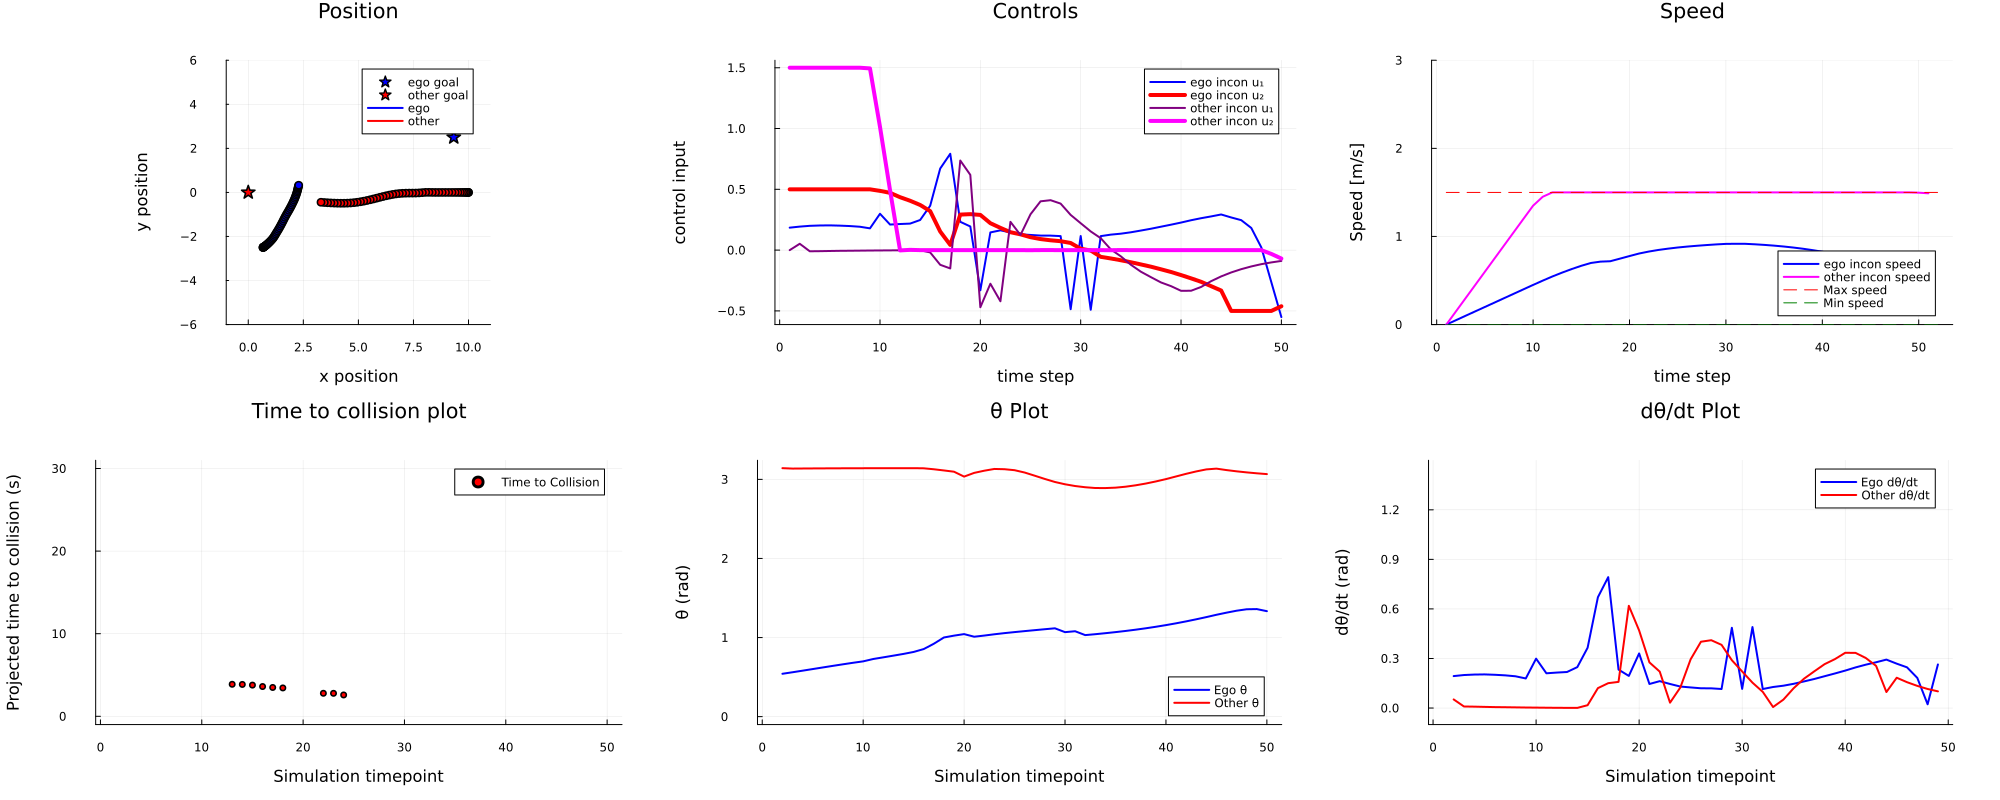

In [144]:
combine_sim_data_plots(hj_sim_sweep_test["Run 2"])

In [145]:
@doc @time

```
@time expr
@time "description" expr
```

A macro to execute an expression, printing the time it took to execute, the number of allocations, and the total number of bytes its execution caused to be allocated, before returning the value of the expression. Any time spent garbage collecting (gc), compiling new code, or recompiling invalidated code is shown as a percentage.

Optionally provide a description string to print before the time report.

In some cases the system will look inside the `@time` expression and compile some of the called code before execution of the top-level expression begins. When that happens, some compilation time will not be counted. To include this time you can run `@time @eval ...`.

See also [`@showtime`](@ref), [`@timev`](@ref), [`@timed`](@ref), [`@elapsed`](@ref), [`@allocated`](@ref), and [`@allocations`](@ref).

!!! note
    For more serious benchmarking, consider the `@btime` macro from the BenchmarkTools.jl package which among other things evaluates the function multiple times in order to reduce noise.


!!! compat "Julia 1.8"
    The option to add a description was introduced in Julia 1.8.

    Recompilation time being shown separately from compilation time was introduced in Julia 1.8


```julia-repl
julia> x = rand(10,10);

julia> @time x * x;
  0.606588 seconds (2.19 M allocations: 116.555 MiB, 3.75% gc time, 99.94% compilation time)

julia> @time x * x;
  0.000009 seconds (1 allocation: 896 bytes)

julia> @time begin
           sleep(0.3)
           1+1
       end
  0.301395 seconds (8 allocations: 336 bytes)
2

julia> @time "A one second sleep" sleep(1)
A one second sleep: 1.005750 seconds (5 allocations: 144 bytes)

julia> for loop in 1:3
            @time loop sleep(1)
        end
1: 1.006760 seconds (5 allocations: 144 bytes)
2: 1.001263 seconds (5 allocations: 144 bytes)
3: 1.003676 seconds (5 allocations: 144 bytes)
```


In [143]:
compute_path_irregularity_index(hj_sim_sweep_test["Run 2"])

(ego_ideal_velocity, ego_velocities[i]) = ([1.9441943743413014e-9 1.1224811452168386e-9], [0.0 0.0])
(other_ideal_velocity, other_velocities[i]) = 

([3.510224740914766e-9 -1.3875548817221596e-19], [-0.0 0.0])


(ego_ideal_velocity, ego_velocities[i]) = ([0.042831932791477366 0.025795843505405782], [0.04283193271611761 0.02579584345978968])
(other_ideal_velocity, other_velocities[i]) = 

([-0.14999972839942483 1.3990994123113512e-6], [-0.14999972859687247 1.3991157098882682e-6])


(ego_ideal_velocity, ego_velocities[i]) = ([0.084649891035723 0.05323900987002928], [0.08464988988260415 0.05323900912307195])
(other_ideal_velocity, other_velocities[i]) = 

([-0.2999954229967061 -0.0015680539884535502], [-0.2999954221647006 -0.001568053989523516])


(ego_ideal_velocity, ego_velocities[i]) = ([0.1253530997480296 0.08237978507230535], [0.1253530981432197 0.08237978399217162])
(other_ideal_velocity, other_velocities[i]) = 

([-0.44999502587391643 -0.001927516317993693], [-0.44999503415182573 -0.0019275163449485695])


(ego_ideal_velocity, ego_velocities[i]) = ([0.16487632543219283 0.11320387489316701], [0.16487632788283785 0.11320387676771913])
(other_ideal_velocity, other_velocities[i]) = 

([-0.5999946176529164 -0.00206121414136212], [-0.5999946174898507 -0.002061214140197608])


(ego_ideal_velocity, ego_velocities[i]) = ([0.20317174978612113 0.14567140158975814], [0.20317174971379642 0.14567140160215364])
(other_ideal_velocity, other_velocities[i]) = 

([-0.7499949830377937 -0.0020478927231950884], [-0.7499949784554967 -0.0020478927388257774])


(ego_ideal_velocity, ego_velocities[i]) = ([0.24023650859574858 0.17968019492708473], [0.24023650629158336 0.179680192696739])
(other_ideal_velocity, other_velocities[i]) = 

([-0.8999943318683716 -0.001940938871320153], [-0.8999943314890495 -0.0019409388741903463])


(ego_ideal_velocity, ego_velocities[i]) = ([0.27607161614028547 0.21513360520027208], [0.27607161476119757 0.21513360445448537])
(other_ideal_velocity, other_velocities[i]) = 

([-1.0499948499657559 -0.001735303119772166], [-1.0499948491983844 -0.0017353031257272874])


(ego_ideal_velocity, ego_velocities[i]) = ([0.31072370181600895 0.25188812786018827], [0.31072370374738545 0.25188813015412437])
(other_ideal_velocity, other_velocities[i]) = 

([-1.1999942396968863 -0.001483496671890312], [-1.1999942397007115 -0.0014834966718135062])


(ego_ideal_velocity, ego_velocities[i]) = ([0.3444319194131562 0.2895897722706849], [0.3444319168036578 0.2895897702461749])
(other_ideal_velocity, other_velocities[i]) = 

([-1.3494369231141774 -0.001227539256629455], [-1.3494369233186356 -0.0012275392555240153])


(ego_ideal_velocity, ego_velocities[i]) = ([0.37196331459880666 0.3322169534419016], [0.3719633137634437 0.3322169531407517])
(other_ideal_velocity, other_velocities[i]) = 

([-1.4507356287539468 -0.0009316849697058162], [-1.4507356286652273 -0.0009316849689156755])


(ego_ideal_velocity, ego_velocities[i]) = ([0.3993679623906274 0.37208919171795973], [0.3993679602876019 0.3720891892514131])
(other_ideal_velocity, other_velocities[i]) = 

([-1.4999955665998215 -0.000657306566624702], [-1.4999912760916947 -0.0006573046738865284])


(ego_ideal_velocity, ego_velocities[i]) = ([0.4224893816775464 0.4109276439413647], [0.4224893818992915 0.41092764428021894])
(other_ideal_velocity, other_velocities[i]) = 

([-1.4997597536868656 -0.0004395688577497834], [-1.4997596465878744 -0.0004395688250450975])


(ego_ideal_velocity, ego_velocities[i]) = ([0.44190371743335705 0.44898554366094434], [0.44190371793751243 0.4489855439604394])
(other_ideal_velocity, other_velocities[i]) = 

([-1.4999987512678739 -0.0002598561018041129], [-1.4999975254380256 -0.0002598558926497896])


(ego_ideal_velocity, ego_velocities[i]) = ([0.4560300353388349 0.48689890915837286], [0.45603003457888647 0.48689890846082423])
(other_ideal_velocity, other_velocities[i]) = 

([-1.499999359598729 -0.00012342414334274703], [-1.4999987242860684 -0.0001234240912512969])


(ego_ideal_velocity, ego_velocities[i]) = ([0.459013750373408 0.5274148948128566], [0.45901374998179506 0.5274148944787732])
(other_ideal_velocity, other_velocities[i]) = 

([-1.4999972241863753 0.002715487946486839], [-1.4999969063360143 0.0027154873708347487])


(ego_ideal_velocity, ego_velocities[i]) = ([0.43185814930661703 0.5691851289481756], [0.4318581487437744 0.5691851285261776])
(other_ideal_velocity, other_velocities[i]) = 

([-1.499855591800847 0.02080206731947455], [-1.4998554329983587 0.020802065110780178])


(ego_ideal_velocity, ego_velocities[i]) = ([0.3877674246675602 0.6052024157307939], [0.38776742514307866 0.60520241593809])
(other_ideal_velocity, other_velocities[i]) = 

([-1.4993719495732105 0.043380252460433526], [-1.4993713130185733 0.04338023423175512])


(ego_ideal_velocity, ego_velocities[i]) = ([0.3887575800624014 0.6390385677594109], [0.38875758029003593 0.6390385678846252])
(other_ideal_velocity, other_velocities[i]) = 

([-1.4984967831442306 -0.06712691245757985], [-1.4984963274329368 -0.06712689204042124])


(ego_ideal_velocity, ego_velocities[i]) = ([0.39113621995931264 0.6720476613495], [0.3911362190336381 0.6720476605049904])
(other_ideal_velocity, other_velocities[i]) = 

([-1.4914765502676897 -0.15967770561890102], [-1.4914763082212925 -0.15967767970347507])


(ego_ideal_velocity, ego_velocities[i]) = ([0.42852105755636566 0.6832992498488256], [0.4285210576485809 0.6832992498884278])
(other_ideal_velocity, other_velocities[i]) = 

([-1.497328237861096 -0.08948117456652109], [-1.4973278160827213 -0.08948114936379])


(ego_ideal_velocity, ego_velocities[i]) = ([0.4300099300774954 0.7083949359279695], [0.43000993002976245 0.7083949357693363])
(other_ideal_velocity, other_velocities[i]) = 

([-1.4992290884901471 -0.04807558886080439], [-1.4992287962702022 -0.048075579479279644])


(ego_ideal_velocity, ego_velocities[i]) = ([0.42766758440531144 0.7311076075758305], [0.42766758426050083 0.7311076073928177])
(other_ideal_velocity, other_velocities[i]) = 

([-1.4999247599172179 0.015001342748918385], [-1.4999245351620152 0.015001340501067068])


(ego_ideal_velocity, ego_velocities[i]) = ([0.4242252115072299 0.7500893995667892], [0.42422521145275177 0.7500893994734414])
(other_ideal_velocity, other_velocities[i]) = 

([-1.4998673504107145 -0.019894313123568715], [-1.4998666346469056 -0.019894303629620264])


(ego_ideal_velocity, ego_velocities[i]) = ([0.42066424041499434 0.7669259731011988], [0.4206642404108133 0.7669259730934942])
(other_ideal_velocity, other_velocities[i]) = 

([-1.4994995052340416 -0.03856477267140551], [-1.499494842727075 -0.038564652759208264])


(ego_ideal_velocity, ego_velocities[i]) = ([0.4160584763967377 0.7815099958987058], [0.41605847614858243 0.7815099956358885])
(other_ideal_velocity, other_velocities[i]) = 

([-1.4976827340427519 -0.08279319171081613], [-1.497652231099588 -0.08279153429872184])


(ego_ideal_velocity, ego_velocities[i]) = ([0.41085090173670197 0.7945128399686163], [0.4108509018675919 0.7945128400656913])
(other_ideal_velocity, other_velocities[i]) = 

([-1.49316641854721 -0.1428348014085364], [-1.4931490755487429 -0.1428331423501357])


(ego_ideal_velocity, ego_velocities[i]) = ([0.4049680378179634 0.8065842122583721], [0.40496803807264603 0.8065842124556606])
(other_ideal_velocity, other_velocities[i]) = 

([-1.4860608923400012 -0.2040244732935614], [-1.4860618703265378 -0.20402460756117707])


(ego_ideal_velocity, ego_velocities[i]) = ([0.3988663321641114 0.8178120453515217], [0.39886633180601466 0.8178120449849359])
(other_ideal_velocity, other_velocities[i]) = 

([-1.4771686024661241 -0.2607187025737037], [-1.4771690364216352 -0.2607187791659276])


(ego_ideal_velocity, ego_velocities[i]) = ([0.44093626304260414 0.8026351006226884], [0.4409362629742286 0.8026351005550898])
(other_ideal_velocity, other_velocities[i]) = 

([-1.4690008900056297 -0.30337606252500987], [-1.4690011023077842 -0.30337610635133244])


(ego_ideal_velocity, ego_velocities[i]) = ([0.4321291605863244 0.8086962822966675], [0.43212916055120143 0.8086962822314161])
(other_ideal_velocity, other_velocities[i]) = 

([-1.4619271170597594 -0.3358113078597768], [-1.461927159740749 -0.33581131753024873])


(ego_ideal_velocity, ego_velocities[i]) = ([0.47106144829489066 0.7862568589538746], [0.4710614482726155 0.7862568589289303])
(other_ideal_velocity, other_velocities[i]) = 

([-1.4565890768763388 -0.3582487011664302], [-1.4565871028610953 -0.35824821145885893])


(ego_ideal_velocity, ego_velocities[i]) = ([0.45919404799863167 0.7868703044620142], [0.45919404804017544 0.7868703044913926])
(other_ideal_velocity, other_velocities[i]) = 

([-1.4530014467669572 -0.37250670205781816], [-1.452993209545262 -0.372504584841282])


(ego_ideal_velocity, ego_velocities[i]) = ([0.4457538708592558 0.7867017116284751], [0.44575387078437995 0.7867017115123957])
(other_ideal_velocity, other_velocities[i]) = 

([-1.4526957183881664 -0.37338186311446175], [-1.4527072002605261 -0.37338481487407876])


(ego_ideal_velocity, ego_velocities[i]) = ([0.4310674502105391 0.7853633802131483], [0.43106745016050035 0.785363380130144])
(other_ideal_velocity, other_velocities[i]) = 

([-1.4546642002305537 -0.3659934723728599], [-1.4546639290160914 -0.365993403670526])


(ego_ideal_velocity, ego_velocities[i]) = ([0.41483025159570613 0.7828024480039563], [0.41483025135303253 0.7828024477591233])
(other_ideal_velocity, other_velocities[i]) = 

([-1.4589597400223995 -0.34847676004993233], [-1.4589596023026798 -0.34847672716506445])


(ego_ideal_velocity, ego_velocities[i]) = ([0.39682915395768104 0.7789053723682521], [0.3968291538375256 0.7789053721896539])
(other_ideal_velocity, other_velocities[i]) = 

([-1.464915103739528 -0.3225267790103834], [-1.464915033587316 -0.3225267635439866])


(ego_ideal_velocity, ego_velocities[i]) = ([0.37709894679726685 0.7735251936098796], [0.37709894677822126 0.7735251935697653])
(other_ideal_velocity, other_velocities[i]) = 

([-1.471719732310567 -0.28988535423571704], [-1.4717172809680514 -0.2898848695349598])


(ego_ideal_velocity, ego_velocities[i]) = ([0.35549607337452377 0.7663548116827588], [0.3554960732943671 0.7663548115438339])
(other_ideal_velocity, other_velocities[i]) = 

([-1.4789013514158802 -0.250692747512691], [-1.4789000609415566 -0.25069252736666914])


(ego_ideal_velocity, ego_velocities[i]) = ([0.3321655439054002 0.7571738293847654], [0.33216554394457964 0.7571738293865572])
(other_ideal_velocity, other_velocities[i]) = 

([-1.4856743940065982 -0.20680818786438515], [-1.4856737448231274 -0.20680809729357866])


(ego_ideal_velocity, ego_velocities[i]) = ([0.307107301981056 0.7455463753549232], [0.30710730210405546 0.7455463755502763])
(other_ideal_velocity, other_velocities[i]) = 

([-1.4917588097755283 -0.1570180109128321], [-1.4917584806885202 -0.1570179758666427])


(ego_ideal_velocity, ego_velocities[i]) = ([0.2803808539383283 0.7312044032640547], [0.28038085405241286 0.7312044031682366])
(other_ideal_velocity, other_velocities[i]) = 

([-1.49617053530704 -0.1071097189564616], [-1.4961701252495319 -0.10710968933765597])


(ego_ideal_velocity, ego_velocities[i]) = ([0.25240171886227497 0.7137559853004469], [0.25240171916585186 0.7137559856701197])
(other_ideal_velocity, other_velocities[i]) = 

([-1.4987280320006244 -0.061750319181329436], [-1.4987276381984438 -0.061750302881726886])


(ego_ideal_velocity, ego_velocities[i]) = ([0.2234146878157428 0.692269489765779], [0.2234146878208063 0.6922694896149126])
(other_ideal_velocity, other_velocities[i]) = 

([-1.4998159809848486 -0.0234729795154793], [-1.4998156341725786 -0.023472974036715086])


(ego_ideal_velocity, ego_velocities[i]) = ([0.1937482359490388 0.6666217196373847], [0.193748235991524 0.6666217196289304])
(other_ideal_velocity, other_velocities[i]) = 

([-1.499973145510902 0.008934961636960405], [-1.4999729028451774 0.00893496020038958])


(ego_ideal_velocity, ego_velocities[i]) = ([0.16310876446409617 0.6232156611868629], [0.16310876451957715 0.6232156611495481])
(other_ideal_velocity, other_velocities[i]) = 

([-1.499556612680901 0.036462369917456196], [-1.4995564591215202 0.03646236618284624])


(ego_ideal_velocity, ego_velocities[i]) = ([0.136236960872327 0.5783779499562288], [0.13623696115700173 0.578377950058773])
(other_ideal_velocity, other_velocities[i]) = 

([-1.498801734782574 0.059939143686239066], [-1.498801515331106 0.0599391349105969])


(ego_ideal_velocity, ego_velocities[i]) = ([0.1150904132446019 0.5318976338098294], [0.11509041323794758 0.531897633774125])
(other_ideal_velocity, other_velocities[i]) = 

([-1.49786286951228 0.08004044668634581], [-1.4978627526689905 0.08004044044259133])


(ego_ideal_velocity, ego_velocities[i]) = ([0.1034196805691279 0.48326452268295406], [0.10341968071107985 0.4832645228130499])
(other_ideal_velocity, other_velocities[i]) = 

([-1.4968390890383918 0.09732670748866919], [-1.4968390047045312 0.09732670200510053])


(ego_ideal_velocity, ego_velocities[i]) = ([0.10438640780877133 0.4317673451300226], [0.10438640805758491 0.4317673453554051])
(other_ideal_velocity, other_velocities[i]) = 

([-1.4926730980854814 0.11220152871500805], [-1.492673098053484 0.11220152871726592])


Dict{String, Float64} with 2 entries:
  "ego PI"   => 0.0
  "other PI" => 0.0

In [142]:
function compute_path_irregularity_index(sim_data::SimData)
    sim_horizon = length(sim_data.ego_states[:, 1])

    ego_hps = sim_data.sim_params.ego_planner_params.hps
    ego_opt_params = sim_data.sim_params.ego_planner_params.opt_params
    ego_dyn = sim_data.sim_params.ego_planner_params.hps.dynamics
    ego_xs = sim_data.ego_states
    ego_us = sim_data.ego_controls
    ego_goal = sim_data.sim_params.ego_planner_params.opt_params.goal_state
    
    other_hps = sim_data.sim_params.other_planner_params.hps
    other_opt_params = sim_data.sim_params.other_planner_params.opt_params
    other_dyn = sim_data.sim_params.other_planner_params.hps.dynamics
    other_xs = sim_data.other_states
    other_us = sim_data.other_controls
    other_goal = sim_data.sim_params.other_planner_params.opt_params.goal_state
    
    ego_PI = 0.
    other_PI = 0.

    ego_velocities = get_velocity(ego_dyn, matrix_to_vector_of_vectors(ego_xs)[1:end-1], matrix_to_vector_of_vectors(ego_us))
    other_velocities = get_velocity(other_dyn, matrix_to_vector_of_vectors(other_xs)[1:end-1], matrix_to_vector_of_vectors(other_us))

    for i in 1:sim_horizon-1
        # ego PI
        ego_opt_params = PlannerOptimizerParams(ego_dyn, ego_hps, ego_xs[i, :], ego_goal, "ECOS")
        ego_ideal_problem = IdealProblem(ego_dyn, ego_hps, ego_opt_params)
        solve(ego_ideal_problem, iterations=10)
        # print(ego_ideal_problem.opt_params.goal_state)

        ego_state = vector_of_vectors_to_matrix(ego_ideal_problem.opt_params.previous_states)[1, :]
        ego_control = vector_of_vectors_to_matrix(ego_ideal_problem.opt_params.previous_controls)[1, :]

        ego_ideal_velocity = get_velocity(ego_dyn, ego_state, ego_control)
        @show ego_ideal_velocity, ego_velocities[i]
        if norm(ego_velocities[i]) * norm(ego_ideal_velocity) != 0
            ego_PI += acos(round(dot(ego_velocities[i], ego_ideal_velocity) / (norm(ego_velocities[i]) * norm(ego_ideal_velocity)), digits=4))
        end

        ego_ideal_problem = nothing
        ego_opt_params = nothing

        # other PI
        other_opt_params = PlannerOptimizerParams(other_dyn, other_hps, other_xs[i, :], other_goal, "ECOS")
        other_ideal_problem = IdealProblem(other_dyn, other_hps, other_opt_params)
        solve(other_ideal_problem, iterations=10)

        other_state = vector_of_vectors_to_matrix(other_ideal_problem.opt_params.previous_states)[1, :]
        other_control = vector_of_vectors_to_matrix(other_ideal_problem.opt_params.previous_controls)[1, :]

        other_ideal_velocity = get_velocity(other_dyn, other_state, other_control)
        @show other_ideal_velocity, other_velocities[i]

        if norm(other_velocities[i]) * norm(other_ideal_velocity) != 0
            other_PI += acos(round(dot(other_velocities[i], other_ideal_velocity) / (norm(other_velocities[i]) * norm(other_ideal_velocity)), digits=4))
        end

        other_ideal_problem = nothing
        other_opt_params = nothing
    end

    Dict("ego PI" => ego_PI, "other PI" => other_PI)
end

compute_path_irregularity_index (generic function with 1 method)

# Broken PI

In [135]:
function PlannerOptimizerParams(dyn::Dynamics, hp::PlannerHyperparameters, solver::String)
    # initialize planner parameters / allocation space
    n = dyn.state_dim
    m = dyn.ctrl_dim
    p = 2 # size of position dimension
    As = [Matrix{Float64}(undef, n, n) for i in 1:hp.time_horizon]
    Bs = [Matrix{Float64}(undef, n, m) for i in 1:hp.time_horizon]
    Cs = [Vector{Float64}(undef, n) for i in 1:hp.time_horizon]
    Gs = [Vector{Float64}(undef, p) for i in 1:hp.time_horizon+1]
    Hs = Vector{Float64}(undef, hp.time_horizon+1)

    inconvenience_budget = 1.
    initial_state = zeros(Float64, n)
    goal_state = ones(Float64, n)
    previous_states = matrix_to_vector_of_vectors(Matrix{Float64}(undef, hp.time_horizon+1, n))
    previous_controls = matrix_to_vector_of_vectors(Matrix{Float64}(undef, hp.time_horizon, m))
    other_positions = [Vector{Float64}(undef, p) for i in 1:hp.time_horizon+1]

    return PlannerOptimizerParams(As, Bs, Cs, Gs, Hs, inconvenience_budget, initial_state, goal_state, previous_states, previous_controls, other_positions, solver)
end

# initialize planner parameters with straight line trajectory
function PlannerOptimizerParams(dyn::Dynamics, hp::PlannerHyperparameters, start_position::Vector{T}, end_position::Vector{T}, solver::String) where {T}
    # initialize planner parameters / allocation space
    n = dyn.state_dim
    m = dyn.ctrl_dim
    N = hp.time_horizon
    p = 2 # size of position dimension
    inconvenience_budget = 1.  # arbitrary number

    # use straight line trajectory
    previous_states_, previous_controls_ = initial_straight_trajectory(dyn, start_position, end_position, dyn.velocity_max * 0.75, hp.time_horizon)
    previous_states = matrix_to_vector_of_vectors(previous_states_)
    previous_controls = matrix_to_vector_of_vectors(previous_controls_)
    initial_state = previous_states[1]
    goal_state = previous_states[end]

    ABCs = linearized_dynamics(dyn, previous_states[1:N], previous_controls[1:N])
    As = [Matrix{Float64}(undef, n, n) for i in 1:hp.time_horizon]
    Bs = [Matrix{Float64}(undef, n, m) for i in 1:hp.time_horizon]
    Cs = [Vector{Float64}(undef, n) for i in 1:hp.time_horizon]

    for (t, (A, B, C)) in enumerate(ABCs)
        As[t] = A
        Bs[t] = B
        Cs[t] = C
    end

    # left as undef as the other agent's trajectory is needed
    Gs = [Vector{Float64}(undef, p) for i in 1:hp.time_horizon+1]
    Hs = Vector{Float64}(undef, hp.time_horizon+1)
    other_positions = [Vector{Float64}(undef, p) for i in 1:hp.time_horizon+1]

    return PlannerOptimizerParams(As, Bs, Cs, Gs, Hs, inconvenience_budget, initial_state, goal_state, previous_states, previous_controls, other_positions, solver)
end

function PlannerOptimizerParams(dyn::Dynamics, hps::PlannerHyperparameters, start_position::Vector{T}, end_position::Vector{T}, other_positions::Vector{Vector{T}}, solver::String) where {T}
    # initialize planner parameters / allocation space
    n = dyn.state_dim
    m = dyn.ctrl_dim
    N = hps.time_horizon
    p = 2 # size of position dimension
    inconvenience_budget = 1.  # arbitrary number

    # use straight line trajectory
    previous_states_, previous_controls_ = initial_straight_trajectory(dyn, start_position, end_position, dyn.velocity_max * 0.75, hps.time_horizon)
    previous_states = matrix_to_vector_of_vectors(previous_states_)
    previous_controls = matrix_to_vector_of_vectors(previous_controls_)
    initial_state = previous_states[1]
    goal_state = previous_states[end]

    ABCs = linearized_dynamics(dyn, previous_states[1:N], previous_controls[1:N])
    As = [Matrix{Float64}(undef, n, n) for i in 1:hps.time_horizon]
    Bs = [Matrix{Float64}(undef, n, m) for i in 1:hps.time_horizon]
    Cs = [Vector{Float64}(undef, n) for i in 1:hps.time_horizon]

    for (t, (A, B, C)) in enumerate(ABCs)
        As[t] = A
        Bs[t] = B
        Cs[t] = C
    end

    ps = get_position(robot, previous_states)
    Gs = linearize_collision_avoidance(ps, other_positions)
    Hs = collision_avoidance_constraint(hps.collision_radius, ps, other_positions) - dot.(Gs, ps)

    return PlannerOptimizerParams(As, Bs, Cs, Gs, Hs, inconvenience_budget, initial_state, goal_state, previous_states, previous_controls, other_positions, solver)
end

function InteractionPlanner(ego_hps::PlannerHyperparameters,
    other_hps::PlannerHyperparameters,
    ego_initial_state::Vector{T},
    other_initial_state::Vector{T},
    ego_goal_state::Vector{T},
    other_goal_state::Vector{T},
    solver::String) where {T}
ego = ego_hps.dynamics
other = other_hps.dynamics

# setting up ego ideal planner
ego_opt_params = PlannerOptimizerParams(ego,
ego_hps,
get_position(ego, ego_initial_state),
get_position(ego, ego_goal_state),
solver
)
ego_opt_params.initial_state = ego_initial_state
ego_opt_params.goal_state = ego_goal_state
ego_ideal_problem = IdealProblem(ego, ego_hps, ego_opt_params)

# setting up other ideal planner
other_opt_params = PlannerOptimizerParams(other,
other_hps,
get_position(other, other_initial_state),
get_position(other, other_goal_state),
solver
)
other_opt_params.initial_state = other_initial_state
other_opt_params.goal_state = other_goal_state
other_ideal_problem = IdealProblem(other, other_hps, other_opt_params)

# solve ego and other ideal problem
_, ego_ideal_xs, ego_ideal_us = solve(ego_ideal_problem, iterations=3, verbose=false, keep_history=false)
_, other_ideal_xs, other_ideal_us = solve(other_ideal_problem, iterations=3, verbose=false, keep_history=false)

# update previous states and controls with ideal solution
# ego_opt_params.previous_states = matrix_to_vector_of_vectors(ego_ideal_xs[end])
# ego_opt_params.previous_controls = matrix_to_vector_of_vectors(ego_ideal_us[end])
# other_opt_params.previous_states = matrix_to_vector_of_vectors(other_ideal_xs[end])
# other_opt_params.previous_controls = matrix_to_vector_of_vectors(other_ideal_us[end])
ego_ps = get_position(ego, ego_opt_params.previous_states)
other_ps = get_position(other, other_opt_params.previous_states)

# set up ego inconvenience planner
Gs = linearize_collision_avoidance(ego_ps, other_ps)
Hs = collision_avoidance_constraint(ego_hps.collision_radius, ego_ps, other_ps) - dot.(Gs, ego_ps)
ego_opt_params.Gs = Gs
ego_opt_params.Hs = Hs
ego_opt_params.other_positions = other_ps
ego_incon_problem = InconvenienceProblem(ego, ego_hps, ego_opt_params)

# set up other inconvenience planner
# update previous states and controls with ideal solution
Gs = linearize_collision_avoidance(other_ps, ego_ps)
Hs = collision_avoidance_constraint(other_hps.collision_radius, other_ps, ego_ps) - dot.(Gs, other_ps)
other_opt_params.Gs = Gs
other_opt_params.Hs = Hs
other_opt_params.other_positions = ego_ps
other_incon_problem = InconvenienceProblem(other, other_hps, other_opt_params)

ego_planner = AgentPlanner(ego_ideal_problem, ego_incon_problem)
other_planner = AgentPlanner(other_ideal_problem, other_incon_problem)

InteractionPlanner(ego_planner, other_planner)
end

InteractionPlanner

In [136]:
# setting up the human planner to be used for experiments (overly aware human)
dt = 0.1
velocity_max = 1.5
human = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 1.5])

time_horizon = 25
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([0.1; 0.3]) 
Qt = diagm([10.; 10.; 0.; 0.])
markup = 1.15
collision_slack = 500.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.1]
collision_radius = 1.
inconvenience_ratio = 0.3


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 1.5
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 1.5])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 0.0]) 
Qt = diagm([10.; 10.; 0.; 0.])
markup = 1.0
collision_slack = 150.


robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)

robot_initial_state = [0.; 0.; 0.; 0.]
robot_goal_state = [10.; 0.; 0.; 0.]
human_initial_state = [10.; 0.; pi; 0.]
human_goal_state = [0.; 0.; pi; 0.]
# setting up the IP object to be serialized and saved for all trials
human_ip = InteractionPlanner(human_hps, 
                        robot_hps,
                        human_initial_state,
                        robot_initial_state,
                        human_goal_state,
                        robot_goal_state,
                        solver)

# saving object
# serialize("../experimental_setup/overly_aware_human_ip.dat", human_ip)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [137]:
# Robot model for sfm
robot = DynamicallyExtendedUnicycle(dt, 2., [1., 2.])

DynamicallyExtendedUnicycle{Float64}
  dt: Float64 0.1
  state_dim: Int64 4
  ctrl_dim: Int64 2
  velocity_min: Float64 0.0
  velocity_max: Float64 2.0
  control_min: Array{Float64}((2,)) [-1.0, -2.0]
  control_max: Array{Float64}((2,)) [1.0, 2.0]


In [138]:
states = deserialize("../experimental_setup/head-on_experiment_states.dat")[1:3]

3-element Vector{Tuple{Vector{Float64}, Vector{Float64}}}:
 ([0.0, 0.0, 0.0, 0.0], [10.0, 0.0, 0.0, 0.0])
 ([0.00015421177605201564, -0.039269504443556674, 0.007853981633974483, 0.0], [9.999845788223947, 0.039269504443556674, 0.007853981633974483, 0.0])
 ([0.0006168375916972835, -0.07853658655910338, 0.015707963267948967, 0.0], [9.999383162408304, 0.07853658655910338, 0.015707963267948967, 0.0])

In [140]:
metrics_test = run_experiment(robot, human_ip, 50, states, [([10.; 0.; pi; 0.], [0.; 0.; pi; 0.])])

--------------------------------------------------------------------------------
Running Simulations
--------------------------------------------------------------------------------
DynamicallyExtendedUnicycle{Float64}

0.0%┣                                                ┫ 0/3 [00:00<00:00, -0s/it]


DynamicallyExtendedUnicycle{Float64}

33.3%┣██████████████▍                            ┫ 1/3 [00:05<Inf:Inf, InfGs/it]


DynamicallyExtendedUnicycle{Float64}

66.7%┣████████████████████████████████                ┫ 2/3 [00:09<00:09, 9s/it]


--------------------------------------------------------------------------------
Evaluating Simulations
--------------------------------------------------------------------------------
[2.812499999999999, 0.0, 0.0, 1.125]

100.0%┣███████████████████████████████████████████████┫ 3/3 [00:14<00:00, 7s/it]
100.0%┣███████████████████████████████████████████████┫ 3/3 [00:14<00:00, 7s/it]
0.0%┣                                                ┫ 0/3 [00:00<00:00, -0s/it]


[2.817489893079499, 0.0, 0.0, 1.125]

[2.8321819091643605, 0.0005848300427434222, -8.15910830931095e-5, 1.125]

[2.8560559533104324, 0.0018332411373953856, -0.0002566147054307584, 1.125]

[2.888722518303578, 0.0027625453621104783, -0.0003884738333237503, 1.125]

[2.9297377811661547, 0.0035533364570399188, -0.0005025748759933502, 1.125]

[2.9786832562099814, 0.004254722216303565, -0.0006059720492293145, 1.125]

[3.0351617056284756, 0.004887569890733631, -0.000701749112019703, 1.125]

[3.0987956396750476, 0.005462965160277367, -0.0007915957467669272, 1.125]

[3.1692262010401473, 0.005987694086777048, -0.0008765760262870327, 1.125]

[3.2461121611022223, 0.006466353336781064, -0.00095742652457321, 1.125]

[3.329128841712609, 0.006902305563911554, -0.001034692911458505, 1.125]

[3.4179667561041045, 0.007328494036744277, -0.001113408385655835, 1.125]

[3.512331759882962, 0.007713081930188032, -0.001188882971618895, 1.125]

[3.61194329573268, 0.008058447948325984, -0.0012614859333273248, 1.125]

[3.7165341014987487, 0.008366593431907357, -0.0013315244520328484, 1.125]

[3.825792350797818, 0.008639107862105574, -0.0013992244373665973, 1.125]

[3.939412784018829, 0.008878126386521218, -0.001464894360820338, 1.125]

[4.0571525163703255, 0.009085126741145972, -0.0015287485819951683, 1.125]

[4.17877665865547, 0.00926156363505406, -0.0015909981935843926, 1.125]

[4.304056678751953, 0.009408987892076186, -0.0016518737640725384, 1.125]

[4.432769874386281, 0.009529173369100774, -0.0017116526258202083, 1.125]

[4.5646982434757355, 0.00962425421021307, -0.0017706917817749512, 1.125]

[4.699627235722919, 0.009696869435033633, -0.0018294672937101512, 1.125]

[4.837344394861791, 0.009750334332765157, -0.001888625445055063, 1.125]

[4.977637876576768, 0.009788844119371776, -0.0019490493683141667, 1.125]

[5.120294832113806, 0.009817728537075547, -0.002011948458382776, 1.125]

[5.265099682211511, 0.009843799164217678, -0.0020789846293103992, 1.125]

[5.411832286689347, 0.00987581211189939, -0.0021524489681530195, 1.125]

[5.560265991428174, 0.009925064702434335, -0.0022355051338252235, 1.125]

[5.710165639613411, 0.010006163520290295, -0.0023325248792659035, 1.125]

[5.861285247016765, 0.010183069150004085, -0.002460437408512669, 1.125]

[6.013368827652226, 0.010453518967259396, -0.0026221374782968176, 1.125]

[6.166152482884927, 0.010857501166682987, -0.0028320041659407854, 1.125]

[6.319365418305319, 0.011448005364645297, -0.003110324644858822, 1.125]

[6.472730571675642, 0.01229339211552136, -0.003485229180835201, 1.125]

[6.625972117731825, 0.01348138858645638, -0.003995615126372224, 1.125]

[6.778830401267488, 0.015123655223283532, -0.004695047445847535, 1.125]

[6.931083469145425, 0.017359106646777832, -0.005656368082963322, 1.125]

[7.082581519106388, 0.020354950978730253, -0.0069769286904466715, 1.125]

[7.233311980097186, 0.02430147811380618, -0.008783373116830083, 1.125]

[7.383496903759016, 0.029388082158761576, -0.011231344036792983, 1.125]

[7.5336816703569225, 0.03574620114793723, -0.014492735175366053, 1.125]

[7.685106199316883, 0.0425433682694947, -0.018376039317364548, 1.125]

[7.838798502950793, 0.04886505467837529, -0.022606281921155713, 1.125]

[7.994991951077877, 0.0545562725345137, -0.02720328945374098, 1.125]

[8.153848964506988, 0.059398645448115066, -0.03216322001886563, 1.125]

[8.315415706650947, 0.06315893671001922, -0.03747474572904064, 1.125]

[8.479627502975202, 0.065604268644833, -0.04312337750751893, 1.125]

[8.646337712845, 0.06651916813635109, -0.04910065363039666, 1.125]

5151

33.3%┣██████████████▍                            ┫ 1/3 [00:06<Inf:Inf, InfGs/it]


[5.737477253763036, 0.005792251905424628, 0.007853981633974487, 1.125]

[5.742466992630921, 0.005831442028669249, 0.007853981633974485, 1.125]

[5.7571558261014415, 0.006292997009975645, 0.007772390555935793, 1.125]

[5.781023262179932, 0.007216966094040524, 0.007597361932012761, 1.125]

[5.813684425738463, 0.008017188030102295, 0.007465487616167866, 1.125]

[5.854694685187792, 0.008796443758818115, 0.007351363310547358, 1.125]

[5.9036353491065645, 0.009579915956693025, 0.007247935387161767, 1.125]

[5.9601091021178885, 0.010376329270868416, 0.007152120239555545, 1.125]

[6.023738420267305, 0.011188860420594594, 0.007062228099368039, 1.125]

[6.094164430346016, 0.012018363279098448, 0.006977194619721379, 1.125]

[6.171045896593204, 0.012864599117494803, 0.006896282772047289, 1.125]

[6.254058138214389, 0.013726784117996712, 0.006818946191170154, 1.125]

[6.3428915207429535, 0.014620701303158021, 0.006740152617227041, 1.125]

[6.437252066670986, 0.015525928927192078, 0.006664589294645729, 1.125]

[6.536859218025186, 0.0164415632805144, 0.006591885371829376, 1.125]

[6.641445731374598, 0.017366609503845644, 0.006521731787826511, 1.125]

[6.750699746884219, 0.01829954768529202, 0.006453900605867264, 1.125]

[6.864315880786977, 0.019239378919847134, 0.006388028071321146, 1.125]

[6.982051242310139, 0.020185042531889335, 0.0063238922380223555, 1.125]

[7.103671062397608, 0.021135522379188264, 0.006261274545983593, 1.125]

[7.228946856551612, 0.02208988793804977, 0.0061999361236020865, 1.125]

[7.35765588723481, 0.023047337428598918, 0.0061395901858462085, 1.125]

[7.489580102490336, 0.02400723072772745, 0.006079868655520049, 1.125]

[7.624504890253167, 0.024969110452632334, 0.006020281651316746, 1.125]

[7.762217728602222, 0.025932713929656893, 0.005960165065288191, 1.125]

[7.902506713660321, 0.026897972382764344, 0.0058986115917270075, 1.125]

[8.045158941197432, 0.027864989526891523, 0.005834379829452659, 1.125]

[8.189958777799541, 0.028834000615006163, 0.005765767768165632, 1.125]

[8.336686032933859, 0.029805301439456963, 0.00569043401886061, 1.125]

[8.48511402754534, 0.030779113950237427, 0.005605151880535385, 1.125]

[8.635007579484197, 0.03175535029870031, 0.0055054717680329684, 1.125]

[8.786120479789698, 0.03274672572618614, 0.00537412862413769, 1.125]

[8.93819597458091, 0.033739990474238535, 0.005208368991604483, 1.125]

[9.09096805469943, 0.034730677192421525, 0.004993839493744131, 1.125]

[9.24416507701921, 0.03571011981023916, 0.00471013519123927, 1.125]

[9.397511973290843, 0.036662126145937, 0.004328765789147528, 1.125]

[9.55073659357692, 0.03755823258731338, 0.0038103507894652194, 1.125]

[9.703583316048094, 0.0383508348567121, 0.0031008539004935077, 1.125]

[9.855837091262378, 0.03896320470842315, 0.0021269498280631705, 1.125]

[10.007361116973602, 0.03927544906613764, 0.0007909995077011551, 1.125]

[10.158157348472969, 0.039105988388338196, -0.0010328746480248265, 1.125]

[10.308452579589567, 0.03819015743514537, -0.003497468745488103, 1.125]

[10.458773063419775, 0.03616271936145337, -0.006769564137195411, 1.125]

[10.610309638140492, 0.032763531388104124, -0.01065702212411907, 1.125]

[10.764047981630636, 0.027891941189098685, -0.014887058457262658, 1.125]

[10.920193787373567, 0.021337848163576485, -0.019481096070514528, 1.125]

[11.078889418254066, 0.012899279802194023, -0.024433652166161862, 1.125]

[11.240164799134837, 0.0023757696724609127, -0.02973659130789472, 1.125]

[11.40394577460931, -0.010424014779445094, -0.03537695820223811, 1.125]

[11.570077899645067, -0.02569227645217564, -0.041347235725282934, 1.125]

5151

66.7%┣███████████████████████████████▍               ┫ 2/3 [00:19<00:19, 19s/it]


[5.737409016455223, 0.011584146517467742, 0.015707963267948967, 1.125]

[5.742398292697825, 0.011662524331843064, 0.015707963267948967, 1.125]

[5.757083045397329, 0.012239429613131077, 0.015626372205064326, 1.125]

[5.780942484473594, 0.0133508436312271, 0.015451338600268313, 1.125]

[5.8135963513489655, 0.014407621729830532, 0.015319449110065369, 1.125]

[5.854599219925706, 0.015509039425019387, 0.015205301551469489, 1.125]

[5.903532213629442, 0.01667698629364196, 0.015101842885398302, 1.125]

[5.95999796069146, 0.017917063831416478, 0.015005989658471969, 1.125]

[6.0236189237800355, 0.019229481919316206, 0.014916052016696069, 1.125]

[6.094036233992166, 0.020612274600418538, 0.014830965339353167, 1.125]

[6.170908667908752, 0.022062522242518402, 0.014749992143468628, 1.125]

[6.253911560810641, 0.02357689068733838, 0.014672585368612143, 1.125]

[6.342735163604429, 0.025168723829141253, 0.014593713694559687, 1.125]

[6.43708566827541, 0.026815298093745343, 0.014518061633884067, 1.125]

[6.536682532380129, 0.028513507507528672, 0.014445256747512483, 1.125]

[6.64125852561759, 0.030260259513885317, 0.014374988108713689, 1.125]

[6.750501788894758, 0.032051585571486046, 0.014307025684721565, 1.125]

[6.864106881535275, 0.03388425398954531, 0.014240950385767387, 1.125]

[6.981830932385491, 0.03575529282973211, 0.014176532650646789, 1.125]

[7.103439309789265, 0.03766183409287484, 0.014113546578596415, 1.125]

[7.228703601563815, 0.039601140638880115, 0.014051745216369777, 1.125]

[7.357401057047244, 0.04157064482525349, 0.013990832746741138, 1.125]

[7.489313596300507, 0.04356797417026131, 0.013930430799546627, 1.125]

[7.624226567004775, 0.04559096459958451, 0.013870036748780089, 1.125]

[7.761927408665179, 0.047637663121158774, 0.01380897000840979, 1.125]

[7.902204175455005, 0.04970631543363671, 0.01374630174699269, 1.125]

[8.044843913168648, 0.051795330983651716, 0.013680762480549703, 1.125]

[8.189630959723061, 0.053903225778034754, 0.013610614550061925, 1.125]

[8.336345119065529, 0.0560285341475509, 0.013533471667614958, 1.125]

[8.484759715758228, 0.05816965645233982, 0.013446050049866945, 1.125]

[8.634639601433847, 0.060324602462120736, 0.013343827863816986, 1.125]

[8.785738526721182, 0.06250434128254378, 0.013209231383433065, 1.125]

[8.937800931808045, 0.06469333310644675, 0.013039469261667052, 1.125]

[9.090563094265514, 0.06688500120338992, 0.01281986110226962, 1.125]

[9.24375427416505, 0.06906823114048265, 0.012529774953158768, 1.125]

[9.397097854276627, 0.0712240937571129, 0.012140647337736574, 1.125]

[9.550318206482439, 0.0733213231151113, 0.011613083860429013, 1.125]

[9.703154726354509, 0.0753096442922479, 0.010892994188501905, 1.125]

[9.855392103410882, 0.07711007013629538, 0.00990665507611703, 1.125]

[10.006905655964093, 0.07860094851975948, 0.008555725535670603, 1.125]

[10.157715930727528, 0.07959965991996092, 0.006714070612738429, 1.125]

[10.308063778931103, 0.07984221463380622, 0.004229680189903118, 1.125]

[10.458482332259756, 0.07896707389768881, 0.0009376780458083002, 1.125]

[10.610147883495976, 0.07672343713678718, -0.0029686457540333212, 1.125]

[10.764037797657188, 0.0730297648371762, -0.007201586530610819, 1.125]

[10.920332553496317, 0.06765724213886426, -0.01181263432311241, 1.125]

[11.079183416503676, 0.060416354416898285, -0.016779521438012618, 1.125]

[11.24061845697966, 0.05110582205239673, -0.022095971883212467, 1.125]

[11.404564824942035, 0.039533352449282855, -0.02774959514842897, 1.125]

[11.570870656208937, 0.025504970830517164, -0.03373332518495864, 1.125]

5151Experiment finished in 45.92580199241638

100.0%┣██████████████████████████████████████████████┫ 3/3 [00:32<00:00, 16s/it]
100.0%┣██████████████████████████████████████████████┫ 3/3 [00:32<00:00, 16s/it]


Dict{String, SimMetrics} with 3 entries:
  "Run 2" => SimMetrics(Dict("Ego Avg Control Effort"=>0.382154, "Other Avg Con…
  "Run 1" => SimMetrics(Dict("Ego Avg Control Effort"=>0.382742, "Other Avg Con…
  "Run 3" => SimMetrics(Dict("Ego Avg Control Effort"=>0.382107, "Other Avg Con…

In [118]:
metrics_test

Dict{String, SimMetrics} with 3 entries:
  "Run 2" => SimMetrics(Dict("Ego Avg Control Effort"=>0.382154, "Other Avg Con…
  "Run 1" => SimMetrics(Dict("Ego Avg Control Effort"=>0.382742, "Other Avg Con…
  "Run 3" => SimMetrics(Dict("Ego Avg Control Effort"=>0.382107, "Other Avg Con…

In [56]:
metrics_test["Run 1"]

SimMetrics(Dict("Ego Avg Control Effort" => 0.3827420943843334, "Other Avg Control Effort" => 0.5200241287650329), Dict("ego PI" => 0.0, "other PI" => 0.0), Dict("ego average acceleration" => 0.33929971219396193, "other average acceleration" => 0.2999998089820444), Dict("Ego Path Efficiency" => 0.8935264362427106, "Other Path Efficiency" => 1.0030478556398996), Dict("Min Distance" => 1.0999124030016392), Dict("Time to collision" => [NaN, 36.999999943416476, 18.764135075977897, 12.574051825647533, 9.666291878491746, 7.800501705403518, 6.347918296685229, 5.374784527637915, 4.834996042379513, 3.9962809133882335  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN]), Dict("Other θ" => [0.0, 3.1415674997146636, 3.1415661281751, 3.078984280662268, 3.09314489413978, 3.1049857778352936, 3.1146058954374944, 3.1222349468821475, 3.1281580189236444, 3.132618187835813  …  3.0455336054528725, 3.1125418440172714, 3.117768383616714, 3.0758189770102677, 3.042353282307447, 3.0155109670960507, 2.99386096

In [124]:
display_data(metrics_test)

GtkLabelLeaf(name="", parent, width-request=-1, height-request=-1, visible=TRUE, sensitive=TRUE, app-paintable=FALSE, can-focus=FALSE, has-focus=FALSE, is-focus=FALSE, focus-on-click=TRUE, can-default=FALSE, has-default=FALSE, receives-default=FALSE, composite-child=FALSE, style, events=0, no-show-all=FALSE, has-tooltip=FALSE, tooltip-markup=NULL, tooltip-text=NULL, window, opacity=1.000000, double-buffered, halign=GTK_ALIGN_FILL, valign=GTK_ALIGN_FILL, margin-left, margin-right, margin-start=0, margin-end=0, margin-top=0, margin-bottom=100, margin=100, hexpand=FALSE, vexpand=FALSE, hexpand-set=FALSE, vexpand-set=TRUE, expand=FALSE, scale-factor=1, xpad, ypad, label="<b><u>Sim 3 Metrics</u></b>
<b> </b> 
<b>Ego Average Acceleration = </b>0.3396
<b>Other Average Acceleration = </b>0.3
<b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-</b><b>-<